# EIGSEP Image Fit

Aaron Parsons

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.image import imread
import torch
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
from eigsep_terrain.img import PRM_ORDER, PMR_ORDER_FULL, HorizonImage, PositionSolver, LogLikeOp
import healpy
import pymc as pm
import pytensor
pytensor.config.cxx = ""    #type: ignore
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import os, sys, glob, tqdm
import multiprocessing as mp
import arviz
from scipy.optimize import minimize
import emcee
import corner
import time

%matplotlib widget

# cache file setup

In [3]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [4]:
dem['platform'] = np.array([1648, 2024, 1796])

meta = {}
meta['0817'] = {
    'best_prms': ( 1732.31,  2069.73,   1760.89,  1.4682,  3.6963, -0.0521,  9849.36),  #[LOSS= 0.0378]
    'ant_px': (2*1366, 2*1221),
}
meta['0833'] = {
    'best_prms': ( 1611.38,  1847.62,   1659.85,  1.2062,  1.2401, -0.0250,  5072.38),  #[LOSS= 0.0254]
    'ant_px': (1606, 2700),
}

#meta['0834'] = {
#    'best_prms': ( 1642.45,  1887.80,   1678.94,  1.1787,  1.2417, -0.0310,  2933.66),  #[LOSS= 0.0685]
#    'ant_px': (1622, 2251),
#}

meta['0860'] = {
    #'best_prms': ( 1539.90,  1989.78,   1765.54,  1.5423,  0.6162,  0.1541,  2328.29),  #[LOSS= 0.0206]
    #'best_prms': ( 1538.80,  2001.28,   1765.46,  1.5411,  0.6109,  0.1589,  2328.29),  #[LOSS= 0.0166]
    'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0151]
    'ant_px': (2924, 1945),
}

for k in meta.keys():
    dem[k] = np.asarray(meta[k]['best_prms'][:3], dtype=np.float32)
    
files = sorted(glob.glob('//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/*.jpg'))
#files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))[-1:]
print(files)
imgs = [HorizonImage(f, meta) for f in files]
imgs = [img for img in imgs if img.key in meta]


['//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0817.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0833.jpg', '//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/IMG_0860.jpg']


In [5]:
dem.interp_alt(imgs[-1].prms['e'], imgs[-1].prms['n'])


1758

In [6]:
def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

# ray tracing

In [7]:
# overlay ray tracing

if False:
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 4 * 3))
    r_imgs = {}
    sl = slice(None, None, 4)
    img_pkg = imgs[-1]
    axes[0].imshow(img_pkg.img[sl,sl], origin='lower')
    axes[2].imshow(img_pkg.img[sl,sl], origin='lower')
    r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
    axes[1].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar')
    axes[0].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()


In [8]:
# i = imgs[0]
# npz = np.load(i.npzfile)
# plt.figure()
# plt.imshow(npz['sky'])


In [9]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    r_imgs = {}
    sl = slice(None, None, 8)
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img[sl,sl], origin='lower')
        r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
        axes[cnt].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()
    

In [10]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img, origin='lower')
        axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
        axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
        mask = img_pkg.mask_near_horizon(50)
        x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
        is_sky = img_pkg.sky_mask[x, y]
        axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
        axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
        axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')


In [11]:
#nside = 512
##e0, n0, u0 = (1754, 2100, 1747)
#e0, n0, u0 = start_point = np.array((1767, 2095, 1759), dtype=float)
#rays = et.ray.healpix_rays(nside)
##e0, n0, u0 = start_point = np.array(dem['1P'], dtype=float)
##e0, n0, u0 = (0, 0, 1759)

In [12]:
#healpy.mollview(h.map)
#healpy.mollview(np.log10(ray_trace(start_point)), cmap='plasma')
#healpy.mollview(np.log10(r), cmap='plasma')
#healpy.mollview(np.log10(r2), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

In [13]:
# for one image

if False:
    I = imgs[2]
    I.reset_pixel_choice()
    I.horizon_ray_loss(dem, cnt=16000);
    ant_ray = I.get_rays(np.array(I.meta['ant_px'][::-1]))
    prms = dict(zip(PRM_ORDER, I.get_prms()))
    r_ant = dem['platform'] - np.array([prms['e'], prms['n'], prms['u']])

    delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant))) # rad
    BOX_SIZE = 0.3 # m
    sigma_theta = BOX_SIZE / np.linalg.norm(r_ant)

    logL = -delta_theta / (2 * sigma_theta**2) # :0
    logL
                        

# 3 param mcmc
## setup

In [14]:
# setup for mcmc fitting only antenna ENU
sigmas = (30.0, 30.0, 30.0, np.deg2rad(5.0), np.deg2rad(5.0), np.deg2rad(5.0), 0.1)
BOX_SIZE = 0.3 # m
ANT_POS_ERR = 20 #m
ant_pos_prior = np.array([1646, 2022, 1782])
fit_imgs = []
static_imgs = imgs
n_rays = 1600

pos_slvr = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)


## pymc

In [15]:
# old: pymc
# def build_model():
#     """
#     eps: per-pixel error rate for mismatches (small)
#     """

#     with pm.Model() as model:
#         pos_slvr.set_mcmc_sigmas()
#         prms = pos_slvr.get_mcmc_prms()
               
#         theta = pt.stack(prms)
#         logp = pos_slvr.total_loss(theta)
            
#         pm.Potential("lik", logp)

#     return model

# if True:
#     with build_model() as model:
#         # step = pm.DEMetropolisZ(
#         step = pm.Metropolis(
#             S=np.array(pos_slvr.sigmas),
#             scaling=.01,      # much bigger than 1e-3, may need to tune this
#             tune='scaling',   # let it adapt scale
#             tune_interval=50, # adapt more often than default 100
#         )
        
#         trace = pm.sample(
#             draws=5000,
#             tune=3000,
#             chains=4,   # go back to 4 once this works
#             step=step,
#             cores=4,
#             random_seed=42,
#             progressbar=True,
#         )
#     arviz.to_netcdf(trace, f"{I.key}_trace.nc");
#     print(f"Accepted step fraction = {float(trace.sample_stats.accepted.mean()): 4.3f}")
#     # rejecting most steps = steps too big
#     # accepting most steps = steps too small

In [16]:
# trace_files = sorted(glob.glob("*.nc"))
# print(trace_files)
# traces = {f.split('_')[0]: arviz.from_netcdf(f) for f in trace_files}


In [17]:
# # Load the trace file
# trace = arviz.from_netcdf("0860_trace.nc")

# # Check if it actually has samples (not constants)
# print("Checking if samples vary:")
# for var in trace.posterior.data_vars:
#     data = trace.posterior[var].values
#     print(f"{var}: shape={data.shape}, std={data.std():.6e}, range={data.max()-data.min():.6e}")

In [18]:
# # Check if 0860 parameters actually vary
# posterior = traces['0860'].posterior

# for var in posterior.data_vars:
#     data = posterior[var].values.flatten()
#     print(f"{var}: min={data.min():.4f}, max={data.max():.4f}, "
#           f"unique={len(np.unique(data))}, std={data.std():.6f}")

In [19]:
# traces

In [20]:
# fig = plt.figure(figsize=(8, 8))
# # type(traces['0860'])
# corner.corner(traces['0860'], fig=fig);

In [21]:
# #e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
# #u = dem.interp_alt(e, n)
# #print(e, n, u)
# fig, ax = plt.subplots()
# e0, n0, u0 = dem['platform']
# rng = 750
# plot_img(ax, dem.data, dem.res)
# plt.plot([e0], [n0], 's', color='k')
# for img in imgs[-1:]:
#     e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
#     plt.plot([e], [n], '+', color='blue')
#     ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
#     plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
#     trace = traces[img.key]
#     # try:
#     #     plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
#     # except(KeyError):
#     plt.plot(np.asarray(trace.posterior['e']).flatten(), np.asarray(trace.posterior['n']).flatten(), '.');


In [22]:
# summary = arviz.summary(posterior)
# summary


In [23]:
# avgs = summary['mean']
# mean_ant_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ant_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ant_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna enu from mcmc: e: {np.round(mean_ant_e)}, n:{np.round(mean_ant_n)}, u:{np.round(mean_ant_u)}')


In [24]:
# avgs = summary['r_hat']
# mean_r_hat_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_r_hat_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_r_hat_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna r_hat from mcmc: e: {mean_r_hat_e}, n:{mean_r_hat_n}, u:{mean_r_hat_u}')


In [25]:
# avgs = summary['ess_bulk']
# mean_ess_bulk_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ess_bulk_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ess_bulk_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna ess_bulk from mcmc: e: {mean_ess_bulk_e}, n:{mean_ess_bulk_n}, u:{mean_ess_bulk_u}')


In [26]:
# arviz.plot_trace(posterior)


In [27]:
# arviz.plot_autocorr(posterior)


In [28]:
# # Test with prior
# theta_prior = ant_pos_prior
# pos_slvr.set_mcmc_prms(theta_prior)
# logp_prior = pos_slvr.total_loss(theta_prior)
# print(f"Log prob at prior [1646, 2022, 1782]: {logp_prior}")

# # Test with MCMC result
# theta_mcmc = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# pos_slvr.set_mcmc_prms(theta_mcmc)
# logp_mcmc = pos_slvr.total_loss(theta_mcmc)
# print(f"Log prob at MCMC [1804, 1804, 1804]: {logp_mcmc}")

# print(f"\nMCMC result is better: {logp_mcmc > logp_prior}")
# print(f"Difference: {logp_mcmc - logp_prior}")

In [29]:
# # Test a few random points
# import random
# for _ in range(5):
#     test_pos = ant_pos_prior + np.random.randn(3) * 50  # Random points near prior
#     pos_slvr.set_mcmc_prms(test_pos)
#     logp_test = pos_slvr.total_loss(test_pos)
#     print(f"Position {test_pos}: logp = {logp_test}")

## MAP

In [30]:
# MAP
def neg_log_prob(theta):
    return -pos_slvr.total_loss(theta, ray_cnt=1600)

result = minimize(
    neg_log_prob,
    x0=ant_pos_prior,
    method='Nelder-Mead',  # or 'Powell', doesn't need gradients
    options={'disp': True, 'maxiter': 1000}
)

print(f"Optimized position (MAP result): {result.x}")
print(f"Log probability: {-result.fun}")

Optimization terminated successfully.
         Current function value: 69.702669
         Iterations: 76
         Function evaluations: 144
Optimized position (MAP result): [1651.43521534 2024.61292153 1781.27910702]
Log probability: -69.70266863380425


In [31]:
# 1. The best estimate (MAP from scipy)
map_estimate = result.x
print(f"MAP Estimate:")
print(f"  ant_e: {map_estimate[0]:.2f}")
print(f"  ant_n: {map_estimate[1]:.2f}")
print(f"  ant_u: {map_estimate[2]:.2f}")


MAP Estimate:
  ant_e: 1651.44
  ant_n: 2024.61
  ant_u: 1781.28


In [32]:
# print(f"Optimization success: {result.success}")
# print(f"Optimization message: {result.message}")
# print(f"Number of iterations: {result.nit}")
# print(f"Number of function evaluations: {result.nfev}")

## testing convergence

In [33]:
# # Try with more iterations and tighter tolerance
# # Or use L-BFGS-B with bounds
# result = minimize(
#     neg_log_prob,
#     x0=ant_pos_prior,
#     method='L-BFGS-B',
#     options={'disp': True, 'maxiter': 10000, 'ftol': 1e-10}
# )

# print(f"\nOptimization converged: {result.success}")
# print(f"Final gradient norm: {np.linalg.norm(approx_fprime(result.x, neg_log_prob, 1e-6))}")
# print(f"Optimized position: {result.x}")
# print(f"Log probability: {-result.fun}")

# # Now try Hessian again
# if result.success:
#     hessian = compute_hessian(neg_log_prob, result.x, eps=1e-5)
    
#     try:
#         post_cov = np.linalg.inv(hessian)
#         post_std = np.sqrt(np.diag(post_cov))
        
#         print(f"\nProper 95% CI:")
#         print(f"  ant_e: {result.x[0]:.2f} ± {1.96*post_std[0]:.2f}")
#         print(f"  ant_n: {result.x[1]:.2f} ± {1.96*post_std[1]:.2f}")
#         print(f"  ant_u: {result.x[2]:.2f} ± {1.96*post_std[2]:.2f}")
#     except:
#         print("Hessian still singular")

problem is unconstrained: issue with ant_loss?
update: fixed ant_loss

## emcee

In [34]:
# # emcee: fitting only antenna ENU

# def log_probability(theta):
#     """theta = [ant_e, ant_n, ant_u]"""
#     # Prior
#     log_prior = -0.5 * np.sum(((theta - ant_pos_prior) / 30.0)**2)
    
#     # Likelihood
#     log_like = pos_slvr.total_loss(theta) - log_prior  # total_loss includes prior, so subtract it
    
#     return log_prior + log_like

# # Initialize walkers near MAP
# ndim = 3
# nwalkers = 32
# pos = result.x + 1e-2 * np.random.randn(nwalkers, ndim)

# # Run MCMC
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(pos, 5000, progress=True)

# # Get samples
# samples = sampler.get_chain(discard=1000, thin=15, flat=True)
# # plt.savefig('corner_emcee.png')


In [35]:
# np.savez('samples.npz', samples=samples)

# # Corner plot!
# fig = corner.corner(samples, labels=['ant_e', 'ant_n', 'ant_u'], truths=result.x)


In [36]:
# # 1. Posterior mean (Bayes-optimal under squared loss)
# posterior_mean = np.mean(samples, axis=0)
# print("Posterior Mean:")
# print(f"  E: {posterior_mean[0]:.2f} m")
# print(f"  N: {posterior_mean[1]:.2f} m")
# print(f"  U: {posterior_mean[2]:.2f} m")

# # 2. Posterior median (robust to outliers)
# posterior_median = np.median(samples, axis=0)
# print("\nPosterior Median:")
# print(f"  E: {posterior_median[0]:.2f} m")
# print(f"  N: {posterior_median[1]:.2f} m")
# print(f"  U: {posterior_median[2]:.2f} m")

# # 3. MAP estimate (what you got from scipy)
# print("\nMAP (from optimization):")
# print(f"  E: {result.x[0]:.2f} m")
# print(f"  N: {result.x[1]:.2f} m")
# print(f"  U: {result.x[2]:.2f} m")

# # 4. Uncertainties (standard deviation)
# posterior_std = np.std(samples, axis=0)
# print("\nPosterior Standard Deviation:")
# print(f"  E: ±{posterior_std[0]:.2f} m")
# print(f"  N: ±{posterior_std[1]:.2f} m")
# print(f"  U: ±{posterior_std[2]:.2f} m")

# # 5. Credible intervals (95%)
# ci_lower = np.percentile(samples, 2.5, axis=0)
# ci_upper = np.percentile(samples, 97.5, axis=0)

# print("\n95% Credible Intervals:")
# for i, label in enumerate(['E', 'N', 'U']):
#     print(f"  {label}: [{ci_lower[i]:.2f}, {ci_upper[i]:.2f}] m")

# # 6. Final answer with uncertainty
# print("\n" + "="*50)
# print("FINAL RESULT:")
# print("="*50)
# final_position = posterior_mean  # or posterior_median, both are reasonable
# print(f"Antenna Position:")
# print(f"  East:  {final_position[0]:.2f} ± {posterior_std[0]:.2f} m")
# print(f"  North: {final_position[1]:.2f} ± {posterior_std[1]:.2f} m")
# print(f"  Up:    {final_position[2]:.2f} ± {posterior_std[2]:.2f} m")
# print(f"\n95% Credible Region:")
# print(f"  E: [{ci_lower[0]:.2f}, {ci_upper[0]:.2f}] m")
# print(f"  N: [{ci_lower[1]:.2f}, {ci_upper[1]:.2f}] m")
# print(f"  U: [{ci_lower[2]:.2f}, {ci_upper[2]:.2f}] m")


## testing emcee convergence

In [37]:
# # 1. TRACE PLOTS - Visual check for convergence
# samples_full = sampler.get_chain()
# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# labels = ['ant_e', 'ant_n', 'ant_u']

# for i in range(3):
#     ax = axes[i]
#     ax.plot(samples_full[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples_full))
#     ax.set_ylabel(labels[i])
#     ax.axhline(posterior_mean[i], color="r", linestyle="--", label="Mean")
    
# axes[-1].set_xlabel("Step number")
# axes[0].legend()
# plt.tight_layout()
# plt.savefig('trace_plots.png')
# plt.show()

# # 2. ACCEPTANCE FRACTION
# print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
# print("✓ Good if between 0.2-0.5")

# # 3. AUTOCORRELATION TIME
# try:
#     tau = sampler.get_autocorr_time()
#     print(f"\nAutocorrelation time: {tau}")
#     n_effective = nwalkers * 5000 / np.max(tau)
#     print(f"Effective sample size: {n_effective:.0f}")
#     print(f"✓ Good if > 1000")
# except:
#     print("⚠ Could not compute autocorrelation - chain might be too short")

# # 4. LOG PROBABILITY CHECK - Most important!
# # Calculate log prob for random samples from posterior
# n_check = 100
# random_indices = np.random.choice(len(samples), n_check, replace=False)

# log_probs = []
# for idx in random_indices:
#     theta = samples[idx]
#     logp = pos_slvr.total_loss(theta)
#     log_probs.append(logp)

# log_probs = np.array(log_probs)

# print(f"\n=== LOG PROBABILITY CHECK ===")
# print(f"Prior log prob: {pos_slvr.total_loss(ant_pos_prior):.1f}")
# print(f"MAP log prob: {pos_slvr.total_loss(result.x):.1f}")
# print(f"Posterior samples log prob:")
# print(f"  Mean: {np.mean(log_probs):.1f}")
# print(f"  Median: {np.median(log_probs):.1f}")
# print(f"  Min: {np.min(log_probs):.1f}")
# print(f"  Max: {np.max(log_probs):.1f}")

# # THIS IS THE KEY CHECK:
# print(f"\n✓ Samples should have log prob similar to MAP")
# print(f"  Difference: {np.mean(log_probs) - pos_slvr.total_loss(result.x):.1f}")
# print(f"  (Should be within ~10-50 of each other)")

# # 5. Compare posterior mean to MAP
# print(f"\n=== POSTERIOR vs MAP ===")
# print(f"Distance: {np.linalg.norm(posterior_mean - result.x):.3f} m")
# print(f"✓ Should be small (< few meters)")

# # 6. Verify samples are in reasonable range
# print(f"\n=== SAMPLE RANGES ===")
# for i, label in enumerate(['E', 'N', 'U']):
#     print(f"{label}: [{samples[:, i].min():.1f}, {samples[:, i].max():.1f}]")
#     print(f"  Prior: {ant_pos_prior[i]:.1f}, MAP: {result.x[i]:.1f}")

# # If this is approximately True, you're golden:
# logp_samples_mean = np.mean(log_probs)
# logp_map = pos_slvr.total_loss(result.x)

# print(f"\nSANITY CHECK:")
# print(f"Samples have similar log prob to MAP? {abs(logp_samples_mean - logp_map) < 100}")

## 3 param emcee plot

In [38]:
# #e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
# #u = dem.interp_alt(e, n)
# #print(e, n, u)
# fig, ax = plt.subplots()
# e0, n0, u0 = dem['platform']
# rng = 750
# plot_img(ax, dem.data, dem.res)
# mean_ant_e = posterior_mean[0]
# mean_ant_n = posterior_mean[1]
# mean_ant_u = posterior_mean[2]
# plt.plot([e0], [n0], 's', color='k')
# for img in imgs[-1:]:
#     e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
#     plt.plot([e], [n], '+', color='blue')
#     ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
#     plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
#     plt.plot(mean_ant_e, mean_ant_n, '.');

## 3 param emcee loss


In [39]:
# theta = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# # theta = ant_pos_prior
# pos_slvr.set_mcmc_prms(theta)
# logp = pos_slvr.total_loss(theta)
# logp


In [40]:
# # ant_loss on each image
# for i in imgs:
#     ant_pos = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
#     L = i.ant_loss(ant_pos, 0.3)
#     print(f'image {i} ant_loss: {L}')


In [41]:
# # plot antenna fit with images
# if True:
#     fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
#     if len(imgs) == 1:
#         axes = [axes]
#     for cnt, img_pkg in enumerate(imgs):
#         ant_ray = img_pkg.get_rays(np.array(img_pkg.meta['ant_px'][::-1]))
#         r_ant = ant_pos - np.array([img_pkg.prms['e'], img_pkg.prms['n'], img_pkg.prms['u']])
#         delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant)))
#         print(f'delta theta for img {cnt}: {np.rad2deg(delta_theta)} degrees')
#         print(f'r_ant for img {cnt}: {np.linalg.norm(r_ant)}')

#         # axes[cnt].imshow(img_pkg.img, origin='lower')
#         # axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
#         # axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
#         # mask = img_pkg.mask_near_horizon(50)
#         # x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
#         # is_sky = img_pkg.sky_mask[x, y]
#         # axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
#         # axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
#         # axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')


In [42]:
# L = 0.0
# eps = 0.01
# for cnt, img in enumerate(imgs):
#     L += img.horizon_ray_loss(dem, cnt=n_rays)
# L = np.array(L / (len(imgs) + eps), dtype=np.float32)
# logp = len(imgs) * n_rays * (1 - L) * np.log(1.0 - eps) + len(imgs) * n_rays * L * np.log(eps)
# for cnt, img in enumerate(imgs):
#     logL = img.ant_loss(ant_pos, BOX_SIZE)
#     logp += logL
# print(f'logp with hrzn ray loss: {logp}')


# 24 param mcmc

mcmc with all imgs in fit_imgs

In [43]:
# mcmc with all images and priors
# not vectorized nor resumable
# if False:
#     def log_probability(theta):
#         log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
#         log_like = pos_slvr2.total_loss(theta) - log_prior
#         return_prob = log_prior + log_like
#         if np.isnan(return_prob) or np.isinf(return_prob):
#             return -np.inf
#         else:
#             return return_prob

#     ndim = 24
#     nwalkers = 48  

#     pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
#     sampler.run_mcmc(pos, 5000, progress=True)
#     samples = sampler.get_chain(discard=1000, thin=15, flat=True)


In [ ]:
# vectorized and resumable
fit_imgs = imgs
static_imgs = []
pos_slvr2 = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)
ant_pos_prior_24 = np.hstack((imgs[0].meta['best_prms'], imgs[1].meta['best_prms'], imgs[2].meta['best_prms'], result.x))

def log_probability(theta):
    log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
    log_like = pos_slvr2.total_loss(theta) - log_prior
    return_prob = log_prior + log_like
    if np.isnan(return_prob) or np.isinf(return_prob):
        return -np.inf
    return return_prob

# Setup
ndim = 24
nwalkers = 48
total_steps = 5000
checkpoint_file = "mcmc_checkpoint.h5"

if False:
    if os.path.exists(checkpoint_file):
        backend = emcee.backends.HDFBackend(checkpoint_file)
        print(f"Resuming from step {backend.iteration}")
        if backend.iteration > 0:
            pos = backend.get_last_sample()
        else:
            pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
    else:
        backend = emcee.backends.HDFBackend(checkpoint_file)
        backend.reset(nwalkers, ndim)
        pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)

    from schwimmbad import MultiPool

    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability,
            pool=pool, backend=backend
        )
        sampler.run_mcmc(pos, remaining_steps, progress=True)

    # Save results
    reader = emcee.backends.HDFBackend(checkpoint_file)
    samples_24 = reader.get_chain(discard=1000, thin=15, flat=True)



In [45]:
if False:
    np.savez('samples24.npz', samples=samples_24)
    print(f"Done! Saved {samples_24.shape[0]} samples")


In [46]:
# samples_24 = np.load('samples24.npz')['samples']
samples_24 = np.load('samples2.npz')['samples']
posterior_mean_24 = np.mean(samples_24, axis=0)


In [47]:
# Corner plot!
# fig = corner.corner(samples_24, truths=result.x)


## 24 param mcmc plot

In [48]:
# reassign image paramters to what the mcmc found, save original in a variable
initial_img_0_prms = imgs[0].prms
initial_img_1_prms = imgs[1].prms
initial_img_2_prms = imgs[2].prms

imgs[0].set_prms(posterior_mean_24[:7])
imgs[1].set_prms(posterior_mean_24[7:14])
imgs[2].set_prms(posterior_mean_24[14:21])


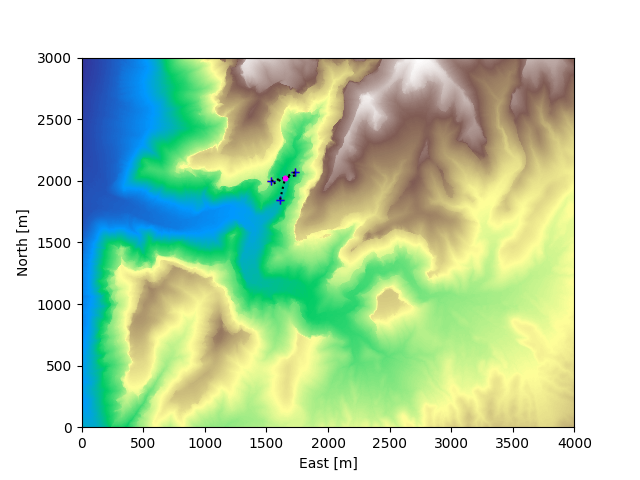

In [49]:
# plot new image locations on top of original; rays drawn from new img positions
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)

plt.plot(initial_img_0_prms['e'], initial_img_0_prms['n'], '+', color='red')
plt.plot(initial_img_1_prms['e'], initial_img_1_prms['n'], '+', color='red')
plt.plot(initial_img_2_prms['e'], initial_img_2_prms['n'], '+', color='red')

for img in imgs:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    plt.plot(posterior_mean_24[-3], posterior_mean_24[-2], '.', color='magenta')


## testing convergence

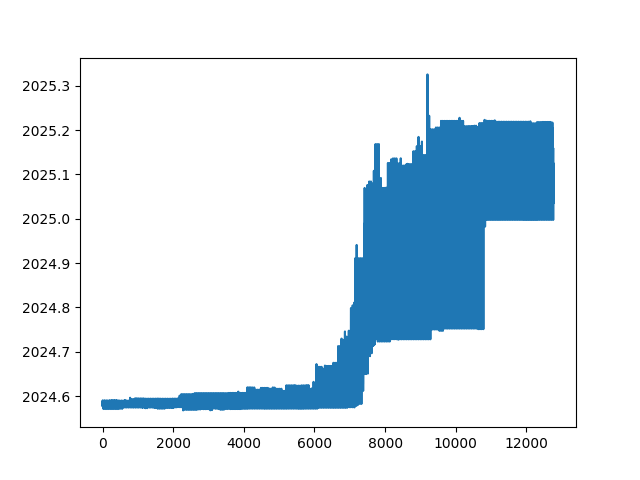

In [51]:
# examine traces
fig, ax = plt.subplots()
ax.plot(samples_24[:, -2])

TODO: decrease number of rays near the horizon. examine traces for cyclic stuff.

In [52]:
# save old masks
old_masks = np.array([img.horizon_mask for img in imgs])


In [53]:
def mess_w_px_dist(px_dist):
    for img in imgs:
        img.horizon_mask = img.mask_near_horizon(px_dist)
    pos_slvr2.total_loss(posterior_mean_24, ray_cnt=n_rays) # default n_rays


In [54]:
def mess_w_num_rays(num_rays):
    pos_slvr2.total_loss(posterior_mean_24, ray_cnt=num_rays)

In [55]:
def time_mess_w_px_dist(px_dist):   
    start = time.perf_counter()
    mess_w_px_dist(px_dist)
    end = time.perf_counter()
    # print(f"Runtime for px_dist = {px_dist}: {end - start:.6f} seconds")
    return end - start
    

In [56]:
def time_mess_w_num_rays(num_rays):   
    start = time.perf_counter()
    mess_w_num_rays(num_rays)
    end = time.perf_counter()
    # print(f"Runtime for num_rays = {num_rays}: {end - start:.6f} seconds")
    return end - start
    

In [57]:
if False:
    # testing runtime by changing num_rays
    runtimes = []
    for i in range(0, n_rays):
        runtimes.append(time_mess_w_num_rays(i))
    fix, ax = plt.subplots()
    ax.plot(runtimes)
    ax.set_title('testing runtime by changing num_rays and default px_dist')
    ax.set_ylabel('runtime')


In [58]:
if False:
    # testing runtime by changing px_dist
    runtimes = []
    for i in range(0, 150): # 0 to default px_dist
        runtimes.append(time_mess_w_px_dist(i))
    fix, ax = plt.subplots()
    ax.plot(runtimes)
    ax.set_title('testing runtime by changing px_dist and default num_rays')
    ax.set_ylabel('runtime')


i think default num_rays and 30 px_dist is a good place to start?

In [59]:
arviz.ess(samples_24[:,8])

1.5020822775320009

In [60]:
arviz.rhat(samples_24)

0.9591929798617824

In [61]:
tau = emcee.autocorr.integrated_time(samples_24, quiet=True)
print(f"Autocorrelation times: {tau}")
print(f"Mean autocorr time: {np.mean(tau):.1f} steps")


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 255;
tau: [1569.18556705]


Autocorrelation times: [1569.18556705]
Mean autocorr time: 1569.2 steps


## smaller mcmc

In [ ]:
# testing smaller mcmc: smaller ray count, default px_dist
fit_imgs = imgs
static_imgs = []
pos_slvr2 = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)
ant_pos_prior_24 = np.hstack((imgs[0].meta['best_prms'], imgs[1].meta['best_prms'], imgs[2].meta['best_prms'], result.x))
num_rays = 50

def log_probability(theta):
    log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
    log_like = pos_slvr2.total_loss(theta, num_rays) - log_prior
    return_prob = log_prior + log_like
    if np.isnan(return_prob) or np.isinf(return_prob):
        return -np.inf
    return return_prob

# Setup
ndim = 24
nwalkers = 48
total_steps = 5000
checkpoint_file = "mcmc_checkpoint_short.h5"

if False:
    if os.path.exists(checkpoint_file):
        backend = emcee.backends.HDFBackend(checkpoint_file)
        print(f"Resuming from step {backend.iteration}")
        remaining_steps = total_steps - backend.iteration
        if backend.iteration > 0:
            pos = backend.get_last_sample()
        else:
            pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
    else:
        backend = emcee.backends.HDFBackend(checkpoint_file)
        backend.reset(nwalkers, ndim)
        pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
        remaining_steps = total_steps

    from schwimmbad import MultiPool

    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability,
            pool=pool, backend=backend
        )
        sampler.run_mcmc(pos, remaining_steps, progress=True)

    # Save results
    reader = emcee.backends.HDFBackend(checkpoint_file)
    print(f'acceptance fraction: {sampler.acceptance_fraction}')
    samples_24_short = reader.get_chain(discard=1000, thin=15, flat=True)


In [63]:
if False: 
    backend = emcee.backends.HDFBackend(checkpoint_file)
    chain = backend.get_chain()  # shape: (nsteps, nwalkers, ndim)

    # Look at one parameter across all walkers
    prm_idx = 0
    fig, ax = plt.subplots()
    for i in range(nwalkers):
        ax.plot(chain[:, i, prm_idx], alpha=0.3)
    ax.set_xlabel("Step")
    ax.set_ylabel(f"Parameter {prm_idx}")
    ax.set_title("Are walkers spreading out?")

    # Check acceptance
    print(f"Acceptance fraction: {backend.accepted / backend.iteration}")

next step: implement covariance matrix, step size, and tuning

## smaller pymc

In [ ]:
# trying pymc again :| smaller num rays and px_dist

num_rays = 50

def build_model():
    with pm.Model() as model:
        pos_slvr2.set_mcmc_sigmas()
        
        # Use your existing prior array directly
        # Create a single multivariate parameter with your priors
        theta = pm.Normal(
            'theta',
            mu=ant_pos_prior_24,  # prior means
            sigma=pos_slvr2.sigmas,  # prior sigmas
            shape=24
        )
        
        # Create the wrapper for your numpy function
        loglike_op = LogLikeOp(pos_slvr2, num_rays)
        
        # Get log probability using the Op
        logp = loglike_op(theta)
        
        # Add to model
        pm.Potential("lik", logp)
        
    return model

run_name = "short_pymc"
trace_file = f"{run_name}_trace.nc"
checkpoint_file = f"{run_name}_checkpoint.nc"

if False:
    
    # Configuration
    batch_size = 10      # checkpoint every 5 draws
    target_draws = 200   # total draws (tune while sampling, discard first ~100 as burn-in)
    tune_continuously = True  # Keep adapting throughout
    
    # Check for existing checkpoint
    if os.path.exists(checkpoint_file):
        print(f"Resuming from {checkpoint_file}")
        previous_trace = arviz.from_netcdf(checkpoint_file)
        
        # Get last state
        if hasattr(previous_trace, 'posterior'):
            last_points = previous_trace.posterior.theta.values[:, -1, :]
            steps_done = previous_trace.posterior.dims['draw']
            
            if hasattr(previous_trace, 'sample_stats') and hasattr(previous_trace.sample_stats, 'scaling'):
                last_scaling = float(previous_trace.sample_stats.scaling.values[0, -1])
            else:
                last_scaling = 0.01
        else:
            print("Warning: checkpoint corrupted, starting fresh")
            last_points = None
            steps_done = 0
            last_scaling = 0.01
            
        print(f"Steps done: {steps_done}, Scaling: {last_scaling:.4f}")
    else:
        print("Starting fresh run")
        last_points = None
        steps_done = 0
        last_scaling = 0.01
    
    # Calculate what to do this batch
    remaining_steps = target_draws - steps_done
    
    if remaining_steps <= 0:
        print(f"Sampling complete! {steps_done}/{target_draws} steps done.")
    else:
        # Loop until we've done all remaining draws
        while steps_done < target_draws:
            current_sample = min(batch_size, target_draws - steps_done)
            print(f"\nSampling: {steps_done}/{target_draws} complete, doing {current_sample} more")
            print("✓ Safe to interrupt - will resume from checkpoint")
            
            # Build model and sample
            with build_model() as model:
                step = pm.Metropolis(
                    S=np.array(pos_slvr2.sigmas),
                    scaling=last_scaling,
                    tune='scaling' if tune_continuously else None,  # Keep tuning throughout
                    tune_interval=2,
                )
                
                # Initialize walkers
                if last_points is not None:
                    # Resume from checkpoint with tiny jitter
                    jitter = np.random.randn(4, 24) * 1e-6 * np.array(pos_slvr2.sigmas)
                    initvals = [{"theta": last_points[i] + jitter[i]} for i in range(4)]
                else:
                    # Start from MAP with small perturbations
                    np.random.seed(42)
                    initvals = [{"theta": ant_pos_prior_24 + np.random.randn(24) * 0.01 * np.array(pos_slvr2.sigmas)} 
                            for _ in range(4)]
                
                # Sample this batch
                trace = pm.sample(
                    draws=current_sample,
                    tune=0,  # No separate tuning phase
                    chains=4,
                    step=step,
                    cores=4,
                    initvals=initvals,
                    random_seed=42 + steps_done,
                    progressbar=True,
                    return_inferencedata=True,
                )
                
                # Concatenate with previous samples
                if last_points is not None and hasattr(previous_trace, 'posterior'):
                    print("Concatenating with previous checkpoint...")
                    trace = arviz.concat(previous_trace, trace, dim="draw")
                
                # Save checkpoint
                arviz.to_netcdf(trace, checkpoint_file)
                print(f"✓ Checkpoint saved: {checkpoint_file}")
                
                # Update state for next iteration
                steps_done += current_sample
                last_points = trace.posterior.theta.values[:, -1, :]
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'scaling'):
                    last_scaling = float(trace.sample_stats.scaling.values[0, -1])
                previous_trace = trace
                
                # Print acceptance if available
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'accepted'):
                    acc = float(trace.sample_stats.accepted.mean())
                    print(f"Acceptance rate: {acc:.3f}")
        
        # Final save
        arviz.to_netcdf(trace, trace_file)
        print(f"\n{'='*70}")
        print(f"🎉 SAMPLING COMPLETE! Final trace saved: {trace_file}")
        print(f"{'='*70}")
        print(f"Note: Discard first ~100 samples as burn-in when analyzing")


In [67]:
traces = arviz.from_netcdf(trace_file)


/var/folders/q0/wmkw3ygx6g39dcd_tv9267z40000gn/T/ipykernel_48439/4046876636.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 3))


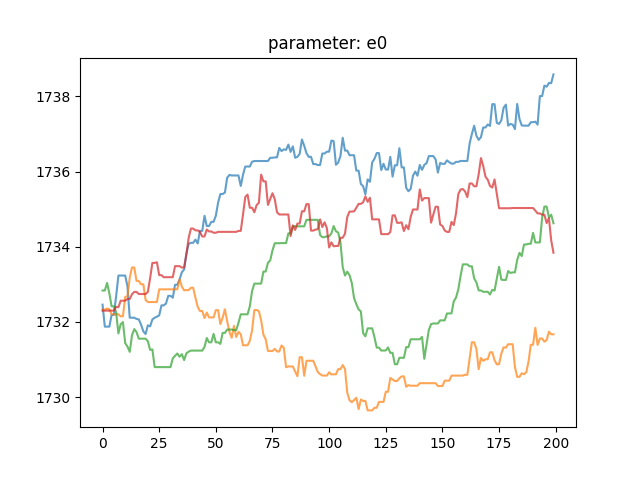

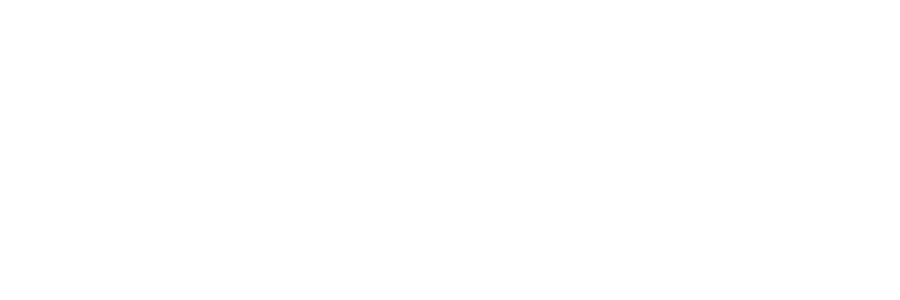

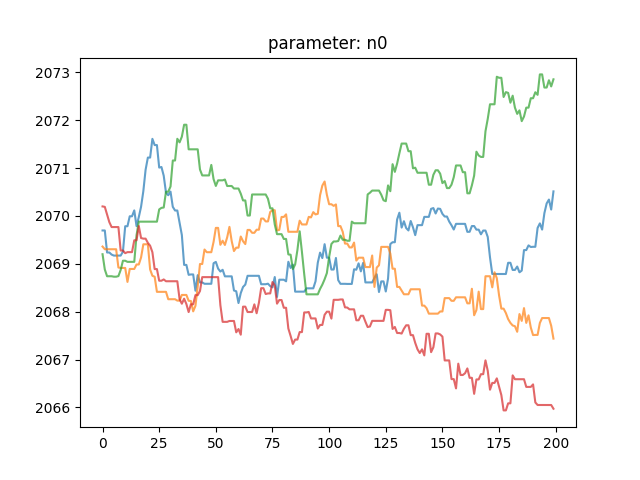

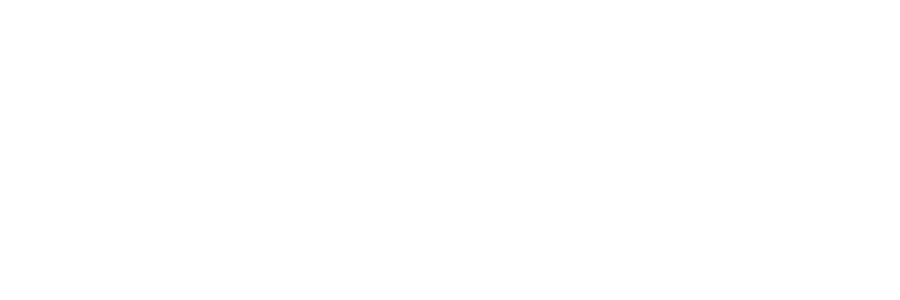

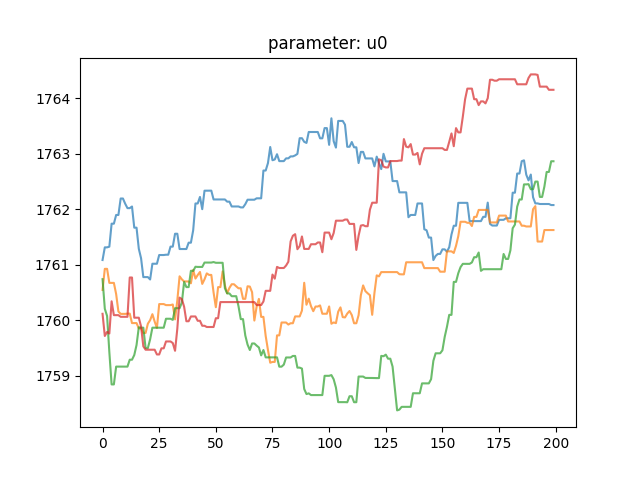

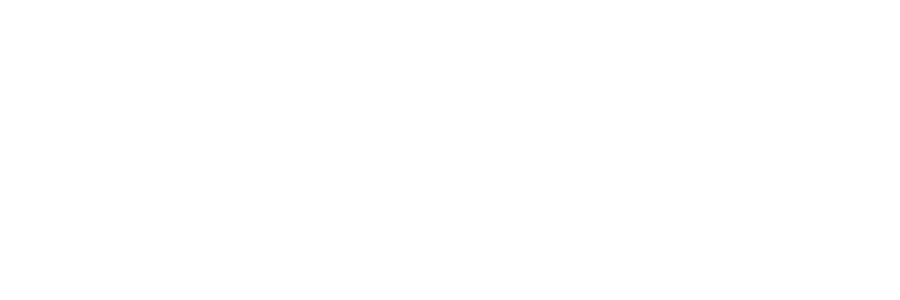

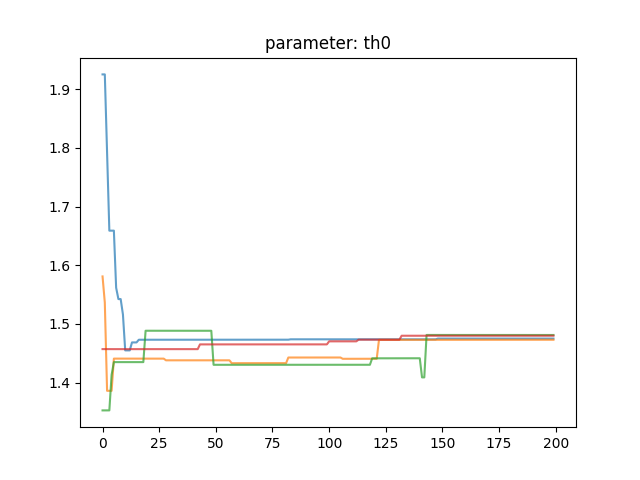

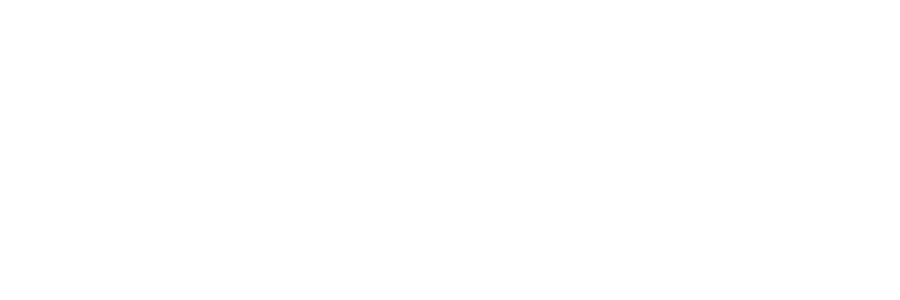

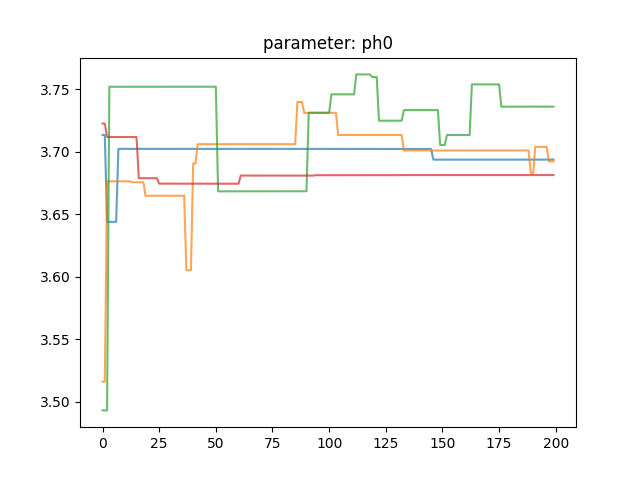

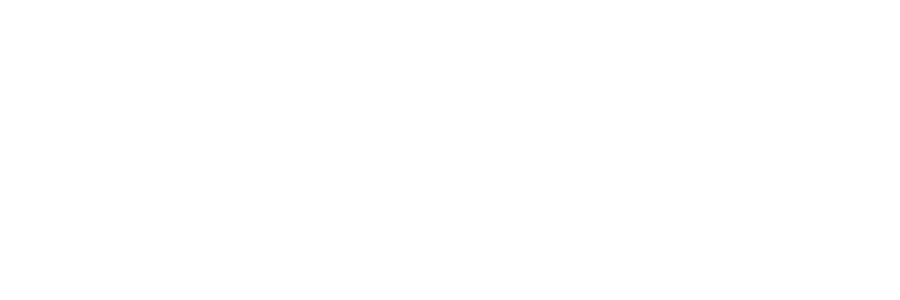

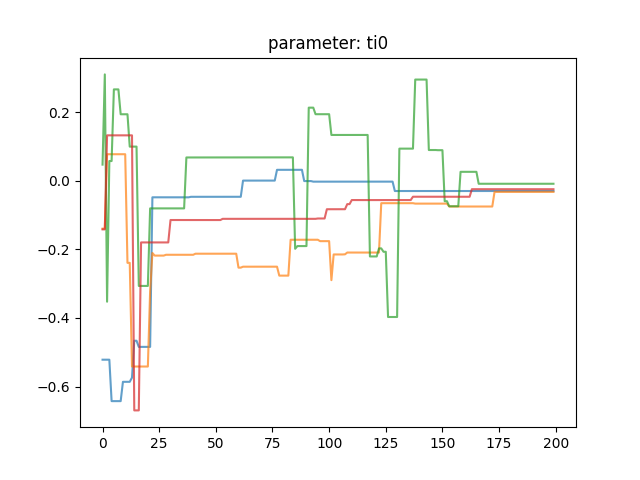

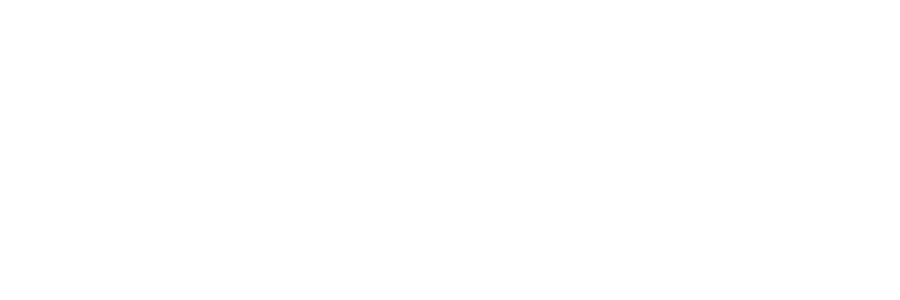

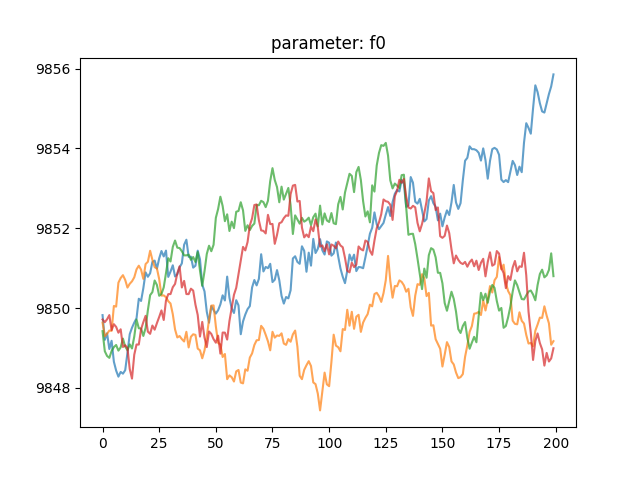

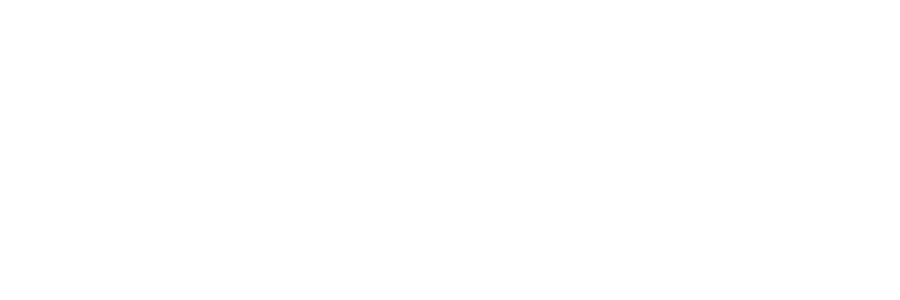

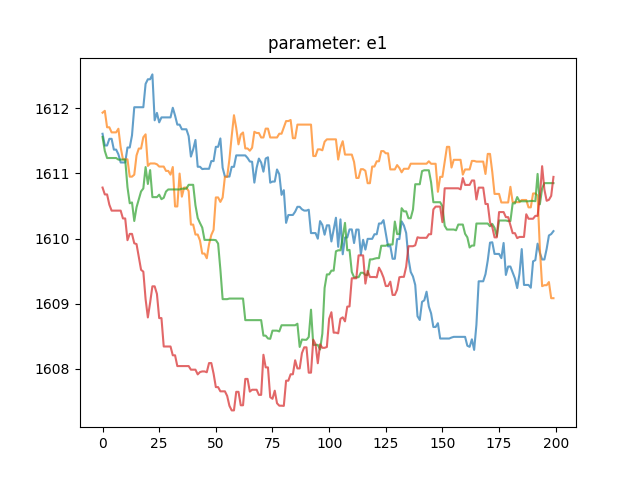

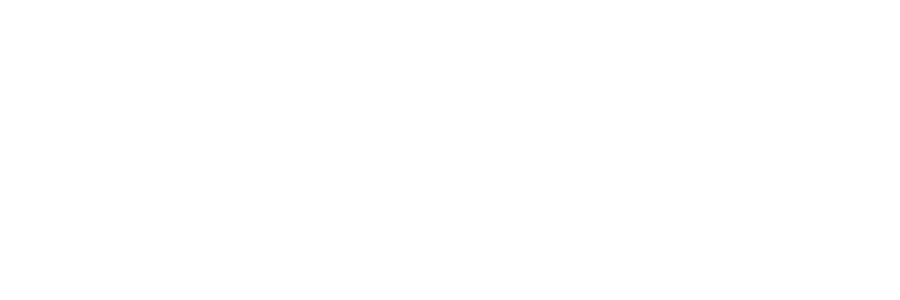

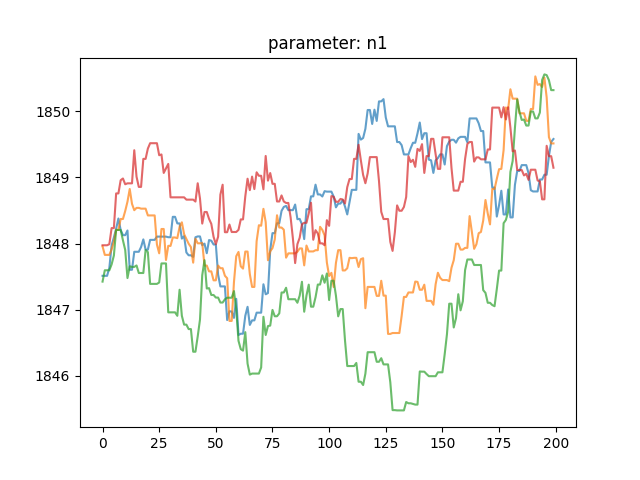

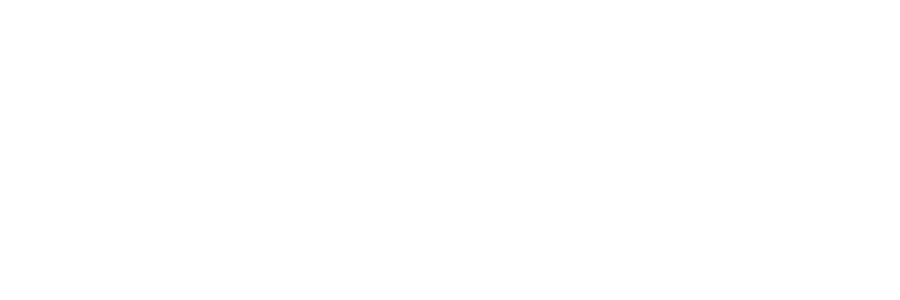

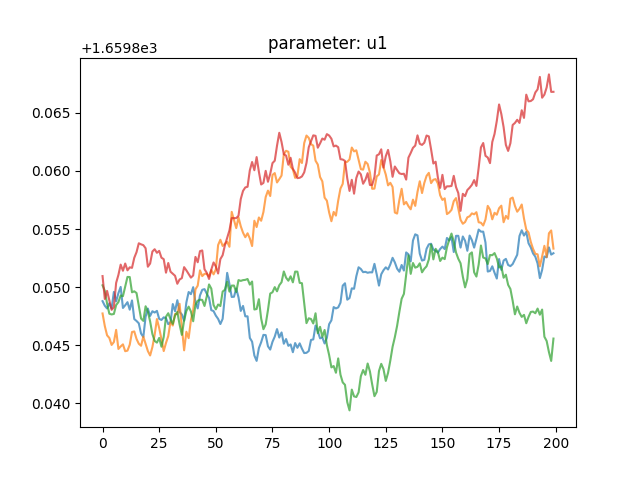

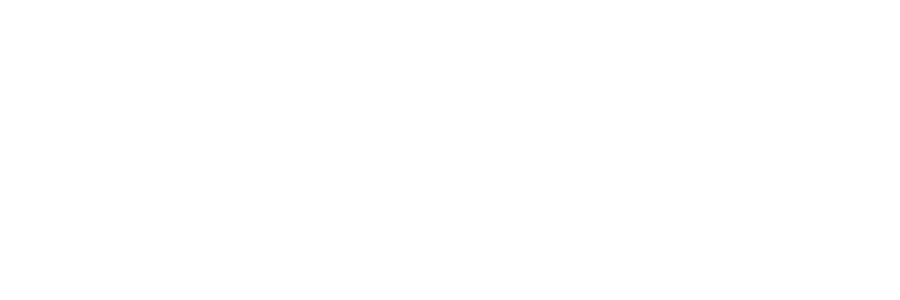

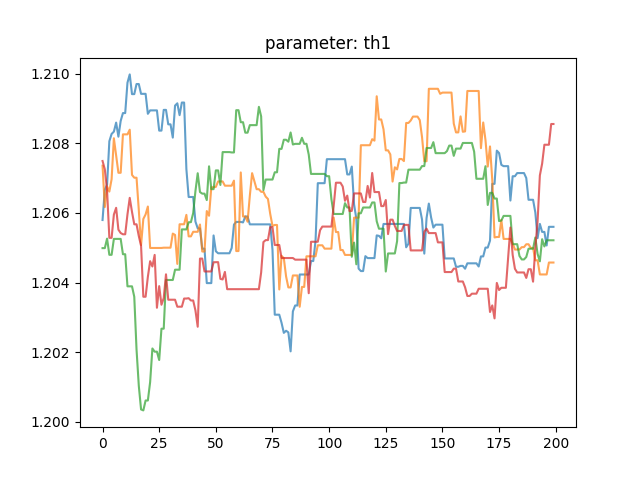

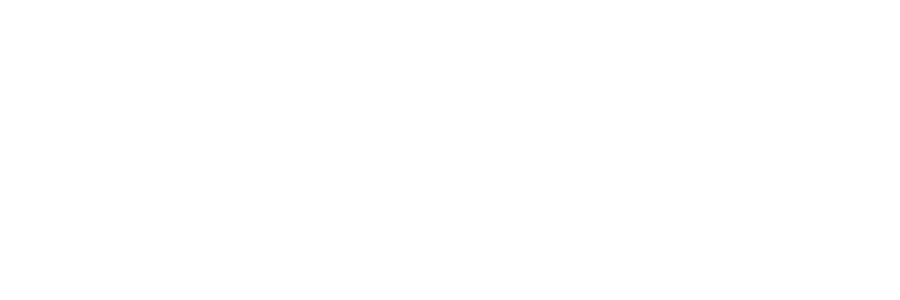

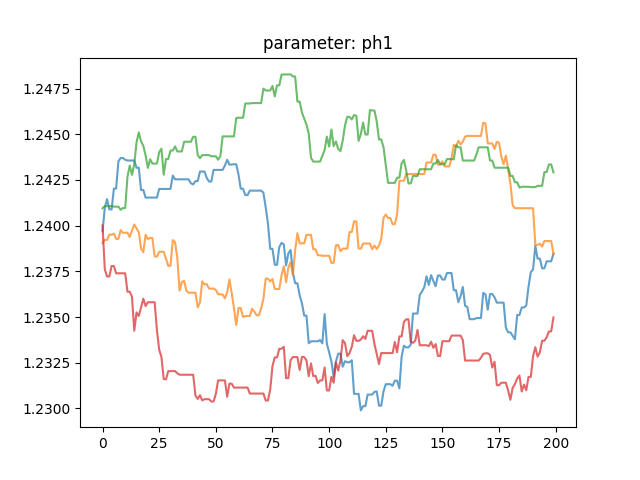

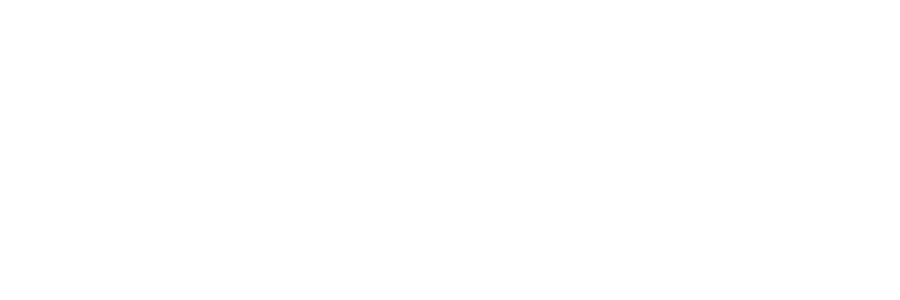

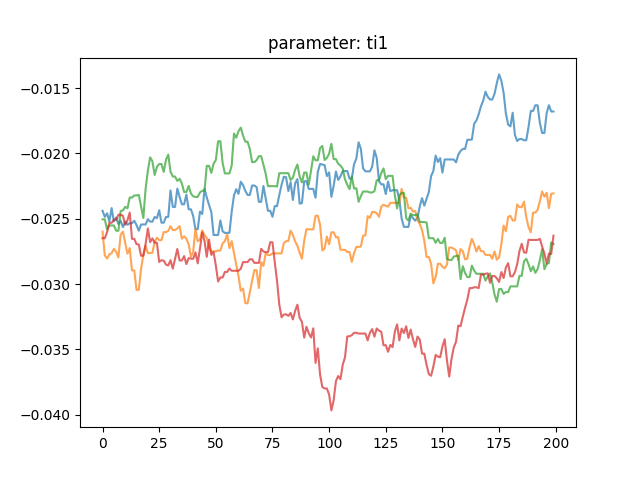

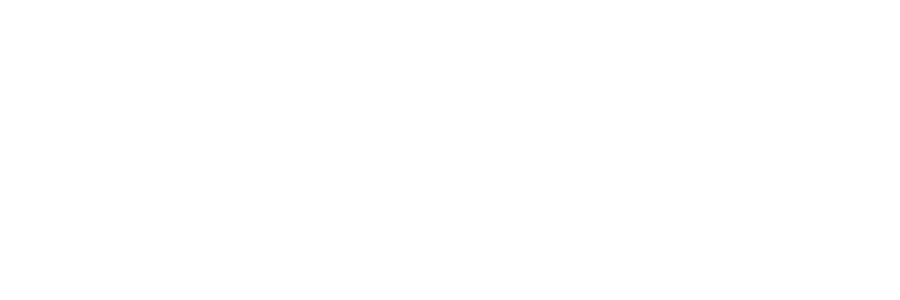

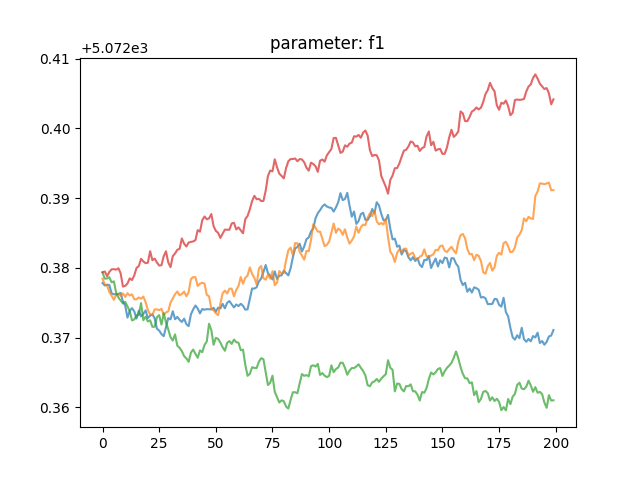

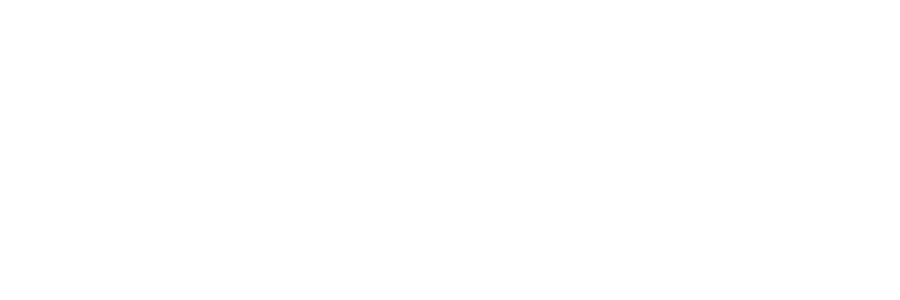

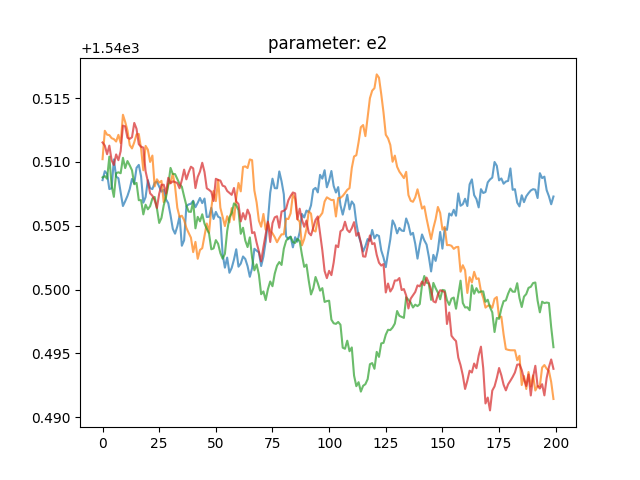

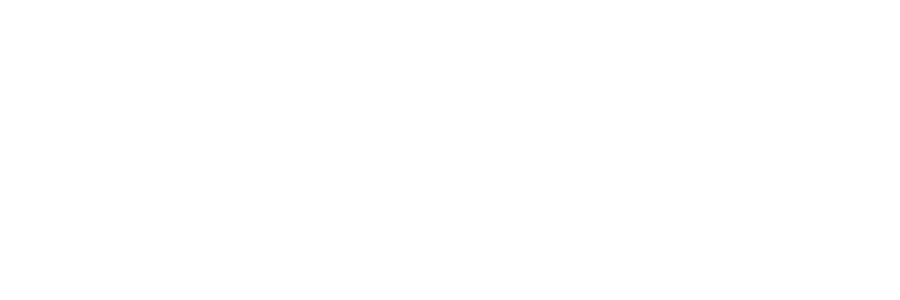

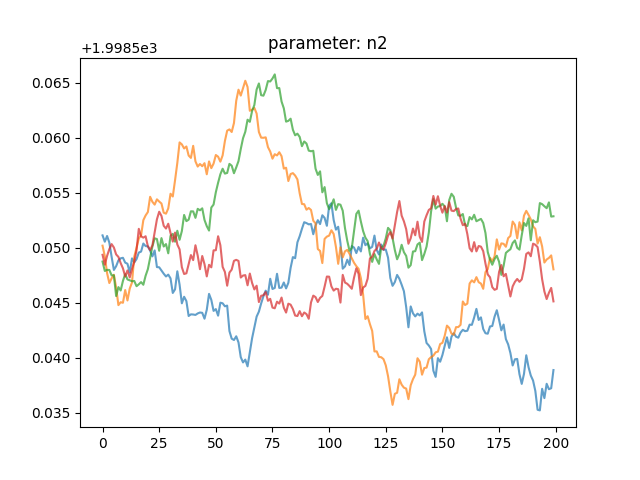

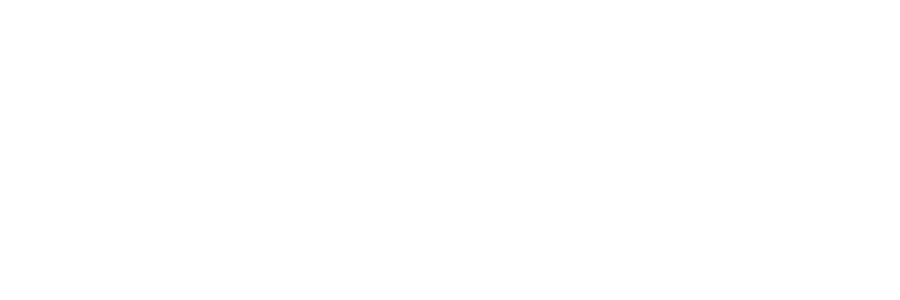

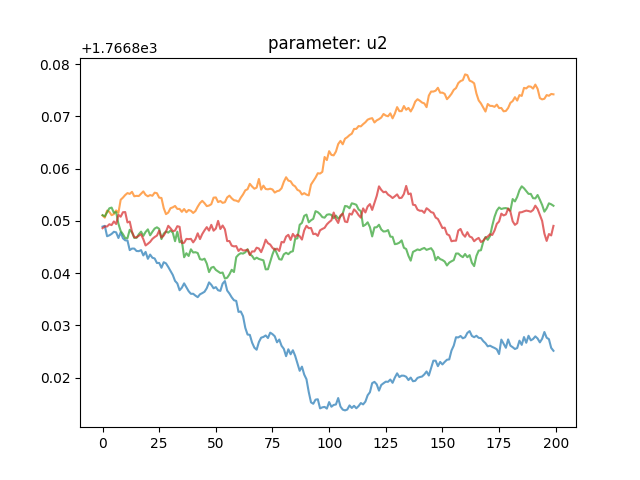

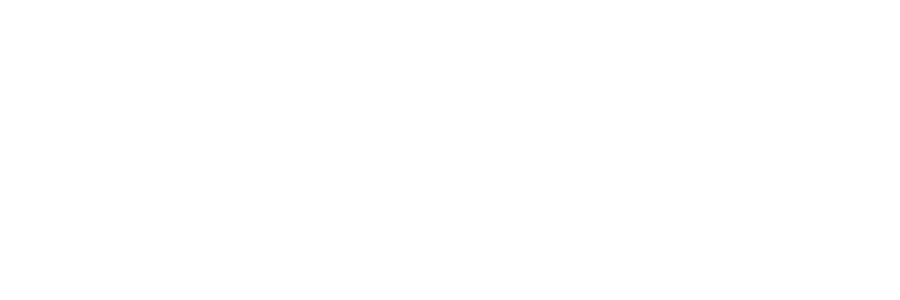

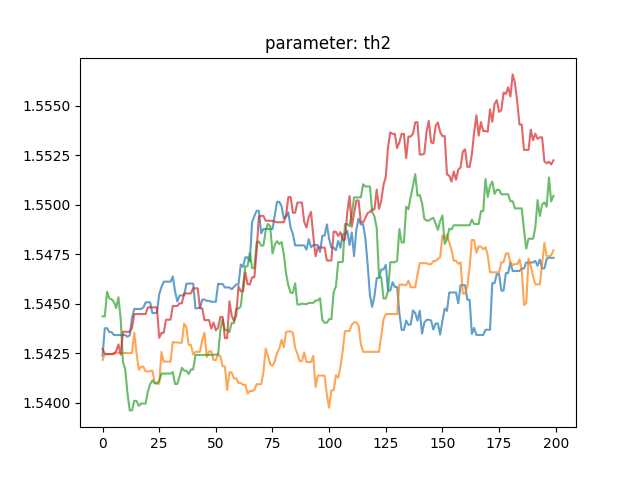

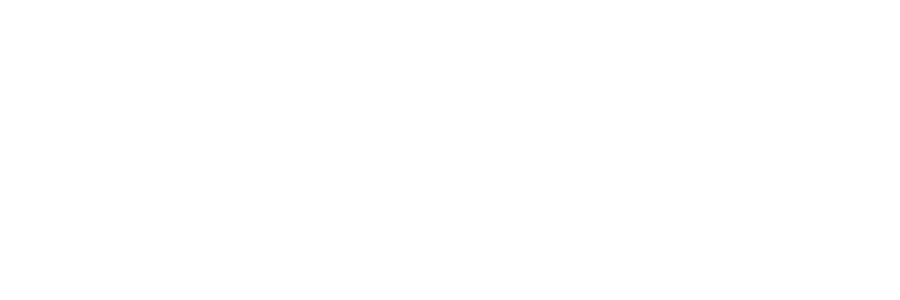

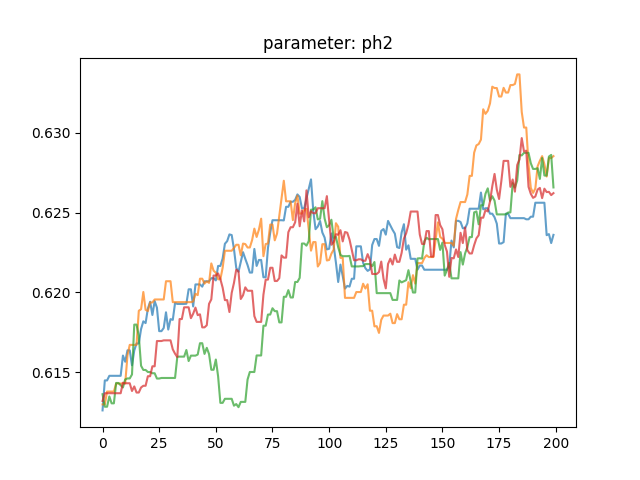

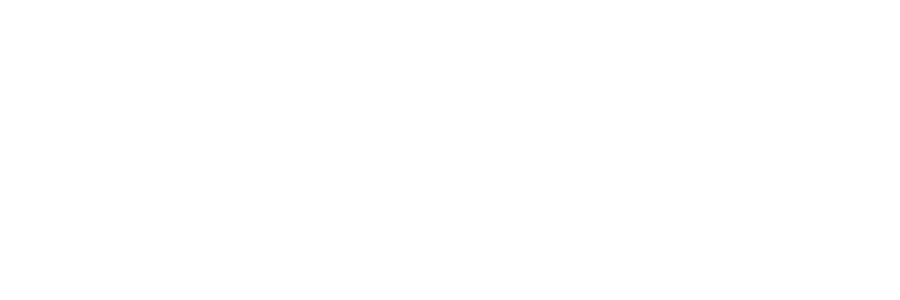

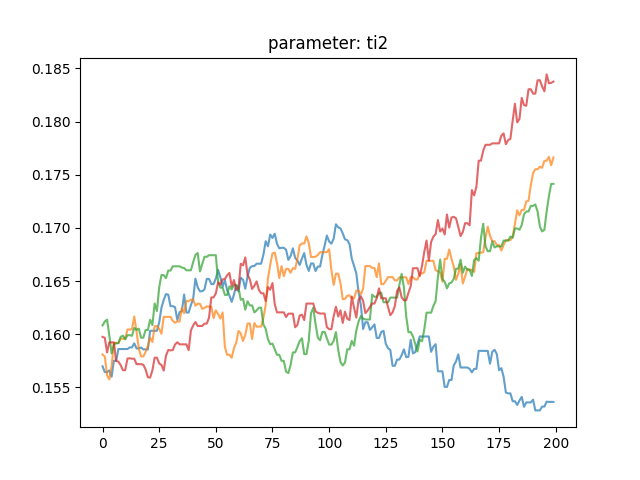

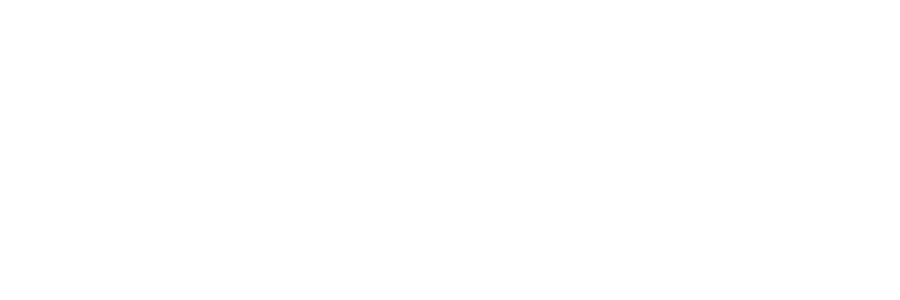

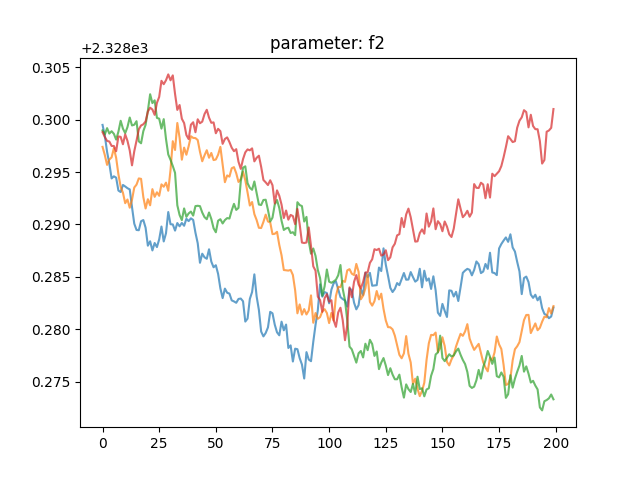

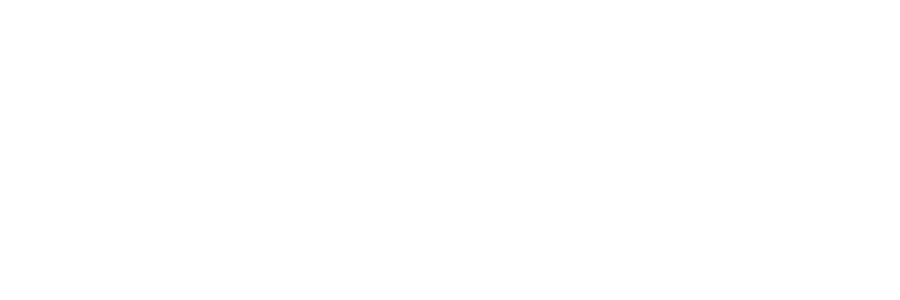

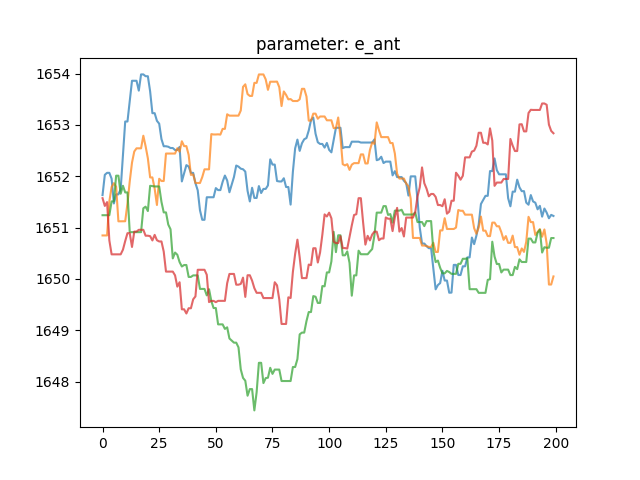

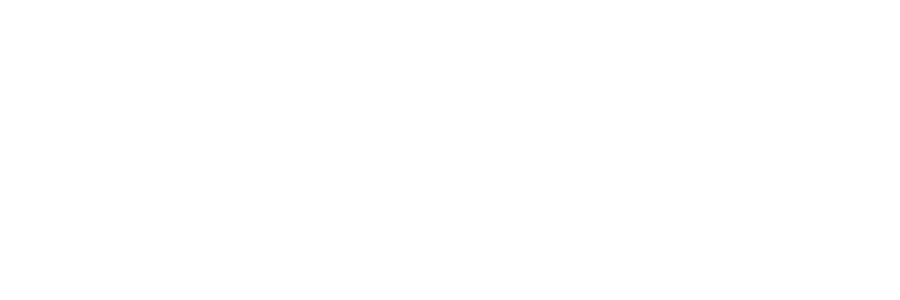

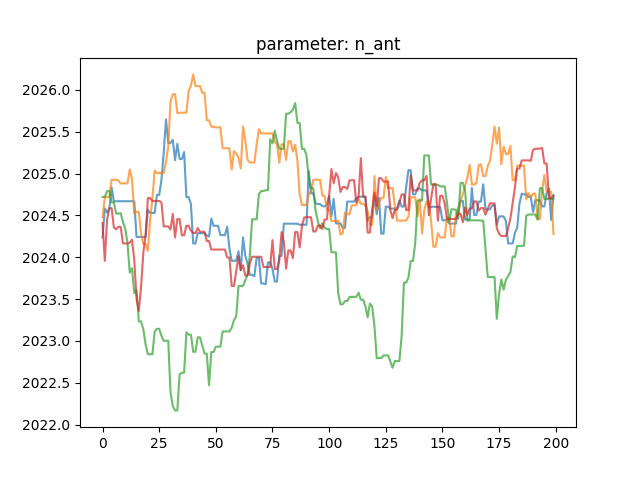

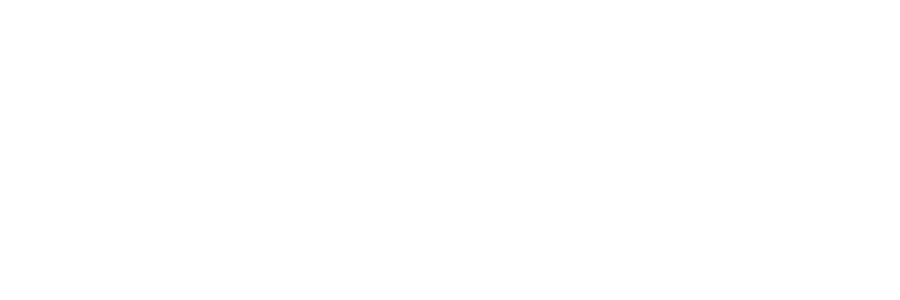

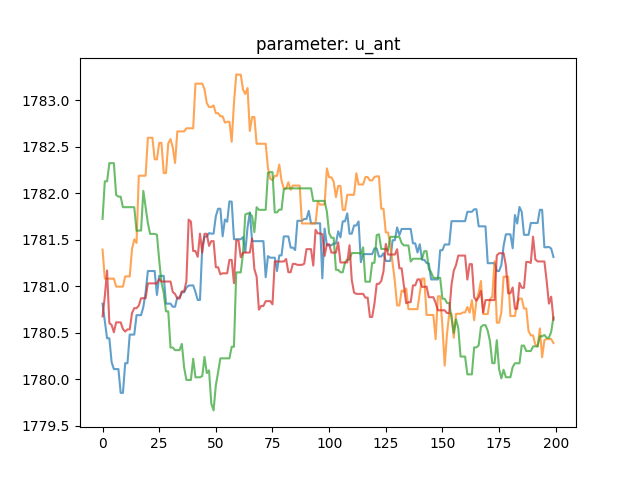

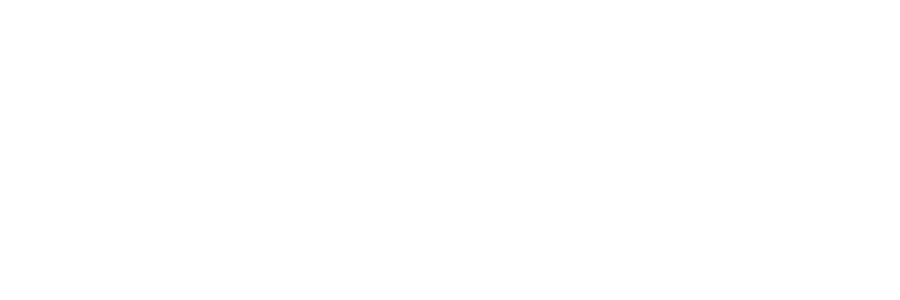

In [69]:
# plot traces

for prm_idx in range(24):
    fig, ax = plt.subplots()
    plt.figure(figsize=(9, 3))
    for chain in range(4):
        ax.plot(traces.posterior['theta'].sel(chain=chain, theta_dim_0=prm_idx), alpha=0.7, label=f'Chain {chain}')
        ax.set_title(f'parameter: {PMR_ORDER_FULL[prm_idx]}')
        

In [ ]:
summary = arviz.summary(traces, var_names=['theta'])
print(summary)


               mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]   1733.500  2.082  1729.865  1736.745      0.883    0.374       6.0   
theta[1]   2069.139  1.353  2066.051  2071.392      0.549    0.330       6.0   
theta[2]   1761.164  1.428  1758.385  1763.465      0.578    0.248       6.0   
theta[3]      1.465  0.036     1.430     1.488      0.008    0.014      14.0   
theta[4]      3.700  0.030     3.668     3.754      0.008    0.008      13.0   
theta[5]     -0.072  0.149    -0.277     0.295      0.038    0.029      12.0   
theta[6]   9850.912  1.529  9848.089  9853.365      0.513    0.224       9.0   
theta[7]   1610.156  1.138  1607.914  1611.862      0.443    0.226       7.0   
theta[8]   1848.195  1.084  1846.051  1850.064      0.361    0.190      10.0   
theta[9]   1659.853  0.006  1659.843  1659.863      0.002    0.001       7.0   
theta[10]     1.206  0.002     1.204     1.210      0.000    0.000      29.0   
theta[11]     1.239  0.005     1.230    

In [ ]:
ant_e_pymc_short = summary['mean']['theta[21]']
ant_n_pymc_short = summary['mean']['theta[22]']


In [79]:
imgs[0].set_prms(summary['mean'][:7])
imgs[1].set_prms(summary['mean'][7:14])
imgs[2].set_prms(summary['mean'][14:21])

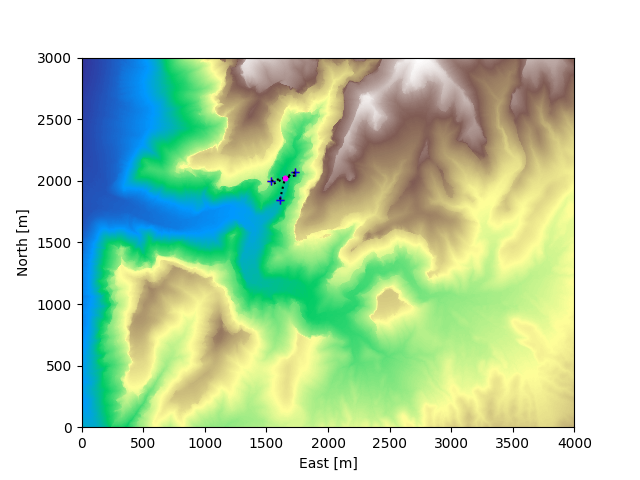

In [80]:
# plot new image locations on top of original; rays drawn from new img positions
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)

plt.plot(initial_img_0_prms['e'], initial_img_0_prms['n'], '+', color='red')
plt.plot(initial_img_1_prms['e'], initial_img_1_prms['n'], '+', color='red')
plt.plot(initial_img_2_prms['e'], initial_img_2_prms['n'], '+', color='red')

for img in imgs:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    plt.plot(ant_e_pymc_short, ant_n_pymc_short, '.', color='magenta')


## slightly larger pymc

it's all too much for little lando norris

In [82]:
# i think running for longer may help, it already is looking better than before
num_rays = 50

def build_model():
    """Build PyMC model with your numpy likelihood."""
    with pm.Model() as model:
        pos_slvr2.set_mcmc_sigmas()
        
        # Use your existing prior array directly
        # Create a single multivariate parameter with your priors
        theta = pm.Normal(
            'theta',
            mu=ant_pos_prior_24,  # your prior means
            sigma=pos_slvr2.sigmas,  # your prior sigmas
            shape=24
        )
        
        # Create the wrapper for your numpy function
        loglike_op = LogLikeOp(pos_slvr2, num_rays)
        
        # Get log probability using the Op
        logp = loglike_op(theta)
        
        # Add to model
        pm.Potential("lik", logp)
        
    return model

run_name = "slightly_larger_pymc"
trace_file = f"{run_name}_trace.nc"
checkpoint_file = f"{run_name}_checkpoint.nc"

if True:
    
    # Configuration
    batch_size = 10      # checkpoint every 5 draws
    target_draws = 500   # total draws (tune while sampling, discard first ~100 as burn-in)
    tune_continuously = True  # Keep adapting throughout
    
    # Check for existing checkpoint
    if os.path.exists(checkpoint_file):
        print(f"Resuming from {checkpoint_file}")
        previous_trace = arviz.from_netcdf(checkpoint_file)
        
        # Get last state
        if hasattr(previous_trace, 'posterior'):
            last_points = previous_trace.posterior.theta.values[:, -1, :]
            steps_done = previous_trace.posterior.dims['draw']
            
            if hasattr(previous_trace, 'sample_stats') and hasattr(previous_trace.sample_stats, 'scaling'):
                last_scaling = float(previous_trace.sample_stats.scaling.values[0, -1])
            else:
                last_scaling = 0.01
        else:
            print("Warning: checkpoint corrupted, starting fresh")
            last_points = None
            steps_done = 0
            last_scaling = 0.01
            
        print(f"Steps done: {steps_done}, Scaling: {last_scaling:.4f}")
    else:
        print("Starting fresh run")
        last_points = None
        steps_done = 0
        last_scaling = 0.01
    
    # Calculate what to do this batch
    remaining_steps = target_draws - steps_done
    
    if remaining_steps <= 0:
        print(f"Sampling complete! {steps_done}/{target_draws} steps done.")
    else:
        # Loop until we've done all remaining draws
        while steps_done < target_draws:
            current_sample = min(batch_size, target_draws - steps_done)
            print(f"\nSampling: {steps_done}/{target_draws} complete, doing {current_sample} more")
            print("✓ Safe to interrupt - will resume from checkpoint")
            
            # Build model and sample
            with build_model() as model:
                step = pm.Metropolis(
                    S=np.array(pos_slvr2.sigmas),
                    scaling=last_scaling,
                    tune='scaling' if tune_continuously else None,  # Keep tuning throughout
                    tune_interval=2,
                )
                
                # Initialize walkers
                if last_points is not None:
                    # Resume from checkpoint with tiny jitter
                    jitter = np.random.randn(4, 24) * 1e-6 * np.array(pos_slvr2.sigmas)
                    initvals = [{"theta": last_points[i] + jitter[i]} for i in range(4)]
                else:
                    # Start from MAP with small perturbations
                    np.random.seed(42)
                    initvals = [{"theta": ant_pos_prior_24 + np.random.randn(24) * 0.01 * np.array(pos_slvr2.sigmas)} 
                            for _ in range(4)]
                
                # Sample this batch
                trace = pm.sample(
                    draws=current_sample,
                    tune=0,  # No separate tuning phase
                    chains=4,
                    step=step,
                    cores=4,
                    initvals=initvals,
                    random_seed=42 + steps_done,
                    progressbar=True,
                    return_inferencedata=True,
                )
                
                # Concatenate with previous samples
                if last_points is not None and hasattr(previous_trace, 'posterior'):
                    print("Concatenating with previous checkpoint...")
                    trace = arviz.concat(previous_trace, trace, dim="draw")
                
                # Save checkpoint
                arviz.to_netcdf(trace, checkpoint_file)
                print(f"✓ Checkpoint saved: {checkpoint_file}")
                
                # Update state for next iteration
                steps_done += current_sample
                last_points = trace.posterior.theta.values[:, -1, :]
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'scaling'):
                    last_scaling = float(trace.sample_stats.scaling.values[0, -1])
                previous_trace = trace
                
                # Print acceptance if available
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'accepted'):
                    acc = float(trace.sample_stats.accepted.mean())
                    print(f"Acceptance rate: {acc:.3f}")
        
        # Final save
        arviz.to_netcdf(trace, trace_file)
        print(f"\n{'='*70}")
        print(f"🎉 SAMPLING COMPLETE! Final trace saved: {trace_file}")
        print(f"{'='*70}")
        print(f"Note: Discard first ~100 samples as burn-in when analyzing")


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Starting fresh run

Sampling: 0/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.46,  2069.69,   1761.08,  1.9251,  3.6261, -0.1223,  9849.83),  #[LOSS= 0.6600]'best_prms': ( 1732.15,  2069.76,   1760.54,  1.5809,  3.5161, -0.1396,  9849.18),  #[LOSS= 0.6600]

'best_prms': ( 1732.41,  2069.20,   1760.99,  1.3527,  3.4932,  0.1314,  9849.67),  #[LOSS= 0.3400]
'best_prms': ( 1732.30,  2070.20,   1760.10,  1.7148,  3.7224, -0.1418,  9849.39),  #[LOSS= 0.6600]


'best_prms': ( 1611.61,  1847.48,   1659.85,  1.2058,  1.2397, -0.0248,  5072.38),  #[LOSS= 0.0200]
'best_prms': ( 1611.66,  1847.37,   1659.85,  1.2065,  1.2410, -0.0254,  5072.38),  #[LOSS= 0.0400]
'best_prms': ( 1610.78,  1847.55,   1659.85,  1.2075,  1.2396, -0.0257,  5072.38),  #[LOSS= 0.0200]
'best_prms': ( 1611.94,  1847.62,   1659.85,  1.2069,  1.2390, -0.0248,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5424,  0.6122,  0.1570,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5433,  0.6136,  0.1594,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5425,  0.6132,  0.1598,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5422,  0.6130,  0.1581,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1610.78,  1847.55,   1659.85,  1.2075,  1.2400, -0.0257,  5072.38),  #[LOSS= 0.0000]


'best_prms': ( 1732.30,  2070.20,   1760.11,  1.4571,  3.7224, -0.1418,  9849.71),  #[LOSS= 0.3600]


'best_prms': ( 1732.33,  2069.36,   1760.54,  1.5809,  3.5161,  0.1409,  9849.64),  #[LOSS= 0.6400]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1611.93,  1847.96,   1659.85,  1.2074,  1.2406, -0.0260,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1611.21,  1847.42,   1659.85,  1.2050,  1.2410, -0.0250,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1732.83,  2069.20,   1760.24,  1.3527,  3.4932,  0.1692,  9849.19),  #[LOSS= 0.3000]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1732.25,  2069.97,   1759.62,  1.4571,  3.7224,  0.0419,  9849.14),  #[LOSS= 0.2800]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1731.98,  2069.70,   1761.28,  1.5532,  3.6669, -0.5252,  9849.59),  #[LOSS= 0.6000]


'best_prms': ( 1733.17,  2068.05,   1761.36,  1.5784,  4.0931, -0.6072,  9849.28),  #[LOSS= 0.6000]


'best_prms': ( 1732.53,  2069.71,   1761.81,  1.5532,  3.7074, -0.5252,  9849.80),  #[LOSS= 0.5200]


'best_prms': ( 1732.53,  2070.02,   1761.81,  1.4833,  3.7074, -0.5252,  9849.58),  #[LOSS= 0.4000]


'best_prms': ( 1733.39,  2067.37,   1761.36,  1.3830,  3.6146, -0.9332,  9848.82),  #[LOSS= 0.3400]


'best_prms': ( 1611.75,  1848.03,   1659.85,  1.2067,  1.2406, -0.0273,  5072.38),  #[LOSS= 0.0000]


'best_prms': ( 1732.82,  2067.02,   1761.36,  1.4092,  3.6146, -0.1804,  9848.25),  #[LOSS= 0.3200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 2773 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.642

Sampling: 10/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.23,  2069.09,   1759.97,  1.3526,  3.3907,  0.2167,  9849.64),  #[LOSS= 0.3400]
'best_prms': ( 1732.54,  2069.31,   1759.83,  1.4571,  3.7224,  0.0419,  9849.79),  #[LOSS= 0.2600]
'best_prms': ( 1732.82,  2067.02,   1761.36,  1.4444,  3.6146, -0.1803,  9848.52),  #[LOSS= 0.3800]
'best_prms': ( 1731.93,  2070.02,   1761.34,  1.4833,  3.7074, -0.5252,  9849.04),  #[LOSS= 0.4200]


'best_prms': ( 1611.44,  1847.61,   1659.85,  1.2078,  1.2412, -0.0273,  5072.38),  #[LOSS= 0.0600]'best_prms': ( 1611.75,  1848.06,   1659.85,  1.2067,  1.2406, -0.0271,  5072.38),  #[LOSS= 0.0600]'best_prms': ( 1610.22,  1847.74,   1659.85,  1.2076,  1.2399, -0.0255,  5072.38),  #[LOSS= 0.0800]'best_prms': ( 1611.21,  1847.62,   1659.85,  1.2051,  1.2410, -0.0272,  5072.38),  #[LOSS= 0.0800]





'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5453,  0.6167,  0.1612,  2328.30),  #[LOSS= 0.0600]'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5475,  0.6157,  0.1593,  2328.30),  #[LOSS= 0.0600]

'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5437,  0.6138,  0.1580,  2328.30),  #[LOSS= 0.0400]
'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5457,  0.6134,  0.1609,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1732.32,  2069.31,   1759.83,  1.4571,  3.7224,  0.0419,  9849.79),  #[LOSS= 0.2200]


'best_prms': ( 1610.22,  1847.74,   1659.85,  1.2076,  1.2396, -0.0255,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1732.82,  2067.02,   1761.73,  1.4444,  3.6146, -0.1803,  9848.52),  #[LOSS= 0.3600]


'best_prms': ( 1732.32,  2069.31,   1759.36,  1.4571,  3.7224,  0.0419,  9849.79),  #[LOSS= 0.2000]


'best_prms': ( 1731.93,  2070.04,   1761.22,  1.4833,  3.7074, -0.0944,  9848.71),  #[LOSS= 0.3000]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5454,  0.6181,  0.1614,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1731.93,  2069.88,   1761.22,  1.4833,  3.7074, -0.0944,  9848.71),  #[LOSS= 0.2800]


'best_prms': ( 1732.82,  2066.46,   1761.73,  1.4444,  3.6146, -0.1803,  9848.90),  #[LOSS= 0.3400]


'best_prms': ( 1610.75,  1847.62,   1659.84,  1.2066,  1.2413, -0.0267,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1732.82,  2066.46,   1761.73,  1.4444,  3.6322, -0.1803,  9848.90),  #[LOSS= 0.3200]


'best_prms': ( 1732.82,  2066.46,   1761.42,  1.4444,  3.6322, -0.1803,  9848.90),  #[LOSS= 0.3000]


'best_prms': ( 1732.32,  2069.05,   1759.22,  1.4571,  3.7224,  0.0419,  9850.15),  #[LOSS= 0.1800]


'best_prms': ( 1732.89,  2065.99,   1761.16,  1.4444,  3.6322, -0.0302,  9848.68),  #[LOSS= 0.2200]


'best_prms': ( 1611.09,  1847.06,   1659.85,  1.2089,  1.2437, -0.0280,  5072.38),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 1542 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.667

Sampling: 20/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1733.29,  2065.84,   1761.66,  1.4444,  3.6323, -0.0302,  9849.16),  #[LOSS= 0.3200]'best_prms': ( 1732.47,  2069.51,   1761.52,  1.4833,  3.7073, -0.1597,  9849.84),  #[LOSS= 0.5200]

'best_prms': ( 1732.07,  2069.08,   1759.20,  1.4570,  3.7224,  0.0419,  9849.17),  #[LOSS= 0.2800]

'best_prms': ( 1610.64,  1848.66,   1659.85,  1.2085,  1.2409, -0.0276,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1611.10,  1846.84,   1659.85,  1.2097,  1.2444, -0.0286,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1611.05,  1846.99,   1659.84,  1.2055,  1.2431, -0.0246,  5072.38),  #[LOSS= 0.0600]



'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5484,  0.6164,  0.1624,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5465,  0.6138,  0.1609,  2328.30),  #[LOSS= 0.0400]
'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5434,  0.6153,  0.1594,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5456,  0.6167,  0.1595,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1610.64,  1848.66,   1659.85,  1.2085,  1.2403, -0.0285,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1732.47,  2069.51,   1761.52,  1.2647,  3.7073, -0.1597,  9849.84),  #[LOSS= 0.3600]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5462,  0.6159,  0.1595,  2328.30),  #[LOSS= 0.0400]

'best_prms': ( 1733.29,  2065.78,   1761.80,  1.4444,  3.6323, -0.0302,  9849.34),  #[LOSS= 0.3000]

'best_prms': ( 1731.84,  2067.03,   1759.78,  1.3610,  3.4724,  0.4702,  9850.33),  #[LOSS= 0.3400]


'best_prms': ( 1731.47,  2066.83,   1760.16,  1.3610,  3.6173,  0.6636,  9850.46),  #[LOSS= 0.3200]


'best_prms': ( 1732.13,  2069.35,   1759.31,  1.4570,  3.7224,  0.0419,  9849.55),  #[LOSS= 0.2600]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5409,  0.6163,  0.1604,  2328.29),  #[LOSS= 0.0000]


'best_prms': ( 1733.33,  2065.78,   1762.22,  1.4444,  3.6323, -0.0302,  9848.83),  #[LOSS= 0.2400]


'best_prms': ( 1610.82,  1846.42,   1659.85,  1.2122,  1.2443, -0.0278,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1731.50,  2066.72,   1760.43,  1.3610,  3.6271,  0.6055,  9850.91),  #[LOSS= 0.3000]


'best_prms': ( 1732.09,  2068.54,   1762.41,  1.4833,  3.7624,  0.1314,  9850.66),  #[LOSS= 0.3400]


'best_prms': ( 1731.57,  2066.33,   1760.70,  1.3610,  3.5513,  0.6055,  9850.10),  #[LOSS= 0.2800]


'best_prms': ( 1731.57,  2066.02,   1760.96,  1.4431,  3.7448,  0.6055,  9849.97),  #[LOSS= 0.2600]


'best_prms': ( 1611.77,  1844.95,   1659.84,  1.2065,  1.2429, -0.0229,  5072.38),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 6647 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.670

Sampling: 30/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1734.61,  2065.78,   1762.20,  1.4444,  3.6323, -0.0302,  9849.81),  #[LOSS= 0.3600]


'best_prms': ( 1731.56,  2066.02,   1760.96,  1.4431,  3.7447,  0.6056,  9849.93),  #[LOSS= 0.4800]'best_prms': ( 1731.65,  2069.14,   1762.58,  1.4832,  3.7623,  0.1315,  9850.19),  #[LOSS= 0.3600]'best_prms': ( 1732.31,  2069.50,   1759.82,  1.4570,  3.2990,  0.0419,  9850.47),  #[LOSS= 0.4000]




'best_prms': ( 1610.36,  1847.69,   1659.85,  1.2066,  1.2414, -0.0258,  5072.38),  #[LOSS= 0.0400]
'best_prms': ( 1609.26,  1848.70,   1659.85,  1.2072,  1.2367, -0.0183,  5072.37),  #[LOSS= 0.0800]'best_prms': ( 1611.75,  1844.95,   1659.84,  1.2065,  1.2429, -0.0229,  5072.38),  #[LOSS= 0.0400]

'best_prms': ( 1610.65,  1847.16,   1659.85,  1.2119,  1.2431, -0.0273,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.56,   1766.85,  1.5493,  0.6181,  0.1631,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5471,  0.6119,  0.1610,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.54,   1766.85,  1.5415,  0.6196,  0.1643,  2328.29),  #[LOSS= 0.0200]
'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5476,  0.6166,  0.1624,  2328.30),  #[LOSS= 0.0600]

'best_prms': ( 1732.31,  2069.50,   1759.82,  1.4570,  3.7224,  0.0419,  9850.47),  #[LOSS= 0.3600]


'best_prms': ( 1540.50,  1998.54,   1766.85,  1.5415,  0.6196,  0.1634,  2328.29),  #[LOSS= 0.0000]


'best_prms': ( 1734.74,  2065.78,   1761.95,  1.4444,  3.6323, -0.0302,  9849.50),  #[LOSS= 0.3400]


'best_prms': ( 1734.74,  2065.78,   1761.95,  1.4444,  3.6323,  0.0506,  9849.50),  #[LOSS= 0.3200]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5476,  0.6188,  0.1628,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1731.00,  2069.14,   1762.58,  1.4832,  3.7623,  0.0503,  9850.15),  #[LOSS= 0.2800]


'best_prms': ( 1731.00,  2069.34,   1762.58,  1.4832,  3.7623,  0.0503,  9849.64),  #[LOSS= 0.2600]


'best_prms': ( 1731.12,  2069.34,   1762.58,  1.4832,  3.7623,  0.0503,  9849.64),  #[LOSS= 0.2400]


'best_prms': ( 1731.89,  2066.02,   1760.97,  1.5901,  3.7447,  0.6056,  9850.25),  #[LOSS= 0.4600]


'best_prms': ( 1610.58,  1846.99,   1659.85,  1.2114,  1.2428, -0.0273,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5466,  0.6201,  0.1630,  2328.30),  #[LOSS= 0.0200]


'best_prms': ( 1731.89,  2066.02,   1761.34,  1.5145,  3.7447,  0.2292,  9849.49),  #[LOSS= 0.4000]


'best_prms': ( 1609.53,  1849.68,   1659.85,  1.2074,  1.2382, -0.0183,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1610.49,  1847.10,   1659.85,  1.2091,  1.2436, -0.0257,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1609.55,  1849.78,   1659.85,  1.2062,  1.2382, -0.0185,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5489,  0.6214,  0.1626,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1733.45,  2069.89,   1759.83,  1.4570,  3.7002, -0.0529,  9851.57),  #[LOSS= 0.2400]


'best_prms': ( 1540.51,  1998.55,   1766.86,  1.5480,  0.6226,  0.1625,  2328.30),  #[LOSS= 0.0200]


'best_prms': ( 1732.01,  2066.30,   1761.92,  1.5145,  3.7127,  0.2292,  9849.35),  #[LOSS= 0.3800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 390 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.666

Sampling: 40/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1736.00,  2065.21,   1762.29,  1.4444,  3.6323,  0.0507,  9849.82),  #[LOSS= 0.3600]
'best_prms': ( 1732.06,  2066.30,   1761.92,  1.5145,  3.7128,  0.2291,  9849.07),  #[LOSS= 0.4200]
'best_prms': ( 1731.20,  2069.55,   1762.65,  1.4833,  3.7624,  0.0498,  9848.51),  #[LOSS= 0.3400]
'best_prms': ( 1733.81,  2068.94,   1760.21,  1.4570,  3.7002, -0.0529,  9851.62),  #[LOSS= 0.3200]


'best_prms': ( 1610.02,  1848.48,   1659.85,  1.2046,  1.2406, -0.0249,  5072.38),  #[LOSS= 0.1000]
'best_prms': ( 1610.87,  1845.49,   1659.84,  1.2044,  1.2443, -0.0218,  5072.38),  #[LOSS= 0.1000]
'best_prms': ( 1609.90,  1846.61,   1659.85,  1.2105,  1.2423, -0.0257,  5072.38),  #[LOSS= 0.1600]
'best_prms': ( 1609.29,  1849.33,   1659.85,  1.2062,  1.2388, -0.0195,  5072.37),  #[LOSS= 0.1600]


'best_prms': ( 1540.51,  1998.55,   1766.86,  1.5474,  0.6226,  0.1619,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.54,   1766.85,  1.5411,  0.6185,  0.1642,  2328.29),  #[LOSS= 0.0400]'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5468,  0.6202,  0.1627,  2328.30),  #[LOSS= 0.0600]

'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5492,  0.6136,  0.1613,  2328.30),  #[LOSS= 0.1000]


'best_prms': ( 1730.43,  2069.55,   1762.65,  1.4833,  3.7624,  0.0498,  9848.51),  #[LOSS= 0.3200]


'best_prms': ( 1610.02,  1848.48,   1659.85,  1.2046,  1.2415, -0.0249,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1609.40,  1849.33,   1659.85,  1.2062,  1.2388, -0.0195,  5072.37),  #[LOSS= 0.1400]


'best_prms': ( 1609.90,  1846.61,   1659.85,  1.2105,  1.2423, -0.0253,  5072.38),  #[LOSS= 0.1400]


'best_prms': ( 1609.40,  1849.33,   1659.85,  1.2062,  1.2392, -0.0207,  5072.37),  #[LOSS= 0.1200]


'best_prms': ( 1609.93,  1846.81,   1659.85,  1.2109,  1.2443, -0.0253,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1610.88,  1845.44,   1659.84,  1.2033,  1.2450, -0.0217,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1736.02,  2065.21,   1762.17,  1.4444,  3.8111, -0.1262,  9850.09),  #[LOSS= 0.3400]


'best_prms': ( 1732.65,  2066.46,   1762.12,  1.5145,  3.7128,  0.4669,  9848.60),  #[LOSS= 0.4000]


'best_prms': ( 1609.90,  1846.81,   1659.85,  1.2080,  1.2443, -0.0249,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1730.41,  2070.53,   1762.47,  1.4833,  3.7624,  0.0459,  9848.21),  #[LOSS= 0.3000]

'best_prms': ( 1736.00,  2065.35,   1762.17,  1.4879,  3.6323, -0.2187,  9849.77),  #[LOSS= 0.3000]


'best_prms': ( 1734.62,  2068.81,   1759.90,  1.4570,  3.7002, -0.0529,  9851.44),  #[LOSS= 0.3000]


'best_prms': ( 1735.08,  2065.35,   1762.56,  1.4879,  3.6323, -0.2187,  9849.77),  #[LOSS= 0.2800]


'best_prms': ( 1610.52,  1846.81,   1659.85,  1.2078,  1.2450, -0.0239,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5464,  0.6188,  0.1626,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1734.62,  2068.49,   1759.83,  1.4570,  3.7002, -0.0529,  9851.44),  #[LOSS= 0.2800]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5464,  0.6188,  0.1644,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1732.92,  2065.96,   1762.44,  1.5145,  4.0954,  0.2291,  9848.69),  #[LOSS= 0.3800]


'best_prms': ( 1610.55,  1848.05,   1659.85,  1.2053,  1.2441, -0.0244,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1729.98,  2071.34,   1762.82,  1.4833,  3.7624,  0.0459,  9848.63),  #[LOSS= 0.2800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 383 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.654

Sampling: 50/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1735.21,  2068.44,   1759.79,  1.4570,  3.7002,  0.1101,  9851.92),  #[LOSS= 0.4200]
'best_prms': ( 1735.65,  2065.63,   1762.56,  1.4879,  3.6323, -0.2187,  9850.64),  #[LOSS= 0.3200]


'best_prms': ( 1729.98,  2071.34,   1762.58,  1.4833,  3.7623,  0.0458,  9848.57),  #[LOSS= 0.3000]
'best_prms': ( 1732.82,  2065.78,   1762.77,  1.5145,  3.7128,  0.2291,  9848.62),  #[LOSS= 0.4400]


'best_prms': ( 1609.43,  1849.33,   1659.85,  1.2064,  1.2393, -0.0205,  5072.37),  #[LOSS= 0.0800]


'best_prms': ( 1610.55,  1848.05,   1659.85,  1.2053,  1.2441, -0.0245,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1610.50,  1845.84,   1659.84,  1.2038,  1.2443, -0.0232,  5072.38),  #[LOSS= 0.1000]'best_prms': ( 1610.70,  1847.27,   1659.85,  1.2078,  1.2450, -0.0253,  5072.38),  #[LOSS= 0.1400]



'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5510,  0.6151,  0.1627,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.55,   1766.86,  1.5464,  0.6229,  0.1615,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5417,  0.6178,  0.1658,  2328.29),  #[LOSS= 0.0400]'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5469,  0.6186,  0.1669,  2328.30),  #[LOSS= 0.0400]



'best_prms': ( 1735.21,  2068.44,   1759.79,  1.4570,  3.7002, -0.0523,  9851.92),  #[LOSS= 0.3200]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5510,  0.6151,  0.1617,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1610.70,  1847.27,   1659.85,  1.2097,  1.2455, -0.0253,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5458,  0.6186,  0.1669,  2328.30),  #[LOSS= 0.0200]


'best_prms': ( 1735.16,  2068.57,   1760.04,  1.4570,  3.6775, -0.0523,  9851.46),  #[LOSS= 0.3000]


'best_prms': ( 1735.16,  2068.57,   1760.04,  1.4570,  3.6775, -0.2021,  9851.46),  #[LOSS= 0.2800]


'best_prms': ( 1730.07,  2071.34,   1763.42,  1.4833,  3.7623,  0.0458,  9848.57),  #[LOSS= 0.2800]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5446,  0.6183,  0.1663,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1732.79,  2065.77,   1763.05,  1.4918,  3.7135,  0.0499,  9848.88),  #[LOSS= 0.3800]


'best_prms': ( 1609.52,  1848.94,   1659.85,  1.2053,  1.2398, -0.0195,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1730.36,  2071.42,   1763.66,  1.4833,  3.7442,  0.0458,  9849.23),  #[LOSS= 0.2400]


'best_prms': ( 1732.51,  2065.91,   1763.02,  1.4918,  3.7835,  0.0499,  9847.78),  #[LOSS= 0.2800]


'best_prms': ( 1735.15,  2068.30,   1760.19,  1.4570,  3.6775, -0.0618,  9850.86),  #[LOSS= 0.2600]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5515,  0.6160,  0.1619,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1731.08,  2071.42,   1763.68,  1.4833,  3.7442,  0.0458,  9849.10),  #[LOSS= 0.2200]


'best_prms': ( 1611.09,  1846.16,   1659.84,  1.2052,  1.2436, -0.0235,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1610.35,  1847.76,   1659.85,  1.2056,  1.2436, -0.0286,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1732.14,  2066.14,   1763.21,  1.4918,  3.7835,  0.0499,  9848.15),  #[LOSS= 0.2600]


'best_prms': ( 1610.91,  1846.35,   1659.85,  1.2097,  1.2448, -0.0248,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1611.00,  1846.13,   1659.84,  1.2059,  1.2430, -0.0251,  5072.39),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 652 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.651

Sampling: 60/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1731.38,  2071.25,   1764.03,  1.4833,  3.7442,  0.0458,  9847.98),  #[LOSS= 0.3400]
'best_prms': ( 1735.80,  2065.60,   1762.65,  1.4879,  3.6323, -0.2187,  9849.58),  #[LOSS= 0.3400]
'best_prms': ( 1731.94,  2066.34,   1764.02,  1.4918,  3.7835,  0.0500,  9848.15),  #[LOSS= 0.4400]
'best_prms': ( 1735.46,  2068.03,   1760.23,  1.4570,  3.6775, -0.0618,  9849.92),  #[LOSS= 0.3000]


'best_prms': ( 1610.62,  1846.14,   1659.85,  1.2091,  1.2449, -0.0233,  5072.38),  #[LOSS= 0.0600]
'best_prms': ( 1610.31,  1847.76,   1659.85,  1.2059,  1.2436, -0.0303,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1610.90,  1846.13,   1659.84,  1.2059,  1.2430, -0.0251,  5072.39),  #[LOSS= 0.0600]'best_prms': ( 1608.81,  1848.60,   1659.85,  1.2031,  1.2366, -0.0229,  5072.37),  #[LOSS= 0.0800]



'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5450,  0.6201,  0.1689,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5475,  0.6226,  0.1595,  2328.30),  #[LOSS= 0.1200]
'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5515,  0.6160,  0.1619,  2328.29),  #[LOSS= 0.1200]
'best_prms': ( 1540.52,  1998.53,   1766.84,  1.5447,  0.6176,  0.1634,  2328.29),  #[LOSS= 0.0600]


'best_prms': ( 1610.31,  1847.76,   1659.85,  1.2059,  1.2411, -0.0303,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1608.99,  1848.60,   1659.85,  1.2047,  1.2366, -0.0229,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1731.94,  2066.69,   1764.02,  1.3982,  3.7835,  0.0500,  9848.15),  #[LOSS= 0.3600]


'best_prms': ( 1735.57,  2068.44,   1760.23,  1.4570,  3.6775, -0.0618,  9850.40),  #[LOSS= 0.2800]


'best_prms': ( 1731.41,  2071.25,   1763.70,  1.4833,  3.7442,  0.0458,  9847.98),  #[LOSS= 0.3200]


'best_prms': ( 1731.58,  2071.34,   1764.23,  1.4833,  3.7442,  0.0458,  9847.98),  #[LOSS= 0.2800]


'best_prms': ( 1731.58,  2071.44,   1764.23,  1.4833,  3.7442,  0.0458,  9847.86),  #[LOSS= 0.2600]


'best_prms': ( 1736.13,  2065.59,   1762.47,  1.4879,  3.6323, -0.2187,  9849.55),  #[LOSS= 0.3200]


'best_prms': ( 1610.77,  1846.02,   1659.84,  1.2051,  1.2423, -0.0250,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1735.57,  2068.44,   1760.34,  1.4570,  3.6249, -0.0618,  9850.82),  #[LOSS= 0.2600]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5447,  0.6154,  0.1615,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1731.57,  2066.87,   1762.99,  1.3982,  3.7802,  0.4880,  9849.27),  #[LOSS= 0.3400]


'best_prms': ( 1609.31,  1848.49,   1659.84,  1.2039,  1.2362, -0.0236,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1611.20,  1846.02,   1659.84,  1.2052,  1.2423, -0.0251,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1736.06,  2068.10,   1759.83,  1.4570,  3.6775, -0.0618,  9850.49),  #[LOSS= 0.2400]


'best_prms': ( 1736.06,  2068.10,   1759.83,  1.4570,  3.6775, -0.0980,  9850.32),  #[LOSS= 0.2200]


'best_prms': ( 1736.06,  2068.18,   1759.26,  1.4570,  3.6775, -0.0980,  9849.74),  #[LOSS= 0.1800]


'best_prms': ( 1736.11,  2068.14,   1759.02,  1.4570,  3.6775, -0.0980,  9849.81),  #[LOSS= 0.1400]


'best_prms': ( 1609.31,  1848.31,   1659.85,  1.2073,  1.2359, -0.0215,  5072.37),  #[LOSS= 0.0200]


'best_prms': ( 1610.25,  1847.16,   1659.85,  1.2060,  1.2408, -0.0314,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5448,  0.6219,  0.1659,  2328.30),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 2484 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.654

Sampling: 70/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1736.11,  2067.99,   1759.02,  1.4570,  3.6775, -0.0981,  9849.19),  #[LOSS= 0.1800]
'best_prms': ( 1731.11,  2067.52,   1762.99,  1.3982,  3.7802,  0.4880,  9849.97),  #[LOSS= 0.3000]
'best_prms': ( 1737.49,  2065.86,   1762.68,  1.4879,  3.6323, -0.2186,  9849.45),  #[LOSS= 0.4400]
'best_prms': ( 1731.95,  2071.66,   1764.21,  1.4833,  3.7442, -0.0269,  9847.50),  #[LOSS= 0.3600]


'best_prms': ( 1609.31,  1848.21,   1659.84,  1.2073,  1.2359, -0.0215,  5072.37),  #[LOSS= 0.0800]'best_prms': ( 1611.08,  1845.85,   1659.84,  1.2056,  1.2424, -0.0258,  5072.38),  #[LOSS= 0.1200]

'best_prms': ( 1609.62,  1847.03,   1659.84,  1.2060,  1.2408, -0.0314,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1610.57,  1845.22,   1659.85,  1.2094,  1.2455, -0.0236,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5545,  0.6200,  0.1633,  2328.29),  #[LOSS= 0.0400]
'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5449,  0.6155,  0.1615,  2328.29),  #[LOSS= 0.0200]
'best_prms': ( 1540.51,  1998.55,   1766.86,  1.5517,  0.6235,  0.1600,  2328.30),  #[LOSS= 0.0200]'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5448,  0.6202,  0.1658,  2328.30),  #[LOSS= 0.0000]



'best_prms': ( 1611.08,  1845.85,   1659.84,  1.2048,  1.2424, -0.0258,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1736.28,  2067.99,   1759.02,  1.4570,  3.6775, -0.0981,  9849.19),  #[LOSS= 0.1600]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5449,  0.6159,  0.1603,  2328.29),  #[LOSS= 0.0000]


'best_prms': ( 1610.57,  1844.76,   1659.85,  1.2094,  1.2455, -0.0221,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1731.11,  2067.52,   1762.87,  1.3982,  3.9749,  0.4880,  9849.97),  #[LOSS= 0.2200]


'best_prms': ( 1737.49,  2065.62,   1762.54,  1.4879,  3.6323, -0.2186,  9849.39),  #[LOSS= 0.4000]


'best_prms': ( 1737.49,  2065.62,   1762.54,  1.4725,  3.6323, -0.2186,  9849.39),  #[LOSS= 0.3200]


'best_prms': ( 1611.68,  1845.61,   1659.84,  1.2034,  1.2413, -0.0258,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1736.28,  2068.18,   1758.50,  1.4570,  3.6775, -0.0981,  9849.79),  #[LOSS= 0.1200]


'best_prms': ( 1732.38,  2071.64,   1764.36,  1.4833,  3.7442,  0.0169,  9847.61),  #[LOSS= 0.3200]


'best_prms': ( 1732.38,  2071.21,   1763.95,  1.4833,  3.7442,  0.0169,  9847.61),  #[LOSS= 0.3000]


'best_prms': ( 1736.82,  2065.59,   1762.23,  1.4725,  3.6323, -0.2186,  9848.63),  #[LOSS= 0.3000]


'best_prms': ( 1732.25,  2071.61,   1763.95,  1.4833,  3.7442,  0.0169,  9847.22),  #[LOSS= 0.2800]


'best_prms': ( 1736.75,  2065.96,   1762.23,  1.4725,  3.6323, -0.2186,  9848.27),  #[LOSS= 0.2800]


'best_prms': ( 1610.22,  1844.54,   1659.86,  1.2126,  1.2449, -0.0215,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5502,  0.6250,  0.1616,  2328.30),  #[LOSS= 0.0000]


'best_prms': ( 1540.50,  1998.54,   1766.83,  1.5543,  0.6198,  0.1654,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1730.65,  2067.80,   1762.24,  1.3983,  3.9615,  0.4880,  9850.37),  #[LOSS= 0.2000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 397 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.655

Sampling: 80/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.27,  2071.46,   1763.86,  1.4833,  3.7442,  0.0169,  9846.51),  #[LOSS= 0.3200]'best_prms': ( 1736.94,  2068.16,   1758.59,  1.4570,  3.6775, -0.0981,  9849.83),  #[LOSS= 0.2400]

'best_prms': ( 1736.74,  2065.71,   1762.21,  1.4726,  3.6323, -0.2186,  9846.71),  #[LOSS= 0.4000]
'best_prms': ( 1730.65,  2067.80,   1762.24,  1.3983,  3.7802,  0.4881,  9850.84),  #[LOSS= 0.4600]


'best_prms': ( 1610.57,  1844.66,   1659.85,  1.2127,  1.2445, -0.0218,  5072.38),  #[LOSS= 0.0600]'best_prms': ( 1609.19,  1849.40,   1659.84,  1.2039,  1.2368, -0.0205,  5072.38),  #[LOSS= 0.0400]

'best_prms': ( 1612.09,  1846.20,   1659.84,  1.2031,  1.2413, -0.0304,  5072.39),  #[LOSS= 0.1200]'best_prms': ( 1609.13,  1847.46,   1659.84,  1.2064,  1.2398, -0.0292,  5072.38),  #[LOSS= 0.0800]



'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5457,  0.6178,  0.1657,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.54,   1766.83,  1.5543,  0.6211,  0.1654,  2328.29),  #[LOSS= 0.1000]
'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5471,  0.6157,  0.1569,  2328.29),  #[LOSS= 0.0800]'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5491,  0.6244,  0.1609,  2328.30),  #[LOSS= 0.0800]



'best_prms': ( 1732.21,  2071.74,   1763.86,  1.4833,  3.7442,  0.0169,  9846.51),  #[LOSS= 0.3000]


'best_prms': ( 1612.09,  1846.20,   1659.84,  1.2031,  1.2405, -0.0299,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5471,  0.6157,  0.1589,  2328.29),  #[LOSS= 0.0600]


'best_prms': ( 1608.78,  1847.02,   1659.84,  1.2064,  1.2400, -0.0292,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1736.99,  2065.71,   1762.21,  1.4765,  3.6323, -0.4588,  9846.70),  #[LOSS= 0.3000]


'best_prms': ( 1730.78,  2067.69,   1762.07,  1.3983,  3.8475,  0.4881,  9850.84),  #[LOSS= 0.4400]


'best_prms': ( 1730.78,  2068.15,   1762.07,  1.3983,  3.9417,  0.4881,  9850.84),  #[LOSS= 0.3800]


'best_prms': ( 1612.09,  1846.20,   1659.84,  1.2037,  1.2405, -0.0299,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1736.94,  2067.97,   1758.59,  1.4683,  3.6775, -0.0981,  9849.46),  #[LOSS= 0.2000]


'best_prms': ( 1736.94,  2068.06,   1758.59,  1.4683,  3.6775, -0.0981,  9849.46),  #[LOSS= 0.1800]


'best_prms': ( 1732.48,  2072.04,   1763.86,  1.4833,  3.7442,  0.0169,  9846.23),  #[LOSS= 0.2800]


'best_prms': ( 1540.50,  1998.54,   1766.84,  1.5519,  0.6218,  0.1672,  2328.29),  #[LOSS= 0.0800]

'best_prms': ( 1732.48,  2072.04,   1763.86,  1.4833,  3.7339,  0.0169,  9846.47),  #[LOSS= 0.2600]


'best_prms': ( 1736.57,  2068.34,   1758.71,  1.4683,  3.6775, -0.0981,  9848.11),  #[LOSS= 0.1600]


'best_prms': ( 1610.67,  1845.72,   1659.86,  1.2120,  1.2426, -0.0236,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1611.65,  1846.60,   1659.84,  1.2041,  1.2414, -0.0312,  5072.39),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 390 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.658

Sampling: 90/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1730.12,  2069.56,   1762.38,  1.4424,  3.7802,  0.4042,  9849.63),  #[LOSS= 0.3800]
'best_prms': ( 1736.09,  2066.47,   1762.13,  1.4765,  3.6323, -0.4588,  9848.50),  #[LOSS= 0.4400]
'best_prms': ( 1732.62,  2071.85,   1763.57,  1.4833,  3.7339,  0.0169,  9846.67),  #[LOSS= 0.2600]'best_prms': ( 1737.47,  2068.15,   1759.52,  1.4683,  3.6775, -0.0980,  9847.47),  #[LOSS= 0.1400]



'best_prms': ( 1608.78,  1846.69,   1659.85,  1.2064,  1.2400, -0.0290,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1611.65,  1846.60,   1659.84,  1.2040,  1.2414, -0.0307,  5072.39),  #[LOSS= 0.1000]
'best_prms': ( 1608.33,  1849.37,   1659.85,  1.2046,  1.2357, -0.0183,  5072.37),  #[LOSS= 0.1000]'best_prms': ( 1610.67,  1845.75,   1659.86,  1.2108,  1.2426, -0.0233,  5072.37),  #[LOSS= 0.1000]



'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5446,  0.6148,  0.1595,  2328.29),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5502,  0.6233,  0.1632,  2328.31),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5476,  0.6217,  0.1642,  2328.30),  #[LOSS= 0.1000]'best_prms': ( 1540.51,  1998.54,   1766.83,  1.5524,  0.6213,  0.1658,  2328.29),  #[LOSS= 0.1000]



'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5502,  0.6233,  0.1623,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5471,  0.6217,  0.1642,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1730.12,  2068.89,   1762.38,  1.4424,  3.7802,  0.4042,  9849.54),  #[LOSS= 0.3600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5471,  0.6235,  0.1642,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5471,  0.6235,  0.1638,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1732.37,  2071.62,   1763.60,  1.4833,  3.7339,  0.0169,  9847.28),  #[LOSS= 0.2400]


'best_prms': ( 1735.95,  2066.46,   1762.11,  1.4765,  3.6323, -0.3061,  9848.93),  #[LOSS= 0.3800]


'best_prms': ( 1611.63,  1846.59,   1659.84,  1.2040,  1.2398, -0.0316,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1608.96,  1846.65,   1659.85,  1.2060,  1.2390, -0.0295,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1611.63,  1846.21,   1659.84,  1.2024,  1.2398, -0.0316,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1731.33,  2068.89,   1763.32,  1.4424,  3.7802,  0.4042,  9849.74),  #[LOSS= 0.3400]


'best_prms': ( 1736.55,  2066.46,   1762.11,  1.4765,  3.6323, -0.3061,  9849.03),  #[LOSS= 0.3600]


'best_prms': ( 1731.33,  2068.89,   1763.04,  1.4424,  3.7802,  0.4042,  9849.35),  #[LOSS= 0.3200]

'best_prms': ( 1609.06,  1846.72,   1659.85,  1.2039,  1.2387, -0.0284,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5536,  0.6208,  0.1699,  2328.29),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 921 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.659

Sampling: 100/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1731.47,  2068.89,   1763.09,  1.4424,  3.7802,  0.4042,  9849.96),  #[LOSS= 0.4600]'best_prms': ( 1732.28,  2071.19,   1763.81,  1.4833,  3.7410,  0.0170,  9847.53),  #[LOSS= 0.3000]'best_prms': ( 1737.43,  2068.09,   1759.52,  1.4683,  3.6774, -0.0981,  9846.92),  #[LOSS= 0.1800]


'best_prms': ( 1736.25,  2065.97,   1762.74,  1.4764,  3.6323, -0.3061,  9847.78),  #[LOSS= 0.4600]



'best_prms': ( 1608.50,  1849.28,   1659.85,  1.2064,  1.2353, -0.0190,  5072.37),  #[LOSS= 0.0800]
'best_prms': ( 1610.48,  1845.74,   1659.87,  1.2106,  1.2446, -0.0230,  5072.37),  #[LOSS= 0.0800]'best_prms': ( 1609.52,  1846.48,   1659.85,  1.2042,  1.2392, -0.0272,  5072.38),  #[LOSS= 0.1000]



'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5541,  0.6203,  0.1699,  2328.29),  #[LOSS= 0.1000]'best_prms': ( 1540.51,  1998.53,   1766.84,  1.5445,  0.6102,  0.1597,  2328.29),  #[LOSS= 0.1000]

'best_prms': ( 1540.49,  1998.55,   1766.85,  1.5487,  0.6224,  0.1630,  2328.29),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5521,  0.6257,  0.1609,  2328.31),  #[LOSS= 0.0800]


'best_prms': ( 1736.25,  2065.97,   1762.74,  1.4764,  3.5566, -0.3061,  9847.78),  #[LOSS= 0.4400]


'best_prms': ( 1608.50,  1849.28,   1659.85,  1.2070,  1.2353, -0.0191,  5072.37),  #[LOSS= 0.0600]

'best_prms': ( 1730.99,  2069.13,   1763.09,  1.4424,  3.7802,  0.4042,  9850.44),  #[LOSS= 0.4400]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5513,  0.6259,  0.1627,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1730.99,  2069.13,   1763.09,  1.4396,  3.7802,  0.2619,  9850.44),  #[LOSS= 0.4000]


'best_prms': ( 1730.91,  2069.13,   1763.09,  1.4396,  3.7802,  0.2619,  9850.44),  #[LOSS= 0.3800]


'best_prms': ( 1730.91,  2069.13,   1762.86,  1.4396,  3.7802,  0.2619,  9851.38),  #[LOSS= 0.3600]


'best_prms': ( 1609.46,  1846.65,   1659.85,  1.2035,  1.2389, -0.0273,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1730.88,  2069.13,   1762.86,  1.4396,  3.7802,  0.0518,  9851.38),  #[LOSS= 0.3400]

'best_prms': ( 1736.46,  2066.16,   1762.55,  1.4764,  3.6323, -0.4314,  9847.05),  #[LOSS= 0.4000]


'best_prms': ( 1609.43,  1846.65,   1659.85,  1.2034,  1.2382, -0.0273,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1736.46,  2066.16,   1762.55,  1.4764,  3.6323, -0.7048,  9846.52),  #[LOSS= 0.3800]


'best_prms': ( 1730.45,  2069.08,   1762.76,  1.4396,  3.7802, -0.3645,  9851.47),  #[LOSS= 0.3000]

'best_prms': ( 1731.80,  2071.21,   1764.23,  1.4833,  3.7410,  0.0170,  9846.58),  #[LOSS= 0.2800]


'best_prms': ( 1736.46,  2066.73,   1762.55,  1.4403,  3.6323, -0.7048,  9846.52),  #[LOSS= 0.3400]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5494,  0.6268,  0.1654,  2328.31),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5485,  0.6234,  0.1613,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1737.62,  2068.07,   1759.60,  1.4683,  3.6926, -0.0981,  9846.43),  #[LOSS= 0.1400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 9996 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.660

Sampling: 110/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1735.98,  2067.34,   1761.51,  1.4403,  3.6323, -0.6476,  9847.51),  #[LOSS= 0.4000]'best_prms': ( 1737.62,  2068.07,   1759.68,  1.4683,  3.6926, -0.0981,  9846.83),  #[LOSS= 0.2800]'best_prms': ( 1731.46,  2070.71,   1764.48,  1.4833,  3.7410,  0.0169,  9845.51),  #[LOSS= 0.3400]


'best_prms': ( 1729.77,  2070.04,   1763.00,  1.1501,  3.7802, -0.0262,  9851.42),  #[LOSS= 0.5400]


'best_prms': ( 1607.76,  1848.24,   1659.85,  1.2109,  1.2313, -0.0196,  5072.37),  #[LOSS= 0.1000]'best_prms': ( 1610.36,  1845.60,   1659.86,  1.2106,  1.2427, -0.0231,  5072.37),  #[LOSS= 0.1200]

'best_prms': ( 1610.03,  1846.81,   1659.85,  1.2041,  1.2379, -0.0267,  5072.38),  #[LOSS= 0.0800]
'best_prms': ( 1611.93,  1846.72,   1659.84,  1.2050,  1.2366, -0.0295,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5485,  0.6234,  0.1613,  2328.29),  #[LOSS= 0.1200]
'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5548,  0.6209,  0.1728,  2328.30),  #[LOSS= 0.1400]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5494,  0.6259,  0.1653,  2328.31),  #[LOSS= 0.1400]
'best_prms': ( 1540.51,  1998.53,   1766.84,  1.5432,  0.6072,  0.1674,  2328.28),  #[LOSS= 0.1600]


'best_prms': ( 1737.48,  2068.07,   1759.68,  1.4683,  3.6926, -0.0981,  9846.70),  #[LOSS= 0.2600]


'best_prms': ( 1540.51,  1998.53,   1766.84,  1.5432,  0.6083,  0.1674,  2328.28),  #[LOSS= 0.1400]


'best_prms': ( 1729.77,  2070.04,   1762.57,  1.4396,  3.7802,  0.5007,  9851.49),  #[LOSS= 0.5200]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5464,  0.6251,  0.1638,  2328.31),  #[LOSS= 0.1200]


'best_prms': ( 1611.93,  1847.20,   1659.84,  1.2048,  1.2367, -0.0304,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.53,   1766.84,  1.5422,  0.6083,  0.1665,  2328.28),  #[LOSS= 0.1200]


'best_prms': ( 1610.03,  1846.70,   1659.85,  1.2056,  1.2379, -0.0267,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1730.12,  2070.04,   1762.57,  1.4396,  3.6092,  0.5007,  9851.63),  #[LOSS= 0.5000]


'best_prms': ( 1610.43,  1845.60,   1659.86,  1.2125,  1.2416, -0.0232,  5072.37),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5464,  0.6240,  0.1638,  2328.30),  #[LOSS= 0.1000]


'best_prms': ( 1607.92,  1848.21,   1659.85,  1.2083,  1.2315, -0.0197,  5072.37),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.53,   1766.85,  1.5410,  0.6069,  0.1665,  2328.28),  #[LOSS= 0.1000]


'best_prms': ( 1607.92,  1848.10,   1659.85,  1.2075,  1.2309, -0.0204,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1730.12,  2069.59,   1762.69,  1.4396,  4.0443,  0.3373,  9851.26),  #[LOSS= 0.4600]


'best_prms': ( 1737.40,  2068.07,   1759.65,  1.4683,  3.6926, -0.0946,  9847.39),  #[LOSS= 0.2200]


'best_prms': ( 1610.21,  1847.21,   1659.85,  1.2056,  1.2383, -0.0246,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1737.28,  2068.90,   1759.65,  1.4683,  3.6926, -0.0946,  9848.03),  #[LOSS= 0.1800]


'best_prms': ( 1737.28,  2068.90,   1759.05,  1.4683,  3.6926, -0.0946,  9848.03),  #[LOSS= 0.1400]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5481,  0.6233,  0.1615,  2328.29),  #[LOSS= 0.1000]


'best_prms': ( 1730.10,  2069.27,   1762.40,  1.4189,  3.6106,  0.5866,  9850.65),  #[LOSS= 0.4200]


'best_prms': ( 1737.28,  2069.13,   1759.05,  1.4683,  3.6926, -0.0946,  9848.03),  #[LOSS= 0.1200]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5461,  0.6233,  0.1648,  2328.31),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5547,  0.6230,  0.1752,  2328.30),  #[LOSS= 0.1000]

'best_prms': ( 1540.51,  1998.53,   1766.84,  1.5414,  0.6049,  0.1632,  2328.28),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 454 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.658

Sampling: 120/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1731.21,  2070.47,   1764.44,  1.4927,  3.7410,  0.0170,  9844.57),  #[LOSS= 0.3200]


'best_prms': ( 1737.12,  2069.05,   1759.40,  1.4683,  3.6926, -0.0945,  9847.53),  #[LOSS= 0.1200]
'best_prms': ( 1729.87,  2068.78,   1762.88,  1.4189,  3.7802,  0.4530,  9850.89),  #[LOSS= 0.5200]'best_prms': ( 1734.34,  2067.81,   1760.97,  1.4403,  3.6323, -0.8855,  9848.27),  #[LOSS= 0.3800]



'best_prms': ( 1610.52,  1845.83,   1659.86,  1.2110,  1.2420, -0.0248,  5072.37),  #[LOSS= 0.0600]'best_prms': ( 1608.34,  1849.48,   1659.84,  1.2062,  1.2304, -0.0180,  5072.38),  #[LOSS= 0.1400]

'best_prms': ( 1610.91,  1848.00,   1659.84,  1.2031,  1.2345, -0.0332,  5072.39),  #[LOSS= 0.1200]'best_prms': ( 1610.19,  1846.89,   1659.85,  1.2067,  1.2383, -0.0249,  5072.38),  #[LOSS= 0.0600]

'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5478,  0.6231,  0.1615,  2328.29),  #[LOSS= 0.0600]
'best_prms': ( 1540.51,  1998.54,   1766.83,  1.5547,  0.6230,  0.1752,  2328.30),  #[LOSS= 0.1000]


'best_prms': ( 1540.52,  1998.53,   1766.84,  1.5414,  0.6057,  0.1632,  2328.28),  #[LOSS= 0.1200]
'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5459,  0.6231,  0.1649,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1608.34,  1849.48,   1659.84,  1.2062,  1.2308, -0.0180,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1729.87,  2068.78,   1762.88,  1.4189,  3.7802,  0.5813,  9850.89),  #[LOSS= 0.5000]


'best_prms': ( 1608.34,  1849.48,   1659.84,  1.2069,  1.2308, -0.0194,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1737.12,  2069.05,   1759.53,  1.4683,  3.6926, -0.0655,  9847.24),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5552,  0.6245,  0.1754,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5460,  0.6243,  0.1635,  2328.31),  #[LOSS= 0.0400]


'best_prms': ( 1730.15,  2068.78,   1763.37,  1.4189,  3.7802,  0.0158,  9850.48),  #[LOSS= 0.4800]


'best_prms': ( 1610.58,  1847.35,   1659.84,  1.2031,  1.2344, -0.0351,  5072.39),  #[LOSS= 0.1000]

'best_prms': ( 1729.84,  2068.95,   1763.73,  1.7234,  3.7802,  0.0456,  9850.57),  #[LOSS= 0.4600]


'best_prms': ( 1729.84,  2068.95,   1763.73,  1.4705,  3.7251,  0.0456,  9850.57),  #[LOSS= 0.4400]


'best_prms': ( 1608.24,  1850.10,   1659.84,  1.2092,  1.2306, -0.0206,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1729.84,  2068.95,   1763.83,  1.4705,  3.7251,  0.3002,  9850.82),  #[LOSS= 0.4200]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5472,  0.6232,  0.1625,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1729.84,  2068.58,   1763.83,  1.4705,  3.7251,  0.1635,  9850.82),  #[LOSS= 0.4000]


'best_prms': ( 1540.52,  1998.53,   1766.84,  1.5444,  0.6087,  0.1633,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1733.83,  2068.38,   1761.27,  1.4403,  3.6323, -0.7323,  9847.70),  #[LOSS= 0.3600]


'best_prms': ( 1729.87,  2069.16,   1763.83,  1.4705,  3.7251,  0.1635,  9850.71),  #[LOSS= 0.3800]


'best_prms': ( 1733.83,  2068.41,   1761.51,  1.4403,  3.6323, -0.7323,  9847.83),  #[LOSS= 0.3400]


'best_prms': ( 1611.26,  1846.34,   1659.86,  1.2092,  1.2439, -0.0281,  5072.37),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 996 seconds.
The number of samples is too small to check convergence reliably.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.660

Sampling: 130/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1733.79,  2068.77,   1761.51,  1.4403,  3.2389, -0.7323,  9848.05),  #[LOSS= 0.5200]'best_prms': ( 1732.38,  2071.38,   1764.94,  1.4928,  3.7409,  0.0170,  9844.26),  #[LOSS= 0.3400]

'best_prms': ( 1730.52,  2069.16,   1763.83,  1.4705,  3.7251,  0.1635,  9850.22),  #[LOSS= 0.2800]
'best_prms': ( 1736.92,  2069.49,   1759.42,  1.4683,  3.6926, -0.0655,  9846.88),  #[LOSS= 0.0400]


'best_prms': ( 1611.26,  1846.34,   1659.86,  1.2092,  1.2439, -0.0287,  5072.37),  #[LOSS= 0.1800]
'best_prms': ( 1610.88,  1847.00,   1659.85,  1.2072,  1.2368, -0.0218,  5072.38),  #[LOSS= 0.0800]
'best_prms': ( 1608.42,  1849.20,   1659.84,  1.2095,  1.2302, -0.0176,  5072.38),  #[LOSS= 0.0600]
'best_prms': ( 1610.44,  1847.11,   1659.84,  1.2035,  1.2345, -0.0384,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5473,  0.6224,  0.1629,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5542,  0.6250,  0.1764,  2328.30),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5462,  0.6211,  0.1626,  2328.31),  #[LOSS= 0.0200]
'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5456,  0.6101,  0.1620,  2328.27),  #[LOSS= 0.0400]


'best_prms': ( 1733.79,  2068.77,   1761.51,  1.4403,  3.6324, -0.7323,  9848.05),  #[LOSS= 0.4200]


'best_prms': ( 1611.06,  1847.11,   1659.84,  1.2035,  1.2345, -0.0384,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1608.42,  1849.20,   1659.84,  1.2095,  1.2302, -0.0159,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1611.53,  1846.82,   1659.86,  1.2102,  1.2439, -0.0287,  5072.37),  #[LOSS= 0.1400]


'best_prms': ( 1734.03,  2068.68,   1761.54,  1.4403,  3.6324, -0.9770,  9848.25),  #[LOSS= 0.3600]


'best_prms': ( 1611.53,  1846.50,   1659.86,  1.2102,  1.2425, -0.0264,  5072.37),  #[LOSS= 0.1200]


'best_prms': ( 1611.96,  1846.50,   1659.86,  1.2102,  1.2425, -0.0264,  5072.37),  #[LOSS= 0.1000]


'best_prms': ( 1730.36,  2067.83,   1764.24,  1.4705,  3.7251,  0.1719,  9849.63),  #[LOSS= 0.2600]


'best_prms': ( 1611.58,  1847.08,   1659.85,  1.2095,  1.2355, -0.0196,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5453,  0.6101,  0.1608,  2328.27),  #[LOSS= 0.0200]


'best_prms': ( 1611.80,  1847.25,   1659.86,  1.2092,  1.2425, -0.0270,  5072.37),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 745 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.659

Sampling: 140/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1733.63,  2069.40,   1761.53,  1.4403,  3.6324, -0.9765,  9849.27),  #[LOSS= 0.2600]'best_prms': ( 1736.37,  2069.22,   1759.19,  1.4683,  3.6926, -0.0655,  9845.79),  #[LOSS= 0.0200]'best_prms': ( 1730.87,  2067.05,   1764.02,  1.4705,  3.7250,  0.1662,  9849.23),  #[LOSS= 0.3200]'best_prms': ( 1732.52,  2071.26,   1765.33,  1.4928,  3.7409, -0.1610,  9843.51),  #[LOSS= 0.3200]





'best_prms': ( 1611.80,  1847.25,   1659.86,  1.2090,  1.2425, -0.0269,  5072.37),  #[LOSS= 0.1000]'best_prms': ( 1607.59,  1849.73,   1659.84,  1.2087,  1.2291, -0.0172,  5072.37),  #[LOSS= 0.0600]'best_prms': ( 1611.58,  1846.89,   1659.85,  1.2090,  1.2332, -0.0190,  5072.39),  #[LOSS= 0.0600]'best_prms': ( 1611.04,  1846.46,   1659.84,  1.2046,  1.2348, -0.0390,  5072.39),  #[LOSS= 0.0600]





'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5450,  0.6108,  0.1609,  2328.27),  #[LOSS= 0.1000]
'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5444,  0.6222,  0.1629,  2328.29),  #[LOSS= 0.0600]'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5453,  0.6214,  0.1570,  2328.31),  #[LOSS= 0.0600]

'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5527,  0.6231,  0.1769,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1732.52,  2071.26,   1765.33,  1.4928,  3.7409, -0.0086,  9843.51),  #[LOSS= 0.2200]


'best_prms': ( 1733.48,  2069.83,   1761.53,  1.4403,  3.6324, -0.9765,  9849.27),  #[LOSS= 0.2400]


'best_prms': ( 1731.40,  2067.05,   1764.02,  1.4705,  3.7250,  0.1662,  9849.23),  #[LOSS= 0.3000]


'best_prms': ( 1607.57,  1849.73,   1659.84,  1.2082,  1.2291, -0.0172,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5461,  0.6109,  0.1608,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1736.72,  2069.14,   1759.84,  1.4683,  3.6926, -0.0652,  9846.14),  #[LOSS= 0.0000]


'best_prms': ( 1733.48,  2069.83,   1761.53,  1.4403,  3.6324, -0.8861,  9849.27),  #[LOSS= 0.2200]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5444,  0.6236,  0.1628,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1732.52,  2070.83,   1764.96,  1.4928,  3.7409, -0.0086,  9842.73),  #[LOSS= 0.2000]


'best_prms': ( 1607.81,  1849.31,   1659.84,  1.2075,  1.2310, -0.0172,  5072.37),  #[LOSS= 0.0200]


'best_prms': ( 1731.28,  2066.39,   1764.21,  1.4705,  3.7250, -0.1117,  9848.63),  #[LOSS= 0.2600]


'best_prms': ( 1732.51,  2071.35,   1764.91,  1.4928,  3.7300, -0.0086,  9842.68),  #[LOSS= 0.1800]


'best_prms': ( 1730.92,  2066.76,   1763.36,  1.4705,  3.6778, -0.1117,  9848.79),  #[LOSS= 0.1000]


'best_prms': ( 1610.65,  1845.68,   1659.86,  1.2088,  1.2428, -0.0229,  5072.37),  #[LOSS= 0.0800]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 1646 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.660

Sampling: 150/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.52,  2071.47,   1765.25,  1.4919,  3.7300, -0.0086,  9842.86),  #[LOSS= 0.2600]'best_prms': ( 1730.92,  2066.76,   1763.26,  1.4706,  3.6777, -0.1117,  9848.93),  #[LOSS= 0.2000]'best_prms': ( 1733.96,  2069.92,   1760.36,  1.4404,  3.6323, -0.8860,  9849.15),  #[LOSS= 0.5000]'best_prms': ( 1737.31,  2070.19,   1760.22,  1.4683,  3.6919, -0.0652,  9848.39),  #[LOSS= 0.0800]





'best_prms': ( 1610.76,  1847.35,   1659.84,  1.2022,  1.2344, -0.0371,  5072.39),  #[LOSS= 0.1000]
'best_prms': ( 1611.16,  1846.91,   1659.86,  1.2105,  1.2334, -0.0189,  5072.39),  #[LOSS= 0.1800]'best_prms': ( 1607.78,  1849.56,   1659.83,  1.2069,  1.2313, -0.0183,  5072.37),  #[LOSS= 0.1000]



'best_prms': ( 1610.65,  1845.68,   1659.86,  1.2088,  1.2428, -0.0229,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1540.49,  1998.55,   1766.86,  1.5446,  0.6240,  0.1630,  2328.29),  #[LOSS= 0.0800]'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5475,  0.6128,  0.1618,  2328.27),  #[LOSS= 0.0800]

'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5563,  0.6238,  0.1782,  2328.29),  #[LOSS= 0.1400]'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5457,  0.6218,  0.1564,  2328.31),  #[LOSS= 0.0800]



'best_prms': ( 1734.34,  2069.83,   1760.18,  1.4404,  3.6323, -0.8860,  9849.27),  #[LOSS= 0.4800]


'best_prms': ( 1730.93,  2066.90,   1763.26,  1.4706,  3.6777, -0.1117,  9849.50),  #[LOSS= 0.1800]


'best_prms': ( 1734.34,  2069.83,   1760.18,  1.4404,  3.6323, -0.8180,  9849.27),  #[LOSS= 0.4600]


'best_prms': ( 1734.37,  2069.81,   1760.08,  1.4404,  3.2663, -0.8180,  9849.22),  #[LOSS= 0.4200]


'best_prms': ( 1610.59,  1846.71,   1659.85,  1.2105,  1.2337, -0.0189,  5072.39),  #[LOSS= 0.1600]


'best_prms': ( 1610.66,  1845.77,   1659.86,  1.2096,  1.2420, -0.0263,  5072.37),  #[LOSS= 0.0200]


'best_prms': ( 1610.59,  1846.71,   1659.85,  1.2097,  1.2337, -0.0189,  5072.39),  #[LOSS= 0.1400]


'best_prms': ( 1732.49,  2071.42,   1765.21,  1.4919,  3.7411, -0.0086,  9842.54),  #[LOSS= 0.2400]


'best_prms': ( 1610.59,  1846.99,   1659.85,  1.2097,  1.2337, -0.0189,  5072.39),  #[LOSS= 0.1200]


'best_prms': ( 1737.42,  2070.58,   1760.18,  1.4683,  3.6919, -0.0652,  9848.57),  #[LOSS= 0.0600]


'best_prms': ( 1737.16,  2070.58,   1759.98,  1.4683,  3.6919, -0.0652,  9848.57),  #[LOSS= 0.0400]


'best_prms': ( 1734.37,  2069.20,   1760.06,  1.7120,  3.6323, -0.8180,  9849.36),  #[LOSS= 0.3800]


'best_prms': ( 1610.59,  1846.99,   1659.85,  1.2097,  1.2344, -0.0189,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1737.16,  2070.58,   1759.63,  1.4683,  3.6919, -0.0652,  9848.57),  #[LOSS= 0.0000]


'best_prms': ( 1731.33,  2066.90,   1762.39,  1.4706,  3.6777, -0.1117,  9850.17),  #[LOSS= 0.1600]


'best_prms': ( 1731.27,  2066.90,   1762.39,  1.4706,  3.6777, -0.1029,  9849.92),  #[LOSS= 0.1400]

'best_prms': ( 1609.97,  1846.64,   1659.84,  1.2035,  1.2367, -0.0351,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1734.29,  2069.99,   1759.56,  1.5908,  3.6323, -0.8392,  9848.85),  #[LOSS= 0.3600]


'best_prms': ( 1731.27,  2066.06,   1762.30,  1.4706,  3.6777, -0.0214,  9849.06),  #[LOSS= 0.1200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3323 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.660

Sampling: 160/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.44,  2070.54,   1759.67,  1.4683,  3.6919, -0.0706,  9847.71),  #[LOSS= 0.1000]
'best_prms': ( 1731.27,  2066.06,   1762.44,  1.4705,  3.6777, -0.0214,  9849.06),  #[LOSS= 0.0800]


'best_prms': ( 1732.36,  2070.65,   1765.09,  1.4918,  3.7411, -0.0086,  9842.53),  #[LOSS= 0.2200]'best_prms': ( 1734.19,  2069.96,   1759.70,  1.4404,  3.6323, -0.8392,  9848.21),  #[LOSS= 0.5200]



'best_prms': ( 1608.69,  1850.17,   1659.83,  1.2069,  1.2326, -0.0171,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1609.93,  1846.85,   1659.84,  1.2037,  1.2368, -0.0351,  5072.39),  #[LOSS= 0.0600]
'best_prms': ( 1610.57,  1845.87,   1659.86,  1.2091,  1.2411, -0.0259,  5072.38),  #[LOSS= 0.0400]
'best_prms': ( 1610.59,  1846.95,   1659.85,  1.2105,  1.2343, -0.0184,  5072.39),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.56,   1766.83,  1.5565,  0.6227,  0.1757,  2328.29),  #[LOSS= 0.1200]


'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5462,  0.6134,  0.1613,  2328.27),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5448,  0.6202,  0.1638,  2328.29),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5476,  0.6202,  0.1614,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1734.19,  2069.96,   1759.70,  1.9543,  3.6323, -0.8392,  9848.21),  #[LOSS= 0.3800]


'best_prms': ( 1737.58,  2070.32,   1759.69,  1.4683,  3.6789, -0.0706,  9848.07),  #[LOSS= 0.0600]


'best_prms': ( 1608.65,  1849.88,   1659.83,  1.2073,  1.2331, -0.0165,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1609.92,  1846.62,   1659.84,  1.2050,  1.2354, -0.0341,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1731.74,  2070.69,   1765.41,  1.4918,  3.7411,  0.0089,  9842.33),  #[LOSS= 0.2000]


'best_prms': ( 1608.41,  1849.87,   1659.83,  1.2077,  1.2348, -0.0163,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1731.74,  2071.33,   1765.41,  1.4918,  3.7411,  0.0089,  9842.46),  #[LOSS= 0.1800]

Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3618 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.662

Sampling: 170/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.76,  2069.22,   1759.75,  1.4684,  3.6789, -0.0706,  9849.32),  #[LOSS= 0.1400]'best_prms': ( 1731.84,  2065.32,   1762.87,  1.4706,  3.6777, -0.0214,  9848.73),  #[LOSS= 0.1800]'best_prms': ( 1731.64,  2070.94,   1765.41,  1.4918,  3.7410,  0.0089,  9842.84),  #[LOSS= 0.2200]


'best_prms': ( 1734.60,  2069.89,   1759.81,  1.5329,  3.6324, -0.2487,  9848.37),  #[LOSS= 0.4400]


'best_prms': ( 1608.46,  1850.40,   1659.83,  1.2064,  1.2351, -0.0165,  5072.38),  #[LOSS= 0.0400]
'best_prms': ( 1610.31,  1846.49,   1659.85,  1.2100,  1.2329, -0.0234,  5072.39),  #[LOSS= 0.0400]
'best_prms': ( 1609.65,  1847.13,   1659.84,  1.2053,  1.2367, -0.0317,  5072.39),  #[LOSS= 0.0600]
'best_prms': ( 1610.86,  1846.26,   1659.86,  1.2066,  1.2408, -0.0231,  5072.38),  #[LOSS= 0.0000]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5576,  0.6226,  0.1763,  2328.29),  #[LOSS= 0.1000]'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5495,  0.6222,  0.1617,  2328.31),  #[LOSS= 0.1000]



'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5496,  0.6162,  0.1607,  2328.27),  #[LOSS= 0.1000]'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5452,  0.6220,  0.1656,  2328.30),  #[LOSS= 0.0600]



'best_prms': ( 1608.46,  1850.17,   1659.83,  1.2074,  1.2358, -0.0165,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1731.84,  2065.19,   1763.55,  1.4706,  3.6777, -0.0214,  9848.73),  #[LOSS= 0.1600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5448,  0.6212,  0.1634,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1734.60,  2069.76,   1760.37,  1.5329,  3.6324, -0.5489,  9847.87),  #[LOSS= 0.4000]


'best_prms': ( 1608.34,  1850.09,   1659.83,  1.2058,  1.2360, -0.0162,  5072.38),  #[LOSS= 0.0000]


'best_prms': ( 1610.36,  1847.92,   1659.84,  1.2043,  1.2370, -0.0313,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1731.70,  2070.73,   1765.02,  1.4918,  3.7410,  0.0089,  9843.30),  #[LOSS= 0.2000]


'best_prms': ( 1738.09,  2068.86,   1759.85,  1.4684,  3.6789, -0.0706,  9849.77),  #[LOSS= 0.1200]


'best_prms': ( 1731.83,  2071.12,   1765.09,  1.4918,  3.7410,  0.0535,  9843.40),  #[LOSS= 0.1800]


'best_prms': ( 1731.83,  2071.12,   1765.14,  1.4918,  3.7410,  0.0535,  9843.40),  #[LOSS= 0.1600]


'best_prms': ( 1738.09,  2068.86,   1760.16,  1.4684,  3.6789, -0.0706,  9849.77),  #[LOSS= 0.1000]


'best_prms': ( 1732.18,  2071.03,   1765.24,  1.4918,  3.7410,  0.0535,  9843.21),  #[LOSS= 0.1400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 2771 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.663

Sampling: 180/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.57,  2071.31,   1765.75,  1.4917,  3.7410,  0.0535,  9843.63),  #[LOSS= 0.3000]'best_prms': ( 1738.17,  2069.08,   1760.32,  1.4683,  3.6789, -0.0707,  9849.08),  #[LOSS= 0.1000]'best_prms': ( 1731.77,  2064.54,   1763.43,  1.4705,  3.6776, -0.0214,  9848.40),  #[LOSS= 0.2000]'best_prms': ( 1734.81,  2069.33,   1760.69,  1.5330,  3.6324, -0.5489,  9847.59),  #[LOSS= 0.5400]





'best_prms': ( 1608.79,  1849.90,   1659.83,  1.2045,  1.2399, -0.0156,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1610.60,  1847.26,   1659.85,  1.2102,  1.2313, -0.0274,  5072.40),  #[LOSS= 0.0800]
'best_prms': ( 1610.70,  1845.76,   1659.86,  1.2075,  1.2407, -0.0250,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1610.15,  1847.83,   1659.84,  1.2047,  1.2363, -0.0310,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5564,  0.6240,  0.1780,  2328.28),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5509,  0.6241,  0.1626,  2328.31),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5434,  0.6227,  0.1639,  2328.29),  #[LOSS= 0.0600]
'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5505,  0.6165,  0.1638,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1611.18,  1845.76,   1659.86,  1.2075,  1.2407, -0.0248,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1608.79,  1849.90,   1659.83,  1.2045,  1.2399, -0.0170,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5509,  0.6267,  0.1626,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1611.18,  1845.76,   1659.86,  1.2074,  1.2399, -0.0248,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1734.81,  2069.33,   1760.69,  1.3552,  3.6324, -0.5489,  9847.59),  #[LOSS= 0.4600]


'best_prms': ( 1610.15,  1847.85,   1659.84,  1.2047,  1.2357, -0.0298,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1611.18,  1845.76,   1659.86,  1.2085,  1.2399, -0.0253,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1738.61,  2069.16,   1760.48,  1.4683,  3.6789, -0.0707,  9849.44),  #[LOSS= 0.0800]


'best_prms': ( 1730.76,  2065.22,   1763.06,  1.4705,  3.6776, -0.0214,  9848.90),  #[LOSS= 0.1800]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5561,  0.6289,  0.1788,  2328.28),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5425,  0.6224,  0.1598,  2328.29),  #[LOSS= 0.0400]


'best_prms': ( 1608.90,  1849.61,   1659.83,  1.2057,  1.2380, -0.0198,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5418,  0.6225,  0.1597,  2328.29),  #[LOSS= 0.0200]


'best_prms': ( 1733.48,  2070.61,   1765.47,  1.4917,  3.7413,  0.0101,  9842.42),  #[LOSS= 0.2400]


'best_prms': ( 1734.77,  2068.68,   1761.13,  1.4551,  3.6324, -0.5489,  9846.58),  #[LOSS= 0.3600]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1610.65,  1847.98,   1659.85,  1.2103,  1.2354, -0.0262,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1731.06,  2065.04,   1763.32,  1.4705,  3.6776, -0.0501,  9848.82),  #[LOSS= 0.1000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 4353 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.663

Sampling: 190/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1738.81,  2068.95,   1760.67,  1.6636,  3.6789, -0.0574,  9849.47),  #[LOSS= 0.3800]'best_prms': ( 1733.25,  2070.61,   1765.47,  1.4918,  3.7413,  0.0101,  9842.36),  #[LOSS= 0.3400]

'best_prms': ( 1734.74,  2068.68,   1761.13,  1.4552,  3.6323, -0.5488,  9846.55),  #[LOSS= 0.4600]
'best_prms': ( 1731.06,  2065.04,   1763.32,  1.4706,  3.6776, -0.0501,  9848.74),  #[LOSS= 0.2800]


'best_prms': ( 1610.59,  1845.47,   1659.86,  1.2085,  1.2396, -0.0254,  5072.38),  #[LOSS= 0.1400]
'best_prms': ( 1608.72,  1849.73,   1659.83,  1.2050,  1.2379, -0.0199,  5072.38),  #[LOSS= 0.1200]
'best_prms': ( 1610.05,  1848.13,   1659.84,  1.2050,  1.2352, -0.0272,  5072.39),  #[LOSS= 0.1000]'best_prms': ( 1610.65,  1848.09,   1659.85,  1.2107,  1.2354, -0.0254,  5072.40),  #[LOSS= 0.1200]



'best_prms': ( 1540.52,  1998.55,   1766.84,  1.5603,  0.6278,  0.1775,  2328.28),  #[LOSS= 0.2600]



'best_prms': ( 1540.50,  1998.55,   1766.85,  1.5523,  0.6266,  0.1666,  2328.31),  #[LOSS= 0.1400]
'best_prms': ( 1540.52,  1998.52,   1766.84,  1.5508,  0.6178,  0.1671,  2328.27),  #[LOSS= 0.1600]


'best_prms': ( 1738.81,  2068.95,   1760.67,  1.4683,  3.6789, -0.0574,  9849.47),  #[LOSS= 0.1800]


'best_prms': ( 1733.25,  2071.09,   1765.47,  1.4918,  3.7413,  0.0101,  9842.36),  #[LOSS= 0.3000]


'best_prms': ( 1734.74,  2068.68,   1761.13,  1.8258,  3.6323, -0.5488,  9846.53),  #[LOSS= 0.3800]


'best_prms': ( 1608.72,  1849.73,   1659.83,  1.2050,  1.2379, -0.0189,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1540.52,  1998.55,   1766.84,  1.5595,  0.6278,  0.1775,  2328.28),  #[LOSS= 0.2400]


'best_prms': ( 1731.06,  2065.04,   1763.07,  1.4706,  3.6776, -0.0501,  9848.74),  #[LOSS= 0.2400]


'best_prms': ( 1731.15,  2064.93,   1763.07,  1.4706,  3.6776, -0.0501,  9848.58),  #[LOSS= 0.2200]


'best_prms': ( 1610.34,  1845.38,   1659.86,  1.2094,  1.2405, -0.0257,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.52,  1998.51,   1766.84,  1.5499,  0.6195,  0.1671,  2328.27),  #[LOSS= 0.1400]


'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5424,  0.6187,  0.1612,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1609.24,  1845.35,   1659.86,  1.2094,  1.2405, -0.0258,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1608.63,  1849.71,   1659.83,  1.2047,  1.2381, -0.0185,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1731.06,  2064.65,   1762.89,  1.4706,  3.6776, -0.0501,  9847.69),  #[LOSS= 0.2000]


'best_prms': ( 1738.78,  2068.99,   1760.24,  1.4683,  3.6789, -0.0574,  9848.65),  #[LOSS= 0.1400]


'best_prms': ( 1730.96,  2064.61,   1762.18,  1.4706,  3.6776, -0.0501,  9847.74),  #[LOSS= 0.1400]


'best_prms': ( 1738.81,  2068.97,   1760.21,  1.4683,  3.6789, -0.0574,  9848.58),  #[LOSS= 0.1200]


'best_prms': ( 1609.36,  1848.18,   1659.85,  1.2101,  1.2355, -0.0216,  5072.40),  #[LOSS= 0.1000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3748 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.663

Sampling: 200/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.68,  2070.41,   1765.05,  1.4918,  3.7414,  0.0101,  9842.30),  #[LOSS= 0.3800]
'best_prms': ( 1733.87,  2069.54,   1760.23,  1.4552,  3.6912, -0.6468,  9847.22),  #[LOSS= 0.4800]
'best_prms': ( 1730.65,  2064.84,   1762.24,  1.4705,  3.6776, -0.0501,  9847.50),  #[LOSS= 0.1200]

'best_prms': ( 1739.06,  2068.97,   1759.88,  1.4683,  3.6789, -0.0574,  9848.74),  #[LOSS= 0.1200]


'best_prms': ( 1609.47,  1844.75,   1659.86,  1.2098,  1.2390, -0.0247,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1610.04,  1848.13,   1659.85,  1.2036,  1.2349, -0.0315,  5072.39),  #[LOSS= 0.1000]
'best_prms': ( 1609.35,  1848.12,   1659.85,  1.2101,  1.2355, -0.0224,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1608.63,  1849.62,   1659.83,  1.2045,  1.2381, -0.0180,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.55,   1766.87,  1.5434,  0.6174,  0.1650,  2328.30),  #[LOSS= 0.0400]
'best_prms': ( 1540.52,  1998.51,   1766.84,  1.5493,  0.6199,  0.1658,  2328.26),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5542,  0.6261,  0.1673,  2328.31),  #[LOSS= 0.1000]
'best_prms': ( 1540.52,  1998.55,   1766.84,  1.5598,  0.6294,  0.1763,  2328.27),  #[LOSS= 0.1000]


'best_prms': ( 1608.63,  1849.62,   1659.83,  1.2057,  1.2381, -0.0180,  5072.39),  #[LOSS= 0.0200]


'best_prms': ( 1733.87,  2069.54,   1760.23,  1.5707,  3.6912, -0.6468,  9847.22),  #[LOSS= 0.4400]


'best_prms': ( 1610.04,  1848.13,   1659.85,  1.2042,  1.2346, -0.0305,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1732.79,  2070.00,   1765.11,  1.4918,  3.7414,  0.0101,  9842.14),  #[LOSS= 0.3600]


'best_prms': ( 1733.87,  2070.01,   1760.23,  1.4552,  3.5523, -0.6468,  9847.45),  #[LOSS= 0.3600]


'best_prms': ( 1738.77,  2068.37,   1760.06,  1.4683,  3.6789, -0.0574,  9848.87),  #[LOSS= 0.1000]


'best_prms': ( 1739.19,  2068.37,   1759.95,  1.4683,  3.6789, -0.0574,  9848.87),  #[LOSS= 0.0600]


'best_prms': ( 1734.12,  2069.98,   1759.91,  1.4552,  3.5523, -0.4246,  9847.14),  #[LOSS= 0.3000]


'best_prms': ( 1730.85,  2064.81,   1762.24,  1.4705,  3.6776, -0.0871,  9847.29),  #[LOSS= 0.0800]


'best_prms': ( 1733.09,  2070.00,   1765.34,  1.4883,  3.7414,  0.0101,  9842.59),  #[LOSS= 0.3400]


'best_prms': ( 1730.24,  2064.38,   1762.25,  1.4705,  3.6776, -0.0871,  9847.29),  #[LOSS= 0.0600]


'best_prms': ( 1730.24,  2064.38,   1761.90,  1.4705,  3.6776, -0.0871,  9847.39),  #[LOSS= 0.0400]


'best_prms': ( 1609.47,  1844.61,   1659.86,  1.2083,  1.2398, -0.0239,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1540.52,  1998.55,   1766.84,  1.5599,  0.6268,  0.1758,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1733.09,  2069.96,   1764.54,  1.4883,  3.7414,  0.0101,  9842.47),  #[LOSS= 0.3200]


'best_prms': ( 1734.98,  2069.21,   1759.82,  1.4607,  3.5523, -0.4246,  9847.78),  #[LOSS= 0.2800]

'best_prms': ( 1609.95,  1848.21,   1659.85,  1.2056,  1.2349, -0.0295,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1609.95,  1848.05,   1659.85,  1.2056,  1.2362, -0.0290,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1735.60,  2067.97,   1760.27,  1.4607,  3.6255, -0.5296,  9847.47),  #[LOSS= 0.2600]

'best_prms': ( 1609.53,  1844.43,   1659.86,  1.2076,  1.2418, -0.0242,  5072.38),  #[LOSS= 0.0000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3494 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.664

Sampling: 210/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1729.90,  2063.97,   1762.04,  1.4705,  3.6777, -0.0870,  9847.25),  #[LOSS= 0.1200]


'best_prms': ( 1739.37,  2068.40,   1759.69,  1.4683,  3.6789, -0.0574,  9848.29),  #[LOSS= 0.1400]'best_prms': ( 1731.48,  2069.70,   1764.86,  1.4883,  3.7414,  0.0101,  9841.60),  #[LOSS= 0.2600]'best_prms': ( 1736.49,  2067.77,   1760.20,  1.4607,  3.6255, -0.4473,  9847.73),  #[LOSS= 0.2800]




'best_prms': ( 1609.87,  1848.12,   1659.85,  1.2055,  1.2362, -0.0302,  5072.40),  #[LOSS= 0.0800]
'best_prms': ( 1609.91,  1847.63,   1659.84,  1.2118,  1.2342, -0.0236,  5072.40),  #[LOSS= 0.0800]'best_prms': ( 1609.56,  1844.43,   1659.86,  1.2076,  1.2418, -0.0241,  5072.38),  #[LOSS= 0.1000]'best_prms': ( 1608.77,  1849.08,   1659.83,  1.2060,  1.2384, -0.0164,  5072.39),  #[LOSS= 0.0600]




'best_prms': ( 1540.53,  1998.51,   1766.83,  1.5528,  0.6190,  0.1676,  2328.26),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.55,   1766.87,  1.5449,  0.6183,  0.1670,  2328.31),  #[LOSS= 0.0800]'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5574,  0.6259,  0.1667,  2328.31),  #[LOSS= 0.1000]

'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5597,  0.6251,  0.1812,  2328.27),  #[LOSS= 0.1000]


'best_prms': ( 1736.49,  2067.77,   1760.20,  1.4607,  3.6255, -0.5296,  9847.73),  #[LOSS= 0.2600]


'best_prms': ( 1731.34,  2069.78,   1764.86,  1.4883,  3.7414,  0.0101,  9842.15),  #[LOSS= 0.2400]


'best_prms': ( 1730.92,  2069.87,   1765.01,  1.4883,  3.7162,  0.0101,  9841.97),  #[LOSS= 0.2000]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5594,  0.6252,  0.1837,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1609.86,  1848.12,   1659.85,  1.2075,  1.2366, -0.0306,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1608.95,  1844.34,   1659.86,  1.2090,  1.2422, -0.0244,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1731.03,  2069.87,   1765.51,  1.4883,  3.7162,  0.0101,  9841.98),  #[LOSS= 0.1600]


'best_prms': ( 1739.11,  2068.79,   1758.92,  1.4683,  3.6789, -0.1006,  9848.45),  #[LOSS= 0.1200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3226 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.666

Sampling: 220/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1731.27,  2069.59,   1765.57,  1.4882,  3.7162,  0.0101,  9843.35),  #[LOSS= 0.2000]'best_prms': ( 1735.83,  2067.25,   1759.41,  1.4606,  3.6255, -0.5296,  9847.89),  #[LOSS= 0.3600]'best_prms': ( 1730.23,  2064.15,   1762.60,  1.4705,  3.6777, -0.0655,  9847.58),  #[LOSS= 0.1400]'best_prms': ( 1739.25,  2068.79,   1758.92,  1.4683,  3.6789, -0.1005,  9848.45),  #[LOSS= 0.1000]



'best_prms': ( 1608.61,  1844.57,   1659.85,  1.2118,  1.2418, -0.0243,  5072.38),  #[LOSS= 0.0800]
'best_prms': ( 1609.25,  1847.90,   1659.84,  1.2118,  1.2323, -0.0240,  5072.40),  #[LOSS= 0.1400]
'best_prms': ( 1609.49,  1848.83,   1659.85,  1.2057,  1.2378, -0.0312,  5072.40),  #[LOSS= 0.1200]'best_prms': ( 1608.83,  1850.13,   1659.83,  1.2053,  1.2383, -0.0165,  5072.39),  #[LOSS= 0.0600]



'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5420,  0.6195,  0.1642,  2328.31),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5593,  0.6263,  0.1649,  2328.31),  #[LOSS= 0.1600]


'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5527,  0.6205,  0.1679,  2328.26),  #[LOSS= 0.1200]

'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5578,  0.6244,  0.1841,  2328.27),  #[LOSS= 0.1600]

'best_prms': ( 1735.83,  2067.25,   1759.41,  1.4606,  3.6255, -0.2927,  9847.89),  #[LOSS= 0.3400]


'best_prms': ( 1609.49,  1848.83,   1659.85,  1.2050,  1.2378, -0.0303,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5523,  0.6205,  0.1695,  2328.26),  #[LOSS= 0.1000]


'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5514,  0.6205,  0.1695,  2328.26),  #[LOSS= 0.0800]


'best_prms': ( 1730.01,  2064.14,   1762.44,  1.4705,  3.6777, -0.0655,  9847.47),  #[LOSS= 0.1200]


'best_prms': ( 1736.04,  2067.25,   1759.41,  1.4606,  3.6255, -0.3529,  9847.55),  #[LOSS= 0.3200]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5565,  0.6275,  0.1866,  2328.27),  #[LOSS= 0.1200]


'best_prms': ( 1736.56,  2067.25,   1759.41,  1.4606,  3.6255, -0.3529,  9847.76),  #[LOSS= 0.3000]


'best_prms': ( 1609.25,  1848.46,   1659.84,  1.2107,  1.2323, -0.0246,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1736.74,  2067.25,   1759.52,  1.4606,  3.6255, -0.3983,  9847.34),  #[LOSS= 0.2800]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5531,  0.6268,  0.1858,  2328.27),  #[LOSS= 0.1000]


'best_prms': ( 1731.04,  2068.45,   1765.00,  1.4882,  3.7016,  0.0143,  9843.05),  #[LOSS= 0.1800]


'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5504,  0.6198,  0.1705,  2328.26),  #[LOSS= 0.0600]


'best_prms': ( 1731.04,  2068.45,   1765.33,  1.4882,  3.7016,  0.0143,  9843.05),  #[LOSS= 0.1600]


'best_prms': ( 1731.04,  2068.88,   1765.33,  1.4882,  3.7016,  0.0143,  9842.85),  #[LOSS= 0.1400]


'best_prms': ( 1731.04,  2068.88,   1765.33,  1.4777,  3.7016,  0.0143,  9842.85),  #[LOSS= 0.1000]


'best_prms': ( 1609.17,  1848.84,   1659.85,  1.2042,  1.2360, -0.0305,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5589,  0.6296,  0.1649,  2328.30),  #[LOSS= 0.1400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3313 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.668

Sampling: 230/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.38,  2067.48,   1759.47,  1.4606,  3.6255, -0.3983,  9849.15),  #[LOSS= 0.4800]'best_prms': ( 1731.08,  2064.34,   1762.48,  1.4705,  3.6777, -0.0655,  9848.21),  #[LOSS= 0.1600]

'best_prms': ( 1740.68,  2069.51,   1758.85,  1.7690,  3.6789, -0.1005,  9849.68),  #[LOSS= 0.4000]
'best_prms': ( 1731.04,  2068.40,   1765.10,  1.4777,  3.7017,  0.0143,  9843.79),  #[LOSS= 0.1000]


'best_prms': ( 1609.17,  1848.57,   1659.84,  1.2100,  1.2328, -0.0232,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1609.22,  1848.84,   1659.85,  1.2038,  1.2360, -0.0311,  5072.40),  #[LOSS= 0.0400]
'best_prms': ( 1609.28,  1849.85,   1659.83,  1.2059,  1.2389, -0.0163,  5072.39),  #[LOSS= 0.0200]
'best_prms': ( 1608.00,  1844.53,   1659.85,  1.2114,  1.2414, -0.0225,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5590,  0.6294,  0.1646,  2328.30),  #[LOSS= 0.1400]
'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5506,  0.6183,  0.1698,  2328.26),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5407,  0.6242,  0.1687,  2328.30),  #[LOSS= 0.0400]'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5531,  0.6264,  0.1857,  2328.27),  #[LOSS= 0.0800]



'best_prms': ( 1740.68,  2069.51,   1758.85,  1.4683,  3.6789, -0.1005,  9849.68),  #[LOSS= 0.1800]


'best_prms': ( 1737.50,  2067.67,   1759.47,  1.4606,  3.6255, -0.2838,  9849.15),  #[LOSS= 0.4400]


'best_prms': ( 1737.50,  2067.67,   1759.47,  1.4606,  3.9156, -0.2838,  9849.15),  #[LOSS= 0.3800]


'best_prms': ( 1740.57,  2069.51,   1759.06,  1.4683,  3.6789, -0.1005,  9849.38),  #[LOSS= 0.1600]


'best_prms': ( 1731.08,  2064.34,   1762.48,  1.4705,  3.6777, -0.0377,  9847.90),  #[LOSS= 0.1400]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5585,  0.6281,  0.1637,  2328.30),  #[LOSS= 0.1200]


'best_prms': ( 1608.87,  1848.99,   1659.84,  1.2084,  1.2339, -0.0222,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5541,  0.6269,  0.1862,  2328.27),  #[LOSS= 0.0600]


'best_prms': ( 1731.75,  2068.35,   1764.60,  1.4778,  3.7017,  0.0143,  9843.60),  #[LOSS= 0.0800]


'best_prms': ( 1731.75,  2068.80,   1764.60,  1.4778,  3.7017,  0.0143,  9843.60),  #[LOSS= 0.0600]


'best_prms': ( 1738.40,  2067.58,   1759.38,  1.4941,  3.6255, -0.3101,  9848.80),  #[LOSS= 0.3600]


'best_prms': ( 1540.52,  1998.51,   1766.83,  1.5492,  0.6177,  0.1686,  2328.26),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.55,   1766.86,  1.5573,  0.6251,  0.1634,  2328.30),  #[LOSS= 0.1000]


'best_prms': ( 1731.66,  2068.80,   1763.56,  1.4778,  3.7017,  0.0143,  9843.21),  #[LOSS= 0.0400]


'best_prms': ( 1739.44,  2069.94,   1759.58,  1.4683,  3.6789, -0.1005,  9849.94),  #[LOSS= 0.1400]


'best_prms': ( 1738.63,  2067.42,   1759.56,  1.4941,  3.5759, -0.3101,  9847.91),  #[LOSS= 0.3200]


'best_prms': ( 1607.19,  1844.09,   1659.85,  1.2123,  1.2422, -0.0192,  5072.38),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 2576 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 240/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1732.34,  2068.64,   1763.45,  1.4778,  3.7017,  0.0143,  9842.74),  #[LOSS= 0.1600]'best_prms': ( 1739.44,  2070.11,   1759.78,  1.4683,  3.6788, -0.1006,  9849.46),  #[LOSS= 0.1200]

'best_prms': ( 1731.72,  2064.16,   1762.61,  1.4705,  3.6777, -0.0337,  9848.27),  #[LOSS= 0.0600]'best_prms': ( 1738.63,  2067.42,   1759.56,  1.4941,  3.5758, -0.3101,  9847.08),  #[LOSS= 0.4400]



'best_prms': ( 1608.46,  1848.00,   1659.85,  1.2059,  1.2340, -0.0256,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1609.06,  1850.36,   1659.83,  1.2041,  1.2364, -0.0159,  5072.39),  #[LOSS= 0.0800]'best_prms': ( 1607.19,  1844.09,   1659.85,  1.2123,  1.2422, -0.0192,  5072.38),  #[LOSS= 0.1200]



'best_prms': ( 1609.11,  1848.77,   1659.84,  1.2087,  1.2344, -0.0224,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.52,  1998.52,   1766.83,  1.5490,  0.6187,  0.1678,  2328.26),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5409,  0.6237,  0.1699,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5544,  0.6278,  0.1840,  2328.27),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5574,  0.6251,  0.1635,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1739.13,  2069.92,   1759.78,  1.4683,  3.6788, -0.1006,  9849.46),  #[LOSS= 0.1000]


'best_prms': ( 1738.63,  2067.35,   1759.56,  1.4941,  3.5758, -0.4794,  9847.28),  #[LOSS= 0.4200]


'best_prms': ( 1540.51,  1998.56,   1766.85,  1.5574,  0.6239,  0.1635,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1609.11,  1848.77,   1659.84,  1.2089,  1.2349, -0.0224,  5072.40),  #[LOSS= 0.0600]

'best_prms': ( 1738.54,  2067.35,   1759.56,  1.4772,  3.5758, -0.4794,  9847.09),  #[LOSS= 0.3600]


'best_prms': ( 1607.36,  1843.68,   1659.85,  1.2118,  1.2414, -0.0185,  5072.38),  #[LOSS= 0.1000]


'best_prms': ( 1739.13,  2069.97,   1759.89,  1.4683,  3.6788, -0.0666,  9849.57),  #[LOSS= 0.0600]


'best_prms': ( 1607.36,  1843.68,   1659.85,  1.2118,  1.2411, -0.0185,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1732.65,  2068.30,   1763.51,  1.4778,  3.6890,  0.0143,  9842.34),  #[LOSS= 0.1200]


'best_prms': ( 1732.65,  2068.30,   1763.51,  1.4778,  3.6890, -0.0037,  9842.34),  #[LOSS= 0.1000]


'best_prms': ( 1739.22,  2067.26,   1760.10,  1.4772,  3.5758, -0.4910,  9847.16),  #[LOSS= 0.3400]


'best_prms': ( 1732.64,  2067.74,   1763.51,  1.4778,  3.6890, -0.0037,  9842.33),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5425,  0.6228,  0.1663,  2328.30),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 1844 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 250/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1740.71,  2069.37,   1759.99,  1.4683,  3.6768, -0.0665,  9849.54),  #[LOSS= 0.2000]'best_prms': ( 1732.42,  2064.09,   1762.80,  1.4705,  3.6777, -0.0338,  9848.87),  #[LOSS= 0.2600]'best_prms': ( 1733.33,  2067.45,   1763.63,  1.4778,  3.6890, -0.0518,  9842.77),  #[LOSS= 0.0600]'best_prms': ( 1740.36,  2067.27,   1759.65,  1.4772,  3.5759, -0.4910,  9846.41),  #[LOSS= 0.4200]





'best_prms': ( 1608.78,  1848.97,   1659.84,  1.2103,  1.2356, -0.0218,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1607.36,  1843.24,   1659.85,  1.2111,  1.2410, -0.0176,  5072.38),  #[LOSS= 0.0400]
'best_prms': ( 1607.84,  1847.75,   1659.85,  1.2054,  1.2331, -0.0265,  5072.40),  #[LOSS= 0.0400]'best_prms': ( 1608.88,  1850.33,   1659.83,  1.2041,  1.2351, -0.0167,  5072.39),  #[LOSS= 0.0400]



'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5560,  0.6245,  0.1657,  2328.30),  #[LOSS= 0.1400]
'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5427,  0.6230,  0.1645,  2328.31),  #[LOSS= 0.0200]


'best_prms': ( 1540.52,  1998.52,   1766.83,  1.5504,  0.6142,  0.1690,  2328.26),  #[LOSS= 0.0800]'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5537,  0.6233,  0.1802,  2328.27),  #[LOSS= 0.0800]



'best_prms': ( 1739.54,  2069.37,   1759.99,  1.4683,  3.6768, -0.0665,  9849.54),  #[LOSS= 0.1800]'best_prms': ( 1732.09,  2064.09,   1762.80,  1.4705,  3.6777, -0.0338,  9848.87),  #[LOSS= 0.2400]



'best_prms': ( 1607.36,  1843.24,   1659.85,  1.2111,  1.2418, -0.0176,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1608.78,  1848.97,   1659.84,  1.2084,  1.2356, -0.0212,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1732.09,  2064.14,   1762.63,  1.4705,  3.6777, -0.0338,  9848.99),  #[LOSS= 0.2000]


'best_prms': ( 1608.35,  1848.97,   1659.84,  1.2084,  1.2353, -0.0212,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5566,  0.6235,  0.1659,  2328.30),  #[LOSS= 0.1200]


'best_prms': ( 1731.82,  2063.39,   1762.63,  1.4705,  3.6777, -0.0338,  9848.88),  #[LOSS= 0.1800]


'best_prms': ( 1740.08,  2066.81,   1759.75,  1.4772,  3.7545, -0.4910,  9846.41),  #[LOSS= 0.4000]


'best_prms': ( 1731.82,  2063.10,   1762.46,  1.4705,  3.6777, -0.0338,  9848.54),  #[LOSS= 0.1600]


'best_prms': ( 1608.03,  1848.83,   1659.85,  1.2072,  1.2341, -0.0253,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1740.27,  2066.57,   1759.80,  1.4772,  3.5759, -0.7537,  9846.23),  #[LOSS= 0.3800]


'best_prms': ( 1608.46,  1849.84,   1659.83,  1.2038,  1.2364, -0.0155,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1740.27,  2066.92,   1759.80,  1.4772,  3.5759, -0.6394,  9846.12),  #[LOSS= 0.3400]


'best_prms': ( 1739.88,  2066.65,   1759.80,  1.4772,  3.6363, -0.6394,  9845.99),  #[LOSS= 0.3200]


'best_prms': ( 1731.68,  2063.25,   1762.58,  1.4817,  3.6777, -0.0338,  9849.28),  #[LOSS= 0.1200]


'best_prms': ( 1733.71,  2066.86,   1763.19,  1.4778,  3.6890, -0.0518,  9843.85),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 797 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 260/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1733.71,  2066.71,   1763.19,  1.4778,  3.6890, -0.0518,  9843.85),  #[LOSS= 0.0600]'best_prms': ( 1731.74,  2063.25,   1762.93,  1.4817,  3.3996, -0.0337,  9849.09),  #[LOSS= 0.4400]
'best_prms': ( 1739.59,  2069.04,   1760.00,  1.4683,  3.8219, -0.0665,  9848.32),  #[LOSS= 0.3200]

'best_prms': ( 1739.66,  2066.60,   1760.12,  1.4772,  3.5759, -0.6394,  9846.54),  #[LOSS= 0.3200]


'best_prms': ( 1607.78,  1848.96,   1659.85,  1.2061,  1.2354, -0.0221,  5072.40),  #[LOSS= 0.0600]'best_prms': ( 1608.38,  1849.47,   1659.83,  1.2039,  1.2364, -0.0171,  5072.39),  #[LOSS= 0.0400]'best_prms': ( 1607.44,  1843.63,   1659.85,  1.2110,  1.2420, -0.0190,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1608.15,  1847.87,   1659.84,  1.2098,  1.2378, -0.0187,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5522,  0.6267,  0.1808,  2328.27),  #[LOSS= 0.1000]'best_prms': ( 1540.50,  1998.54,   1766.86,  1.5401,  0.6211,  0.1635,  2328.31),  #[LOSS= 0.0600]

'best_prms': ( 1540.52,  1998.52,   1766.83,  1.5530,  0.6162,  0.1719,  2328.26),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5586,  0.6260,  0.1656,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1739.59,  2069.04,   1760.00,  1.4683,  3.6768, -0.0665,  9848.32),  #[LOSS= 0.1000]
'best_prms': ( 1731.74,  2063.25,   1762.93,  1.4817,  3.6778, -0.0337,  9849.09),  #[LOSS= 0.2000]


'best_prms': ( 1731.60,  2063.25,   1763.05,  1.4817,  3.6778, -0.0337,  9849.09),  #[LOSS= 0.1600]


'best_prms': ( 1608.38,  1849.47,   1659.83,  1.2047,  1.2372, -0.0179,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1608.55,  1849.59,   1659.85,  1.2064,  1.2356, -0.0203,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1731.60,  2063.25,   1763.36,  1.4817,  3.6778, -0.0337,  9849.91),  #[LOSS= 0.1400]


'best_prms': ( 1739.91,  2066.13,   1759.49,  1.4802,  4.4003, -0.6284,  9844.93),  #[LOSS= 0.3000]


'best_prms': ( 1608.59,  1843.89,   1659.85,  1.2111,  1.2419, -0.0206,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1733.45,  2066.78,   1763.32,  1.4778,  3.6890, -0.0171,  9844.27),  #[LOSS= 0.0400]


'best_prms': ( 1540.53,  1998.51,   1766.83,  1.5571,  0.6173,  0.1701,  2328.25),  #[LOSS= 0.0400]


'best_prms': ( 1733.71,  2066.46,   1763.79,  1.4778,  3.6890, -0.0171,  9844.16),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 2479 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 270/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1733.71,  2066.46,   1763.58,  1.4778,  3.6890, -0.0171,  9844.16),  #[LOSS= 0.0600]
'best_prms': ( 1740.62,  2065.73,   1759.50,  1.4802,  3.5759, -0.6041,  9844.16),  #[LOSS= 0.5000]
'best_prms': ( 1731.43,  2063.25,   1763.47,  1.4817,  3.6777, -0.0337,  9850.70),  #[LOSS= 0.2200]
'best_prms': ( 1738.28,  2069.72,   1760.62,  1.4683,  3.6768, -0.0681,  9849.02),  #[LOSS= 0.2200]


'best_prms': ( 1608.40,  1843.95,   1659.85,  1.2102,  1.2415, -0.0217,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1607.53,  1847.40,   1659.84,  1.2104,  1.2374, -0.0174,  5072.40),  #[LOSS= 0.0400]
'best_prms': ( 1608.19,  1848.71,   1659.83,  1.2048,  1.2372, -0.0164,  5072.38),  #[LOSS= 0.0600]
'best_prms': ( 1608.56,  1849.46,   1659.85,  1.2056,  1.2376, -0.0198,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5432,  0.6171,  0.1626,  2328.31),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5580,  0.6258,  0.1599,  2328.30),  #[LOSS= 0.1000]
'best_prms': ( 1540.49,  1998.55,   1766.84,  1.5509,  0.6280,  0.1790,  2328.27),  #[LOSS= 0.1000]
'best_prms': ( 1540.53,  1998.51,   1766.83,  1.5575,  0.6180,  0.1701,  2328.25),  #[LOSS= 0.0600]


'best_prms': ( 1540.49,  1998.55,   1766.84,  1.5509,  0.6280,  0.1802,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1608.19,  1848.71,   1659.83,  1.2048,  1.2404, -0.0164,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1607.60,  1849.00,   1659.83,  1.2048,  1.2404, -0.0164,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1608.56,  1849.52,   1659.85,  1.2056,  1.2363, -0.0212,  5072.40),  #[LOSS= 0.0000]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5579,  0.6257,  0.1617,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1738.73,  2069.57,   1760.13,  1.4675,  3.6768, -0.0681,  9849.24),  #[LOSS= 0.2000]


'best_prms': ( 1740.07,  2065.85,   1759.70,  1.4802,  3.5759, -0.2369,  9844.55),  #[LOSS= 0.4800]


'best_prms': ( 1731.07,  2063.12,   1763.98,  1.4817,  3.6777, -0.0337,  9850.99),  #[LOSS= 0.1800]


'best_prms': ( 1730.43,  2063.23,   1764.42,  1.4817,  3.6777, -0.0337,  9850.21),  #[LOSS= 0.1400]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5462,  0.6171,  0.1625,  2328.31),  #[LOSS= 0.0400]


'best_prms': ( 1740.03,  2065.82,   1759.97,  1.4802,  3.5759, -0.2369,  9845.13),  #[LOSS= 0.4600]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5488,  0.6173,  0.1632,  2328.31),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 509 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 280/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1740.03,  2065.82,   1760.13,  1.4801,  3.5759, -0.2369,  9845.08),  #[LOSS= 0.3800]'best_prms': ( 1738.77,  2069.54,   1760.12,  1.4675,  3.6768, -0.5778,  9848.32),  #[LOSS= 0.4800]'best_prms': ( 1733.95,  2066.53,   1763.78,  1.4777,  3.6890, -0.0171,  9844.31),  #[LOSS= 0.1600]


'best_prms': ( 1729.91,  2063.20,   1764.42,  1.4817,  3.6777, -0.0287,  9849.97),  #[LOSS= 0.1200]


'best_prms': ( 1607.61,  1845.16,   1659.85,  1.2106,  1.2388, -0.0207,  5072.37),  #[LOSS= 0.0600]'best_prms': ( 1606.66,  1847.91,   1659.84,  1.2114,  1.2380, -0.0188,  5072.40),  #[LOSS= 0.1800]

'best_prms': ( 1607.65,  1848.78,   1659.83,  1.2060,  1.2424, -0.0153,  5072.38),  #[LOSS= 0.1400]
'best_prms': ( 1609.02,  1848.91,   1659.85,  1.2054,  1.2363, -0.0232,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5498,  0.6178,  0.1641,  2328.31),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5465,  0.6260,  0.1789,  2328.27),  #[LOSS= 0.0800]'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5585,  0.6255,  0.1633,  2328.30),  #[LOSS= 0.2000]

'best_prms': ( 1540.53,  1998.51,   1766.83,  1.5533,  0.6178,  0.1736,  2328.25),  #[LOSS= 0.1000]


'best_prms': ( 1738.77,  2069.54,   1760.12,  1.4675,  3.6768, -0.0681,  9848.32),  #[LOSS= 0.1600]


'best_prms': ( 1733.95,  2066.46,   1763.78,  1.4777,  3.6890, -0.0301,  9844.06),  #[LOSS= 0.1400]


'best_prms': ( 1607.65,  1848.78,   1659.83,  1.2064,  1.2437, -0.0153,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5459,  0.6260,  0.1773,  2328.27),  #[LOSS= 0.0600]


'best_prms': ( 1738.65,  2069.54,   1760.62,  1.4675,  3.6768, -0.0681,  9848.24),  #[LOSS= 0.1400]


'best_prms': ( 1606.63,  1847.31,   1659.84,  1.2102,  1.2380, -0.0205,  5072.41),  #[LOSS= 0.1600]


'best_prms': ( 1730.25,  2062.02,   1764.36,  1.4817,  3.6777, -0.0287,  9850.80),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5588,  0.6283,  0.1633,  2328.31),  #[LOSS= 0.1800]


'best_prms': ( 1540.50,  1998.56,   1766.86,  1.5576,  0.6283,  0.1633,  2328.31),  #[LOSS= 0.1600]


'best_prms': ( 1738.39,  2069.21,   1760.62,  1.4675,  3.6768, -0.0681,  9847.95),  #[LOSS= 0.1200]


'best_prms': ( 1540.53,  1998.52,   1766.83,  1.5494,  0.6145,  0.1734,  2328.25),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.56,   1766.85,  1.5546,  0.6280,  0.1639,  2328.30),  #[LOSS= 0.1400]


'best_prms': ( 1606.34,  1847.31,   1659.84,  1.2108,  1.2394, -0.0215,  5072.40),  #[LOSS= 0.1400]


'best_prms': ( 1741.25,  2065.04,   1760.46,  1.4801,  3.6557, -0.2369,  9846.33),  #[LOSS= 0.3400]


'best_prms': ( 1540.53,  1998.52,   1766.83,  1.5488,  0.6153,  0.1726,  2328.25),  #[LOSS= 0.0600]


'best_prms': ( 1740.83,  2065.27,   1759.97,  1.4801,  3.6557, -0.2369,  9846.56),  #[LOSS= 0.3200]


'best_prms': ( 1606.06,  1847.31,   1659.84,  1.2114,  1.2395, -0.0204,  5072.40),  #[LOSS= 0.1200]


'best_prms': ( 1734.50,  2066.97,   1763.22,  1.4777,  3.6890, -0.0301,  9844.19),  #[LOSS= 0.1200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 544 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 290/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1734.50,  2067.00,   1763.22,  1.4777,  3.6890, -0.0301,  9844.65),  #[LOSS= 0.1000]
'best_prms': ( 1740.52,  2065.71,   1759.50,  1.4801,  3.6557, -0.2369,  9847.66),  #[LOSS= 0.3400]'best_prms': ( 1738.27,  2069.21,   1760.62,  1.4675,  3.6768, -0.0681,  9847.20),  #[LOSS= 0.1400]
'best_prms': ( 1730.12,  2062.17,   1764.31,  1.4817,  3.6778, -0.0287,  9851.16),  #[LOSS= 0.2200]



'best_prms': ( 1608.64,  1844.28,   1659.85,  1.2109,  1.2403, -0.0229,  5072.37),  #[LOSS= 0.0400]
'best_prms': ( 1606.06,  1847.26,   1659.84,  1.2114,  1.2390, -0.0204,  5072.40),  #[LOSS= 0.1200]
'best_prms': ( 1608.69,  1849.27,   1659.85,  1.2033,  1.2343, -0.0239,  5072.40),  #[LOSS= 0.1000]
'best_prms': ( 1607.83,  1848.61,   1659.84,  1.2066,  1.2436, -0.0127,  5072.39),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5498,  0.6198,  0.1641,  2328.32),  #[LOSS= 0.0600]
'best_prms': ( 1540.53,  1998.52,   1766.83,  1.5488,  0.6151,  0.1731,  2328.25),  #[LOSS= 0.0800]'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5543,  0.6278,  0.1635,  2328.31),  #[LOSS= 0.1000]

'best_prms': ( 1540.50,  1998.56,   1766.83,  1.5452,  0.6257,  0.1748,  2328.26),  #[LOSS= 0.1600]


'best_prms': ( 1608.64,  1844.28,   1659.85,  1.2109,  1.2391, -0.0229,  5072.37),  #[LOSS= 0.0200]


'best_prms': ( 1740.36,  2065.97,   1759.72,  1.4801,  3.6557, -0.2369,  9847.72),  #[LOSS= 0.3200]


'best_prms': ( 1540.50,  1998.55,   1766.83,  1.5453,  0.6226,  0.1754,  2328.26),  #[LOSS= 0.1400]


'best_prms': ( 1608.15,  1848.79,   1659.84,  1.2063,  1.2445, -0.0123,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1608.15,  1849.11,   1659.84,  1.2063,  1.2434, -0.0123,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.83,  1.5460,  0.6216,  0.1744,  2328.26),  #[LOSS= 0.1200]


'best_prms': ( 1608.69,  1849.66,   1659.85,  1.2020,  1.2331, -0.0234,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1734.39,  2067.58,   1763.33,  1.4777,  3.6890, -0.0301,  9844.84),  #[LOSS= 0.0800]


'best_prms': ( 1608.22,  1844.40,   1659.85,  1.2109,  1.2388, -0.0232,  5072.37),  #[LOSS= 0.0000]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5528,  0.6284,  0.1652,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5528,  0.6284,  0.1641,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1605.80,  1847.26,   1659.84,  1.2094,  1.2382, -0.0193,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1606.18,  1847.33,   1659.84,  1.2094,  1.2354, -0.0196,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.83,  1.5479,  0.6215,  0.1759,  2328.26),  #[LOSS= 0.1000]


'best_prms': ( 1734.38,  2067.78,   1763.60,  1.4777,  3.6890, -0.0301,  9844.18),  #[LOSS= 0.0600]

'best_prms': ( 1606.18,  1846.99,   1659.84,  1.2090,  1.2362, -0.0200,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1730.63,  2061.85,   1764.44,  1.4817,  3.6778, -0.0287,  9850.32),  #[LOSS= 0.2000]


'best_prms': ( 1540.50,  1998.56,   1766.83,  1.5492,  0.6210,  0.1759,  2328.26),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5513,  0.6166,  0.1625,  2328.32),  #[LOSS= 0.0400]


'best_prms': ( 1607.96,  1848.70,   1659.84,  1.2063,  1.2421, -0.0114,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1730.63,  2061.85,   1764.44,  1.4817,  3.6778, -0.0190,  9850.04),  #[LOSS= 0.1800]


'best_prms': ( 1730.90,  2061.85,   1764.70,  1.4817,  3.6778, -0.0190,  9849.76),  #[LOSS= 0.1600]

Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 390 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.670

Sampling: 300/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1734.17,  2067.85,   1763.82,  1.4777,  3.6889, -0.3252,  9843.70),  #[LOSS= 0.3800]'best_prms': ( 1730.90,  2062.18,   1764.70,  1.4817,  3.7279, -0.0190,  9849.76),  #[LOSS= 0.3200]



'best_prms': ( 1740.16,  2066.71,   1759.99,  1.4801,  3.5237, -0.2368,  9849.05),  #[LOSS= 0.3800]
'best_prms': ( 1739.26,  2069.48,   1760.45,  1.4676,  3.6768, -0.0681,  9846.49),  #[LOSS= 0.2600]


'best_prms': ( 1608.22,  1844.49,   1659.86,  1.2109,  1.2388, -0.0232,  5072.37),  #[LOSS= 0.0600]
'best_prms': ( 1608.62,  1848.23,   1659.85,  1.2025,  1.2333, -0.0210,  5072.40),  #[LOSS= 0.1200]
'best_prms': ( 1607.96,  1848.81,   1659.84,  1.2063,  1.2421, -0.0116,  5072.39),  #[LOSS= 0.1000]'best_prms': ( 1606.32,  1847.14,   1659.84,  1.2084,  1.2365, -0.0198,  5072.40),  #[LOSS= 0.0800]



'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5513,  0.6162,  0.1625,  2328.32),  #[LOSS= 0.1000]
'best_prms': ( 1540.53,  1998.52,   1766.83,  1.5495,  0.6126,  0.1803,  2328.24),  #[LOSS= 0.1600]
'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5521,  0.6284,  0.1640,  2328.30),  #[LOSS= 0.1600]'best_prms': ( 1540.50,  1998.55,   1766.83,  1.5505,  0.6229,  0.1760,  2328.26),  #[LOSS= 0.1000]



'best_prms': ( 1730.90,  2062.18,   1764.70,  1.4817,  3.6778, -0.0190,  9849.76),  #[LOSS= 0.2200]'best_prms': ( 1734.17,  2067.85,   1763.82,  1.4777,  3.6889, -0.0301,  9843.70),  #[LOSS= 0.1000]



'best_prms': ( 1607.84,  1844.49,   1659.86,  1.2109,  1.2388, -0.0232,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1605.99,  1847.14,   1659.84,  1.2084,  1.2365, -0.0198,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1607.96,  1849.09,   1659.84,  1.2063,  1.2421, -0.0116,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.86,  1.5513,  0.6160,  0.1648,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1607.59,  1849.09,   1659.84,  1.2063,  1.2421, -0.0116,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1734.52,  2067.81,   1763.82,  1.4777,  3.6889, -0.0301,  9843.80),  #[LOSS= 0.0600]


'best_prms': ( 1608.66,  1848.23,   1659.85,  1.2048,  1.2344, -0.0217,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5523,  0.6274,  0.1668,  2328.30),  #[LOSS= 0.1400]

'best_prms': ( 1608.78,  1848.23,   1659.85,  1.2048,  1.2340, -0.0232,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1739.88,  2066.71,   1759.88,  1.4801,  3.6557, -0.2368,  9848.88),  #[LOSS= 0.3600]


'best_prms': ( 1731.90,  2062.29,   1764.70,  1.4817,  3.6778, -0.0190,  9849.66),  #[LOSS= 0.1600]


'best_prms': ( 1732.60,  2062.29,   1764.70,  1.4817,  3.6778, -0.0190,  9849.89),  #[LOSS= 0.1400]


'best_prms': ( 1608.34,  1847.98,   1659.85,  1.2052,  1.2327, -0.0234,  5072.40),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 909 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.668

Sampling: 310/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1739.92,  2066.69,   1759.81,  1.4801,  3.6557, -0.2369,  9849.55),  #[LOSS= 0.2000]
'best_prms': ( 1732.37,  2062.19,   1764.60,  1.4817,  3.6778, -0.0190,  9851.14),  #[LOSS= 0.0800]'best_prms': ( 1735.00,  2067.66,   1763.57,  1.4777,  3.6889, -0.0301,  9844.68),  #[LOSS= 0.0000]

'best_prms': ( 1739.15,  2069.78,   1760.17,  1.4676,  3.6768, -0.0791,  9846.27),  #[LOSS= 0.1600]


'best_prms': ( 1606.41,  1847.35,   1659.84,  1.2103,  1.2348, -0.0187,  5072.40),  #[LOSS= 0.1000]
'best_prms': ( 1608.34,  1848.25,   1659.85,  1.2052,  1.2327, -0.0226,  5072.40),  #[LOSS= 0.1000]'best_prms': ( 1608.03,  1844.76,   1659.86,  1.2109,  1.2391, -0.0212,  5072.37),  #[LOSS= 0.0800]

'best_prms': ( 1607.74,  1848.55,   1659.84,  1.2071,  1.2422, -0.0132,  5072.38),  #[LOSS= 0.1600]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5546,  0.6272,  0.1680,  2328.30),  #[LOSS= 0.1600]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5500,  0.6156,  0.1660,  2328.32),  #[LOSS= 0.1800]'best_prms': ( 1540.54,  1998.52,   1766.83,  1.5472,  0.6143,  0.1814,  2328.24),  #[LOSS= 0.2000]

'best_prms': ( 1540.50,  1998.55,   1766.83,  1.5496,  0.6201,  0.1749,  2328.26),  #[LOSS= 0.1800]

'best_prms': ( 1607.74,  1848.13,   1659.84,  1.2071,  1.2422, -0.0132,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5500,  0.6172,  0.1660,  2328.32),  #[LOSS= 0.1400]


'best_prms': ( 1607.65,  1848.13,   1659.84,  1.2071,  1.2422, -0.0125,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1608.34,  1848.25,   1659.85,  1.2053,  1.2327, -0.0219,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1608.34,  1848.25,   1659.85,  1.2053,  1.2334, -0.0219,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5493,  0.6172,  0.1653,  2328.32),  #[LOSS= 0.1200]


'best_prms': ( 1739.56,  2069.78,   1759.92,  1.4676,  3.6768, -0.0791,  9846.29),  #[LOSS= 0.1400]


'best_prms': ( 1606.76,  1847.19,   1659.84,  1.2097,  1.2341, -0.0188,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5493,  0.6181,  0.1649,  2328.32),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5546,  0.6256,  0.1710,  2328.30),  #[LOSS= 0.1400]


'best_prms': ( 1607.93,  1848.13,   1659.84,  1.2053,  1.2419, -0.0125,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5508,  0.6208,  0.1728,  2328.26),  #[LOSS= 0.1600]


'best_prms': ( 1540.54,  1998.52,   1766.83,  1.5495,  0.6142,  0.1808,  2328.24),  #[LOSS= 0.1800]


'best_prms': ( 1731.96,  2062.19,   1764.97,  1.4817,  3.6778, -0.0190,  9851.57),  #[LOSS= 0.0600]


'best_prms': ( 1731.96,  2062.19,   1765.43,  1.4817,  3.6778, -0.0190,  9851.33),  #[LOSS= 0.0400]


'best_prms': ( 1607.89,  1845.05,   1659.86,  1.2103,  1.2355, -0.0211,  5072.37),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5482,  0.6176,  0.1643,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1607.89,  1845.05,   1659.86,  1.2093,  1.2355, -0.0218,  5072.37),  #[LOSS= 0.0400]


'best_prms': ( 1606.78,  1846.59,   1659.84,  1.2114,  1.2366, -0.0181,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5523,  0.6243,  0.1711,  2328.30),  #[LOSS= 0.1200]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5470,  0.6192,  0.1709,  2328.27),  #[LOSS= 0.1200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 4622 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.668

Sampling: 320/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1739.79,  2066.86,   1760.14,  1.4802,  3.6557, -0.2368,  9849.04),  #[LOSS= 0.1600]'best_prms': ( 1739.61,  2069.86,   1759.92,  1.4675,  3.6768, -0.0791,  9846.31),  #[LOSS= 0.0600]

'best_prms': ( 1734.93,  2067.01,   1763.33,  1.4778,  3.6889, -0.0300,  9843.77),  #[LOSS= 0.0200]
'best_prms': ( 1731.70,  2063.52,   1765.43,  1.4817,  3.6778, -0.0199,  9851.55),  #[LOSS= 0.0200]

'best_prms': ( 1607.00,  1846.79,   1659.84,  1.2115,  1.2361, -0.0190,  5072.40),  #[LOSS= 0.0400]'best_prms': ( 1608.19,  1848.37,   1659.84,  1.2055,  1.2418, -0.0145,  5072.38),  #[LOSS= 0.1000]

'best_prms': ( 1607.66,  1844.65,   1659.86,  1.2095,  1.2353, -0.0226,  5072.37),  #[LOSS= 0.0400]
'best_prms': ( 1608.32,  1846.79,   1659.85,  1.2066,  1.2343, -0.0239,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5523,  0.6243,  0.1711,  2328.30),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5470,  0.6192,  0.1709,  2328.27),  #[LOSS= 0.1400]
'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5469,  0.6182,  0.1644,  2328.32),  #[LOSS= 0.1200]
'best_prms': ( 1540.54,  1998.51,   1766.83,  1.5491,  0.6162,  0.1780,  2328.25),  #[LOSS= 0.1600]


'best_prms': ( 1731.70,  2063.52,   1765.78,  1.4817,  3.6778, -0.0199,  9851.55),  #[LOSS= 0.0000]


'best_prms': ( 1608.32,  1846.62,   1659.85,  1.2070,  1.2334, -0.0234,  5072.41),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.55,   1766.87,  1.5469,  0.6191,  0.1636,  2328.32),  #[LOSS= 0.1000]


'best_prms': ( 1608.19,  1848.37,   1659.84,  1.2064,  1.2424, -0.0140,  5072.38),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5465,  0.6204,  0.1623,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1739.66,  2067.40,   1759.83,  1.4802,  3.6557, -0.2368,  9849.30),  #[LOSS= 0.1400]


'best_prms': ( 1608.19,  1848.37,   1659.84,  1.2072,  1.2424, -0.0140,  5072.38),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5470,  0.6216,  0.1628,  2328.32),  #[LOSS= 0.0600]


'best_prms': ( 1740.61,  2070.73,   1759.92,  1.4675,  3.6768, -0.0791,  9846.33),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5422,  0.6214,  0.1725,  2328.27),  #[LOSS= 0.1200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 421 seconds.
The number of samples is too small to check convergence reliably.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 330/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1731.75,  2063.49,   1765.71,  1.4817,  3.6777, -0.0199,  9851.09),  #[LOSS= 0.0600]
'best_prms': ( 1739.17,  2067.81,   1759.96,  1.4801,  3.6557, -0.2231,  9848.12),  #[LOSS= 0.3200]
'best_prms': ( 1740.68,  2070.73,   1759.98,  1.4676,  3.6768, -0.0791,  9845.82),  #[LOSS= 0.1800]
'best_prms': ( 1733.74,  2066.61,   1763.24,  1.4795,  3.6889, -0.0300,  9844.72),  #[LOSS= 0.1200]


'best_prms': ( 1608.80,  1845.82,   1659.85,  1.2065,  1.2338, -0.0205,  5072.40),  #[LOSS= 0.0400]
'best_prms': ( 1606.71,  1846.35,   1659.85,  1.2100,  1.2345, -0.0190,  5072.40),  #[LOSS= 0.0200]'best_prms': ( 1608.07,  1848.37,   1659.84,  1.2071,  1.2429, -0.0122,  5072.38),  #[LOSS= 0.0600]'best_prms': ( 1606.78,  1845.49,   1659.87,  1.2113,  1.2332, -0.0232,  5072.36),  #[LOSS= 0.0400]




'best_prms': ( 1540.54,  1998.51,   1766.83,  1.5482,  0.6108,  0.1781,  2328.25),  #[LOSS= 0.1000]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5495,  0.6210,  0.1633,  2328.32),  #[LOSS= 0.1000]
'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5529,  0.6218,  0.1701,  2328.30),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5421,  0.6221,  0.1724,  2328.27),  #[LOSS= 0.0800]


'best_prms': ( 1606.25,  1845.33,   1659.87,  1.2107,  1.2331, -0.0225,  5072.36),  #[LOSS= 0.0200]


'best_prms': ( 1608.07,  1848.46,   1659.84,  1.2071,  1.2429, -0.0117,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1734.17,  2067.02,   1763.23,  1.4795,  3.6889, -0.0300,  9845.20),  #[LOSS= 0.1000]


'best_prms': ( 1740.70,  2070.85,   1759.98,  1.4676,  3.6768, -0.0658,  9846.33),  #[LOSS= 0.1600]


'best_prms': ( 1734.18,  2067.02,   1763.82,  1.4795,  3.6889, -0.0300,  9845.79),  #[LOSS= 0.0800]


'best_prms': ( 1608.33,  1848.28,   1659.84,  1.2071,  1.2429, -0.0117,  5072.38),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5480,  0.6193,  0.1643,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1739.37,  2068.24,   1760.18,  1.4801,  3.6557, -0.2231,  9847.89),  #[LOSS= 0.3000]


'best_prms': ( 1741.28,  2070.28,   1760.46,  1.4676,  3.6768, -0.0658,  9846.71),  #[LOSS= 0.1400]


'best_prms': ( 1734.23,  2066.99,   1764.04,  1.4751,  3.6889, -0.0300,  9845.59),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5429,  0.6256,  0.1705,  2328.27),  #[LOSS= 0.0600]


'best_prms': ( 1608.77,  1846.05,   1659.85,  1.2072,  1.2332, -0.0152,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1741.28,  2070.28,   1760.52,  1.4676,  3.6787, -0.0658,  9846.62),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 705 seconds.
The number of samples is too small to check convergence reliably.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 340/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1740.03,  2068.68,   1760.27,  1.4800,  3.6557, -0.2231,  9848.95),  #[LOSS= 0.2800]'best_prms': ( 1731.84,  2063.02,   1765.24,  1.4817,  3.6777, -0.0199,  9849.90),  #[LOSS= 0.0600]

'best_prms': ( 1740.93,  2070.34,   1760.52,  1.4676,  3.6787, -0.0658,  9846.40),  #[LOSS= 0.1200]'best_prms': ( 1734.15,  2066.70,   1764.02,  1.4751,  3.6889, -0.0300,  9846.12),  #[LOSS= 0.1200]



'best_prms': ( 1606.72,  1845.86,   1659.85,  1.2100,  1.2341, -0.0204,  5072.41),  #[LOSS= 0.1400]'best_prms': ( 1608.75,  1846.11,   1659.85,  1.2072,  1.2325, -0.0136,  5072.40),  #[LOSS= 0.1200]

'best_prms': ( 1608.08,  1848.13,   1659.85,  1.2055,  1.2422, -0.0088,  5072.38),  #[LOSS= 0.1600]
'best_prms': ( 1606.64,  1845.66,   1659.86,  1.2099,  1.2326, -0.0261,  5072.36),  #[LOSS= 0.1600]


'best_prms': ( 1540.51,  1998.57,   1766.85,  1.5541,  0.6171,  0.1706,  2328.30),  #[LOSS= 0.1000]'best_prms': ( 1540.54,  1998.52,   1766.83,  1.5427,  0.6126,  0.1776,  2328.24),  #[LOSS= 0.1400]

'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5489,  0.6196,  0.1658,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1606.64,  1845.66,   1659.86,  1.2095,  1.2326, -0.0261,  5072.36),  #[LOSS= 0.1400]


'best_prms': ( 1608.75,  1846.20,   1659.85,  1.2075,  1.2325, -0.0137,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1608.05,  1847.50,   1659.85,  1.2053,  1.2417, -0.0088,  5072.38),  #[LOSS= 0.1400]


'best_prms': ( 1606.72,  1846.06,   1659.84,  1.2100,  1.2330, -0.0205,  5072.41),  #[LOSS= 0.1200]


'best_prms': ( 1607.27,  1845.41,   1659.86,  1.2095,  1.2326, -0.0274,  5072.36),  #[LOSS= 0.1200]


'best_prms': ( 1608.05,  1847.50,   1659.85,  1.2078,  1.2417, -0.0091,  5072.38),  #[LOSS= 0.1200]


'best_prms': ( 1741.20,  2070.35,   1760.23,  1.4676,  3.6787, -0.0658,  9846.06),  #[LOSS= 0.1000]


'best_prms': ( 1740.28,  2068.77,   1760.19,  1.4800,  3.6557, -0.1869,  9849.08),  #[LOSS= 0.2600]


'best_prms': ( 1606.83,  1846.06,   1659.84,  1.2094,  1.2329, -0.0181,  5072.41),  #[LOSS= 0.1000]


'best_prms': ( 1607.62,  1846.23,   1659.86,  1.2086,  1.2315, -0.0265,  5072.36),  #[LOSS= 0.1000]


'best_prms': ( 1733.61,  2067.07,   1763.95,  1.4751,  3.6889, -0.0235,  9844.80),  #[LOSS= 0.0600]


'best_prms': ( 1740.28,  2068.80,   1759.79,  1.4800,  3.6557, -0.1869,  9848.58),  #[LOSS= 0.2400]


'best_prms': ( 1733.37,  2067.07,   1763.37,  1.4751,  3.6889, -0.0235,  9844.95),  #[LOSS= 0.0200]


'best_prms': ( 1733.37,  2067.02,   1763.37,  1.4751,  3.6889, -0.0235,  9844.95),  #[LOSS= 0.0000]


'best_prms': ( 1741.16,  2070.12,   1759.91,  1.4676,  3.6787, -0.0375,  9846.19),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5471,  0.6210,  0.1675,  2328.32),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 548 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.669

Sampling: 350/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1741.77,  2070.15,   1759.65,  1.4676,  3.6788, -0.0375,  9847.03),  #[LOSS= 0.0600]'best_prms': ( 1733.90,  2067.09,   1763.18,  1.4751,  3.6889, -0.0234,  9844.83),  #[LOSS= 0.0400]

'best_prms': ( 1731.44,  2062.98,   1765.08,  1.4817,  3.6778, -0.0199,  9849.08),  #[LOSS= 0.1000]
'best_prms': ( 1740.40,  2068.75,   1759.86,  1.4800,  3.6558, -0.1869,  9848.12),  #[LOSS= 0.3000]


'best_prms': ( 1608.50,  1847.90,   1659.85,  1.2076,  1.2415, -0.0077,  5072.38),  #[LOSS= 0.0400]


'best_prms': ( 1608.89,  1846.60,   1659.85,  1.2073,  1.2319, -0.0173,  5072.40),  #[LOSS= 0.1000]'best_prms': ( 1607.68,  1846.61,   1659.86,  1.2071,  1.2315, -0.0265,  5072.36),  #[LOSS= 0.0800]

'best_prms': ( 1606.83,  1846.15,   1659.85,  1.2099,  1.2329, -0.0177,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5466,  0.6244,  0.1760,  2328.27),  #[LOSS= 0.0600]

'best_prms': ( 1540.54,  1998.52,   1766.83,  1.5443,  0.6133,  0.1794,  2328.24),  #[LOSS= 0.0800]'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5474,  0.6214,  0.1665,  2328.32),  #[LOSS= 0.0400]

'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5540,  0.6207,  0.1709,  2328.30),  #[LOSS= 0.0600]


'best_prms': ( 1606.83,  1846.15,   1659.85,  1.2111,  1.2329, -0.0177,  5072.41),  #[LOSS= 0.0400]

'best_prms': ( 1741.04,  2068.27,   1759.85,  1.4800,  3.6558, -0.1869,  9848.12),  #[LOSS= 0.2800]


'best_prms': ( 1734.28,  2067.24,   1763.60,  1.4751,  3.6889, -0.0234,  9844.98),  #[LOSS= 0.0200]


'best_prms': ( 1608.89,  1846.70,   1659.85,  1.2094,  1.2319, -0.0163,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5496,  0.6241,  0.1643,  2328.32),  #[LOSS= 0.0200]


'best_prms': ( 1742.29,  2070.33,   1759.93,  1.4676,  3.6788, -0.0375,  9847.66),  #[LOSS= 0.0400]


'best_prms': ( 1731.42,  2062.99,   1765.27,  1.4817,  3.6778, -0.0199,  9849.60),  #[LOSS= 0.0800]


'best_prms': ( 1741.77,  2070.33,   1760.36,  1.4676,  3.6788, -0.0375,  9846.97),  #[LOSS= 0.0200]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5547,  0.6216,  0.1715,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1609.20,  1847.04,   1659.85,  1.2097,  1.2335, -0.0159,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1740.77,  2068.39,   1760.58,  1.4800,  3.6558, -0.2195,  9847.55),  #[LOSS= 0.2600]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5540,  0.6239,  0.1676,  2328.30),  #[LOSS= 0.0200]

'best_prms': ( 1730.76,  2063.17,   1765.59,  1.4817,  3.6778, -0.0045,  9849.55),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 3664 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.670

Sampling: 360/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1740.77,  2068.58,   1760.58,  1.4800,  3.6557, -0.2195,  9847.73),  #[LOSS= 0.2200]
'best_prms': ( 1730.76,  2063.17,   1765.59,  1.4817,  3.6778, -0.0045,  9849.55),  #[LOSS= 0.1600]
'best_prms': ( 1734.71,  2066.94,   1763.48,  1.4751,  3.6889, -0.0234,  9845.64),  #[LOSS= 0.0000]'best_prms': ( 1741.80,  2069.91,   1761.02,  1.4677,  3.6788, -0.0376,  9847.66),  #[LOSS= 0.2200]



'best_prms': ( 1606.36,  1847.13,   1659.85,  1.2104,  1.2329, -0.0163,  5072.40),  #[LOSS= 0.0400]'best_prms': ( 1609.14,  1846.98,   1659.85,  1.2097,  1.2335, -0.0158,  5072.40),  #[LOSS= 0.0600]

'best_prms': ( 1607.81,  1846.37,   1659.87,  1.2074,  1.2310, -0.0232,  5072.36),  #[LOSS= 0.0600]'best_prms': ( 1608.66,  1848.13,   1659.85,  1.2068,  1.2413, -0.0078,  5072.39),  #[LOSS= 0.0400]



'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5545,  0.6239,  0.1686,  2328.30),  #[LOSS= 0.1400]
'best_prms': ( 1540.54,  1998.52,   1766.83,  1.5453,  0.6134,  0.1766,  2328.24),  #[LOSS= 0.1400]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5458,  0.6256,  0.1747,  2328.27),  #[LOSS= 0.1200]
'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5527,  0.6230,  0.1660,  2328.32),  #[LOSS= 0.1400]


'best_prms': ( 1608.66,  1848.13,   1659.85,  1.2068,  1.2392, -0.0078,  5072.39),  #[LOSS= 0.0200]


'best_prms': ( 1741.80,  2070.08,   1761.02,  1.4677,  3.6788, -0.0376,  9847.66),  #[LOSS= 0.2000]


'best_prms': ( 1740.92,  2068.47,   1760.35,  1.4800,  3.6557, -0.2195,  9847.80),  #[LOSS= 0.2000]


'best_prms': ( 1608.15,  1846.79,   1659.87,  1.2063,  1.2316, -0.0244,  5072.37),  #[LOSS= 0.0200]


'best_prms': ( 1730.51,  2061.67,   1765.59,  1.4817,  3.6768, -0.0045,  9849.06),  #[LOSS= 0.1400]


'best_prms': ( 1606.53,  1847.15,   1659.85,  1.2104,  1.2331, -0.0179,  5072.41),  #[LOSS= 0.0200]


'best_prms': ( 1608.01,  1846.71,   1659.87,  1.2062,  1.2344, -0.0237,  5072.36),  #[LOSS= 0.0000]


'best_prms': ( 1540.54,  1998.53,   1766.83,  1.5453,  0.6144,  0.1755,  2328.24),  #[LOSS= 0.1200]


'best_prms': ( 1608.63,  1847.05,   1659.85,  1.2093,  1.2351, -0.0162,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1729.55,  2062.86,   1765.63,  1.4817,  3.6849, -0.0045,  9849.08),  #[LOSS= 0.1200]


'best_prms': ( 1729.26,  2063.09,   1765.66,  1.4817,  3.6849, -0.0037,  9848.54),  #[LOSS= 0.1000]


'best_prms': ( 1741.09,  2069.93,   1761.16,  1.4677,  3.6837,  0.0128,  9847.20),  #[LOSS= 0.1800]


'best_prms': ( 1729.29,  2063.08,   1765.98,  1.4817,  3.6849, -0.0037,  9848.60),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 4030 seconds.
The number of samples is too small to check convergence reliably.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 370/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1739.93,  2068.35,   1760.40,  1.4800,  3.6558, -0.2195,  9846.68),  #[LOSS= 0.3800]'best_prms': ( 1729.19,  2063.29,   1765.98,  1.4817,  3.6849, -0.0037,  9848.76),  #[LOSS= 0.1000]'best_prms': ( 1734.80,  2067.67,   1763.58,  1.4751,  3.6890, -0.0233,  9845.95),  #[LOSS= 0.0600]'best_prms': ( 1740.86,  2070.35,   1761.62,  1.4677,  3.6837,  0.0128,  9847.78),  #[LOSS= 0.2400]





'best_prms': ( 1608.16,  1847.19,   1659.87,  1.2072,  1.2348, -0.0236,  5072.36),  #[LOSS= 0.0800]'best_prms': ( 1606.44,  1845.69,   1659.85,  1.2101,  1.2352, -0.0152,  5072.41),  #[LOSS= 0.1000]'best_prms': ( 1608.72,  1847.02,   1659.85,  1.2096,  1.2353, -0.0154,  5072.40),  #[LOSS= 0.0800]
'best_prms': ( 1608.98,  1848.32,   1659.85,  1.2079,  1.2370, -0.0097,  5072.39),  #[LOSS= 0.1000]




'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5522,  0.6211,  0.1648,  2328.32),  #[LOSS= 0.1600]'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5457,  0.6272,  0.1717,  2328.27),  #[LOSS= 0.0800]'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5448,  0.6163,  0.1739,  2328.25),  #[LOSS= 0.1200]'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5542,  0.6203,  0.1707,  2328.30),  #[LOSS= 0.1800]





'best_prms': ( 1607.08,  1845.69,   1659.85,  1.2105,  1.2352, -0.0152,  5072.41),  #[LOSS= 0.0800]


'best_prms': ( 1607.08,  1846.02,   1659.85,  1.2105,  1.2352, -0.0149,  5072.41),  #[LOSS= 0.0600]


'best_prms': ( 1734.85,  2067.68,   1763.05,  1.4751,  3.6890, -0.0233,  9846.35),  #[LOSS= 0.0400]


'best_prms': ( 1608.98,  1848.08,   1659.85,  1.2072,  1.2370, -0.0107,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1608.98,  1848.07,   1659.85,  1.2070,  1.2373, -0.0119,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5520,  0.6237,  0.1655,  2328.32),  #[LOSS= 0.1400]


'best_prms': ( 1738.67,  2068.17,   1760.42,  1.4800,  3.6558, -0.2195,  9847.01),  #[LOSS= 0.3600]


'best_prms': ( 1540.51,  1998.54,   1766.87,  1.5513,  0.6237,  0.1655,  2328.32),  #[LOSS= 0.1200]


'best_prms': ( 1608.16,  1847.44,   1659.87,  1.2071,  1.2341, -0.0243,  5072.36),  #[LOSS= 0.0600]


'best_prms': ( 1729.61,  2063.75,   1766.36,  1.4817,  3.6849, -0.0037,  9848.90),  #[LOSS= 0.0600]


'best_prms': ( 1741.35,  2070.14,   1761.76,  1.4677,  3.6837, -0.0466,  9847.38),  #[LOSS= 0.2000]


'best_prms': ( 1608.16,  1847.44,   1659.87,  1.2071,  1.2344, -0.0248,  5072.36),  #[LOSS= 0.0400]


'best_prms': ( 1741.35,  2070.14,   1761.11,  1.4677,  3.6837, -0.0466,  9847.18),  #[LOSS= 0.1800]


'best_prms': ( 1609.09,  1847.67,   1659.85,  1.2070,  1.2404, -0.0115,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1741.35,  2070.72,   1761.11,  1.4677,  3.6837, -0.0466,  9847.18),  #[LOSS= 0.1600]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5465,  0.6179,  0.1705,  2328.24),  #[LOSS= 0.0800]


'best_prms': ( 1741.35,  2070.63,   1761.11,  1.4677,  3.6837, -0.0486,  9847.07),  #[LOSS= 0.1400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 373 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 380/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1734.94,  2067.66,   1763.25,  1.4751,  3.6890, -0.0234,  9846.71),  #[LOSS= 0.0200]
'best_prms': ( 1729.27,  2063.43,   1766.36,  1.4817,  3.6849, -0.0037,  9850.20),  #[LOSS= 0.1000]
'best_prms': ( 1741.42,  2070.86,   1761.00,  1.4677,  3.6837, -0.0485,  9846.10),  #[LOSS= 0.1600]

'best_prms': ( 1738.73,  2068.49,   1760.02,  1.4800,  3.6591, -0.2349,  9847.31),  #[LOSS= 0.3600]



'best_prms': ( 1608.27,  1847.41,   1659.87,  1.2071,  1.2351, -0.0248,  5072.36),  #[LOSS= 0.0000]


'best_prms': ( 1608.80,  1845.42,   1659.85,  1.2097,  1.2359, -0.0154,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1609.14,  1847.39,   1659.85,  1.2070,  1.2395, -0.0120,  5072.39),  #[LOSS= 0.0400]
'best_prms': ( 1607.29,  1845.76,   1659.85,  1.2112,  1.2352, -0.0159,  5072.41),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5496,  0.6241,  0.1667,  2328.32),  #[LOSS= 0.1600]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5462,  0.6175,  0.1689,  2328.24),  #[LOSS= 0.1600]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5467,  0.6293,  0.1732,  2328.27),  #[LOSS= 0.1400]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5533,  0.6218,  0.1720,  2328.31),  #[LOSS= 0.1800]


'best_prms': ( 1608.80,  1845.42,   1659.85,  1.2084,  1.2359, -0.0152,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5525,  0.6218,  0.1720,  2328.31),  #[LOSS= 0.1600]


'best_prms': ( 1741.42,  2071.03,   1761.00,  1.4677,  3.6837, -0.0485,  9846.10),  #[LOSS= 0.1400]


'best_prms': ( 1734.94,  2067.66,   1762.81,  1.4751,  3.6890, -0.0234,  9846.42),  #[LOSS= 0.0000]


'best_prms': ( 1609.14,  1847.36,   1659.85,  1.2060,  1.2401, -0.0120,  5072.39),  #[LOSS= 0.0200]

'best_prms': ( 1738.55,  2068.29,   1760.68,  1.4800,  3.6591, -0.2241,  9847.03),  #[LOSS= 0.3400]


'best_prms': ( 1741.18,  2071.52,   1761.00,  1.4677,  3.6837, -0.0485,  9846.55),  #[LOSS= 0.1200]


'best_prms': ( 1741.18,  2071.52,   1760.58,  1.4677,  3.6837, -0.0485,  9846.55),  #[LOSS= 0.1000]


'best_prms': ( 1740.95,  2071.58,   1760.40,  1.4677,  3.6837, -0.0485,  9846.65),  #[LOSS= 0.0800]


'best_prms': ( 1729.85,  2063.53,   1765.98,  1.4817,  3.6849, -0.0037,  9849.84),  #[LOSS= 0.0800]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5456,  0.6178,  0.1699,  2328.24),  #[LOSS= 0.1400]


'best_prms': ( 1607.18,  1845.15,   1659.85,  1.2105,  1.2355, -0.0155,  5072.41),  #[LOSS= 0.0400]


'best_prms': ( 1738.25,  2068.70,   1760.72,  1.4800,  3.6591, -0.2241,  9847.25),  #[LOSS= 0.3200]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5485,  0.6232,  0.1648,  2328.31),  #[LOSS= 0.1400]


'best_prms': ( 1729.87,  2063.21,   1765.62,  1.4817,  3.6849, -0.0037,  9849.98),  #[LOSS= 0.0400]


'best_prms': ( 1729.12,  2063.25,   1765.36,  1.4817,  3.6849, -0.0037,  9849.78),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 361 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 390/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1735.84,  2068.39,   1762.55,  1.4751,  3.6890,  0.0323,  9847.19),  #[LOSS= 0.1400]

'best_prms': ( 1738.23,  2068.70,   1761.07,  1.4800,  3.6591, -0.2241,  9847.87),  #[LOSS= 0.3800]'best_prms': ( 1729.53,  2063.25,   1765.36,  1.4817,  3.6849, -0.0037,  9849.78),  #[LOSS= 0.1400]'best_prms': ( 1740.66,  2071.43,   1760.42,  1.4676,  3.6836, -0.0485,  9847.79),  #[LOSS= 0.0800]




'best_prms': ( 1608.07,  1847.99,   1659.87,  1.2070,  1.2334, -0.0266,  5072.36),  #[LOSS= 0.0800]
'best_prms': ( 1609.11,  1848.04,   1659.86,  1.2071,  1.2399, -0.0144,  5072.39),  #[LOSS= 0.0800]
'best_prms': ( 1609.31,  1845.77,   1659.85,  1.2088,  1.2365, -0.0146,  5072.40),  #[LOSS= 0.1000]
'best_prms': ( 1607.11,  1845.01,   1659.85,  1.2103,  1.2374, -0.0149,  5072.42),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5485,  0.6233,  0.1651,  2328.31),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5492,  0.6290,  0.1727,  2328.27),  #[LOSS= 0.1400]
'best_prms': ( 1540.55,  1998.52,   1766.83,  1.5462,  0.6169,  0.1679,  2328.25),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5499,  0.6231,  0.1708,  2328.30),  #[LOSS= 0.0800]


'best_prms': ( 1735.84,  2068.39,   1762.55,  1.4751,  3.6890, -0.0234,  9847.19),  #[LOSS= 0.1000]


'best_prms': ( 1735.84,  2068.09,   1762.55,  1.4751,  3.6890, -0.0234,  9847.19),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5500,  0.6290,  0.1727,  2328.27),  #[LOSS= 0.1200]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5478,  0.6233,  0.1651,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1738.03,  2068.70,   1761.72,  1.4800,  3.6591, -0.2241,  9847.86),  #[LOSS= 0.3600]


'best_prms': ( 1609.15,  1848.30,   1659.86,  1.2081,  1.2417, -0.0163,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1738.34,  2068.45,   1761.72,  1.4800,  3.6591, -0.0784,  9848.25),  #[LOSS= 0.3000]


'best_prms': ( 1606.88,  1845.13,   1659.86,  1.2098,  1.2383, -0.0166,  5072.41),  #[LOSS= 0.0400]


'best_prms': ( 1738.23,  2067.58,   1761.90,  1.4800,  3.6591, -0.0784,  9848.28),  #[LOSS= 0.2800]


'best_prms': ( 1738.03,  2067.48,   1762.04,  1.4800,  3.6591, -0.1619,  9847.54),  #[LOSS= 0.2600]

'best_prms': ( 1730.10,  2063.74,   1765.40,  1.4762,  3.6849, -0.0037,  9850.28),  #[LOSS= 0.1200]


'best_prms': ( 1608.63,  1845.37,   1659.85,  1.2102,  1.2368, -0.0120,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1606.96,  1848.05,   1659.86,  1.2077,  1.2358, -0.0273,  5072.36),  #[LOSS= 0.0600]


'best_prms': ( 1737.94,  2067.88,   1762.13,  1.4800,  3.6591, -0.1619,  9848.08),  #[LOSS= 0.2400]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5513,  0.6255,  0.1717,  2328.26),  #[LOSS= 0.1000]


'best_prms': ( 1737.94,  2067.88,   1761.91,  1.4800,  3.6591, -0.1619,  9847.59),  #[LOSS= 0.2200]


'best_prms': ( 1730.10,  2063.82,   1764.55,  1.4762,  3.6849, -0.0037,  9850.90),  #[LOSS= 0.0600]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 360 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 400/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1730.07,  2063.82,   1764.55,  1.4763,  3.6849, -0.0037,  9850.80),  #[LOSS= 0.0000]
'best_prms': ( 1736.82,  2069.46,   1762.25,  1.4750,  3.6891, -0.0234,  9847.20),  #[LOSS= 0.0400]
'best_prms': ( 1741.33,  2071.18,   1760.41,  1.4676,  3.6836, -0.0485,  9848.18),  #[LOSS= 0.0400]
'best_prms': ( 1738.10,  2067.88,   1762.37,  1.4800,  3.6591, -0.1619,  9848.06),  #[LOSS= 0.3200]


'best_prms': ( 1608.66,  1845.63,   1659.85,  1.2102,  1.2368, -0.0105,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1606.96,  1847.81,   1659.86,  1.2083,  1.2358, -0.0278,  5072.36),  #[LOSS= 0.0800]
'best_prms': ( 1607.00,  1845.26,   1659.86,  1.2100,  1.2384, -0.0164,  5072.42),  #[LOSS= 0.0400]
'best_prms': ( 1609.12,  1848.33,   1659.86,  1.2085,  1.2440, -0.0161,  5072.39),  #[LOSS= 0.0600]


'best_prms': ( 1540.55,  1998.52,   1766.84,  1.5445,  0.6131,  0.1639,  2328.24),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5477,  0.6231,  0.1641,  2328.31),  #[LOSS= 0.0200]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5504,  0.6255,  0.1737,  2328.26),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5484,  0.6216,  0.1726,  2328.30),  #[LOSS= 0.0200]


'best_prms': ( 1738.10,  2067.88,   1761.91,  1.4800,  3.6591, -0.1619,  9848.06),  #[LOSS= 0.2800]


'best_prms': ( 1608.36,  1845.63,   1659.85,  1.2102,  1.2368, -0.0105,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1741.33,  2071.18,   1760.82,  1.4676,  3.6836, -0.0485,  9848.18),  #[LOSS= 0.0200]


'best_prms': ( 1608.36,  1845.63,   1659.85,  1.2102,  1.2371, -0.0105,  5072.40),  #[LOSS= 0.0200]


'best_prms': ( 1606.96,  1847.76,   1659.86,  1.2083,  1.2356, -0.0268,  5072.36),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5486,  0.6263,  0.1747,  2328.26),  #[LOSS= 0.0400]


'best_prms': ( 1738.10,  2068.24,   1761.91,  1.4800,  3.6591, -0.1619,  9848.28),  #[LOSS= 0.2600]


'best_prms': ( 1609.33,  1848.27,   1659.86,  1.2066,  1.2440, -0.0146,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1606.96,  1847.76,   1659.86,  1.2086,  1.2338, -0.0268,  5072.36),  #[LOSS= 0.0400]


'best_prms': ( 1737.24,  2069.23,   1762.51,  1.4750,  3.6891, -0.0234,  9847.10),  #[LOSS= 0.0200]


'best_prms': ( 1738.10,  2068.55,   1761.91,  1.4800,  3.6591, -0.1619,  9848.28),  #[LOSS= 0.2400]


'best_prms': ( 1607.65,  1845.07,   1659.86,  1.2099,  1.2377, -0.0148,  5072.42),  #[LOSS= 0.0200]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5475,  0.6262,  0.1748,  2328.26),  #[LOSS= 0.0200]


'best_prms': ( 1540.55,  1998.52,   1766.84,  1.5430,  0.6146,  0.1633,  2328.25),  #[LOSS= 0.0400]


'best_prms': ( 1609.81,  1847.98,   1659.85,  1.2072,  1.2430, -0.0139,  5072.39),  #[LOSS= 0.0200]


'best_prms': ( 1606.55,  1847.12,   1659.86,  1.2073,  1.2314, -0.0276,  5072.36),  #[LOSS= 0.0200]


'best_prms': ( 1607.68,  1845.84,   1659.86,  1.2099,  1.2390, -0.0138,  5072.42),  #[LOSS= 0.0000]

'best_prms': ( 1540.55,  1998.52,   1766.84,  1.5444,  0.6189,  0.1641,  2328.25),  #[LOSS= 0.0200]


'best_prms': ( 1736.66,  2068.79,   1762.97,  1.4750,  3.6891, -0.0234,  9847.04),  #[LOSS= 0.0000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 361 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 410/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1736.66,  2068.45,   1762.97,  1.4750,  3.6891, -0.0234,  9847.04),  #[LOSS= 0.0200]
'best_prms': ( 1738.03,  2068.55,   1761.74,  1.4801,  3.6590, -0.1618,  9848.75),  #[LOSS= 0.3200]'best_prms': ( 1740.41,  2070.75,   1760.77,  1.4676,  3.6836, -0.0485,  9848.15),  #[LOSS= 0.1200]

'best_prms': ( 1730.02,  2063.75,   1764.79,  1.4762,  3.9686, -0.0055,  9850.83),  #[LOSS= 0.4600]


'best_prms': ( 1606.81,  1847.23,   1659.86,  1.2073,  1.2320, -0.0267,  5072.36),  #[LOSS= 0.0800]
'best_prms': ( 1607.68,  1845.84,   1659.86,  1.2099,  1.2390, -0.0138,  5072.42),  #[LOSS= 0.0600]'best_prms': ( 1609.81,  1848.33,   1659.86,  1.2072,  1.2430, -0.0141,  5072.39),  #[LOSS= 0.0600]

'best_prms': ( 1608.29,  1846.02,   1659.85,  1.2114,  1.2375, -0.0069,  5072.39),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.53,   1766.87,  1.5449,  0.6228,  0.1634,  2328.31),  #[LOSS= 0.0600]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5481,  0.6283,  0.1732,  2328.26),  #[LOSS= 0.1000]'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5463,  0.6230,  0.1718,  2328.30),  #[LOSS= 0.1000]


'best_prms': ( 1540.55,  1998.52,   1766.84,  1.5444,  0.6189,  0.1647,  2328.25),  #[LOSS= 0.0600]


'best_prms': ( 1730.02,  2063.75,   1764.79,  1.4762,  3.6850, -0.0055,  9850.83),  #[LOSS= 0.0600]


'best_prms': ( 1730.18,  2063.71,   1764.66,  1.4762,  3.6850, -0.0055,  9850.83),  #[LOSS= 0.0400]


'best_prms': ( 1740.41,  2070.71,   1760.71,  1.4676,  3.6836, -0.0153,  9848.07),  #[LOSS= 0.0800]


'best_prms': ( 1606.81,  1847.17,   1659.86,  1.2057,  1.2325, -0.0270,  5072.36),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5499,  0.6285,  0.1732,  2328.26),  #[LOSS= 0.0800]


'best_prms': ( 1608.86,  1845.93,   1659.86,  1.2107,  1.2364, -0.0058,  5072.39),  #[LOSS= 0.0800]


'best_prms': ( 1737.63,  2068.30,   1761.32,  1.4826,  3.6590, -0.1618,  9848.37),  #[LOSS= 0.3000]


'best_prms': ( 1540.50,  1998.53,   1766.88,  1.5459,  0.6188,  0.1605,  2328.31),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 362 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.671

Sampling: 420/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Output()

'best_prms': ( 1737.58,  2068.90,   1762.74,  1.4750,  3.6891, -0.0234,  9847.79),  #[LOSS= 0.0200]'best_prms': ( 1737.60,  2068.23,   1761.32,  1.4826,  3.6591, -0.1618,  9847.65),  #[LOSS= 0.4000]'best_prms': ( 1730.58,  2063.72,   1764.07,  1.4762,  3.6850, -0.0055,  9850.72),  #[LOSS= 0.0600]


'best_prms': ( 1740.71,  2069.92,   1761.30,  1.4676,  3.6836, -0.0153,  9849.18),  #[LOSS= 0.1600]


'best_prms': ( 1607.52,  1846.57,   1659.86,  1.2106,  1.2411, -0.0137,  5072.42),  #[LOSS= 0.0400]
'best_prms': ( 1607.37,  1847.04,   1659.86,  1.2048,  1.2327, -0.0261,  5072.36),  #[LOSS= 0.0600]


'best_prms': ( 1609.21,  1846.14,   1659.86,  1.2097,  1.2390, -0.0061,  5072.39),  #[LOSS= 0.0600]
'best_prms': ( 1609.66,  1847.79,   1659.86,  1.2073,  1.2435, -0.0125,  5072.40),  #[LOSS= 0.0400]



'best_prms': ( 1540.50,  1998.53,   1766.88,  1.5461,  0.6194,  0.1594,  2328.32),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5502,  0.6233,  0.1700,  2328.26),  #[LOSS= 0.0600]'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5447,  0.6186,  0.1652,  2328.24),  #[LOSS= 0.0400]



'best_prms': ( 1730.58,  2063.97,   1763.65,  1.4762,  3.6850, -0.0055,  9850.48),  #[LOSS= 0.0400]


'best_prms': ( 1740.95,  2070.32,   1761.38,  1.4676,  3.6836, -0.0153,  9849.22),  #[LOSS= 0.1400]


'best_prms': ( 1740.95,  2070.32,   1760.97,  1.4676,  3.6836, -0.0153,  9849.22),  #[LOSS= 0.1200]


'best_prms': ( 1737.47,  2069.08,   1762.91,  1.4750,  3.6891, -0.0234,  9848.21),  #[LOSS= 0.0000]


'best_prms': ( 1737.73,  2068.34,   1761.28,  1.4826,  3.6591, -0.1438,  9847.34),  #[LOSS= 0.3800]


'best_prms': ( 1607.15,  1847.02,   1659.86,  1.2044,  1.2352, -0.0263,  5072.36),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5494,  0.6250,  0.1676,  2328.26),  #[LOSS= 0.0400]


'best_prms': ( 1740.87,  2070.32,   1760.86,  1.4676,  3.6836, -0.0153,  9849.41),  #[LOSS= 0.1000]


'best_prms': ( 1607.15,  1847.30,   1659.86,  1.2050,  1.2352, -0.0257,  5072.36),  #[LOSS= 0.0200]


'best_prms': ( 1608.79,  1846.49,   1659.85,  1.2102,  1.2399, -0.0061,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1738.20,  2068.41,   1761.28,  1.4826,  3.5571, -0.1438,  9847.33),  #[LOSS= 0.3600]


'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5419,  0.6203,  0.1703,  2328.31),  #[LOSS= 0.0000]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 369 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.672

Sampling: 430/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1736.57,  2069.04,   1762.97,  1.4750,  3.6891, -0.0233,  9847.20),  #[LOSS= 0.0800]'best_prms': ( 1738.10,  2067.30,   1760.87,  1.4826,  3.6591, -0.1438,  9847.48),  #[LOSS= 0.2400]

'best_prms': ( 1730.23,  2064.26,   1763.78,  1.4762,  3.6850, -0.0056,  9852.03),  #[LOSS= 0.1400]'best_prms': ( 1740.80,  2070.57,   1761.13,  1.4676,  3.6836, -0.0153,  9850.52),  #[LOSS= 0.1400]




'best_prms': ( 1608.89,  1845.81,   1659.86,  1.2118,  1.2435, -0.0133,  5072.42),  #[LOSS= 0.0600]
'best_prms': ( 1608.46,  1846.73,   1659.86,  1.2106,  1.2402, -0.0064,  5072.40),  #[LOSS= 0.0600]'best_prms': ( 1608.76,  1847.03,   1659.86,  1.2082,  1.2420, -0.0114,  5072.40),  #[LOSS= 0.0400]



'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5456,  0.6202,  0.1551,  2328.31),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5423,  0.6216,  0.1733,  2328.31),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5494,  0.6239,  0.1642,  2328.26),  #[LOSS= 0.0400]'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5456,  0.6173,  0.1641,  2328.24),  #[LOSS= 0.0400]



'best_prms': ( 1608.46,  1846.73,   1659.86,  1.2101,  1.2402, -0.0060,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1737.27,  2069.04,   1762.97,  1.4750,  3.6891, -0.0233,  9847.20),  #[LOSS= 0.0600]


'best_prms': ( 1608.89,  1846.57,   1659.86,  1.2118,  1.2435, -0.0121,  5072.42),  #[LOSS= 0.0400]


'best_prms': ( 1737.27,  2069.32,   1762.45,  1.4750,  3.6891, -0.0233,  9847.14),  #[LOSS= 0.0400]


'best_prms': ( 1740.69,  2070.68,   1760.71,  1.4676,  3.6836, -0.0153,  9850.83),  #[LOSS= 0.1200]


'best_prms': ( 1607.11,  1847.10,   1659.86,  1.2045,  1.2364, -0.0303,  5072.35),  #[LOSS= 0.0800]


'best_prms': ( 1737.74,  2066.90,   1761.62,  1.4826,  3.6591, -0.1438,  9847.86),  #[LOSS= 0.2200]


'best_prms': ( 1540.50,  1998.56,   1766.85,  1.5422,  0.6203,  0.1718,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1729.49,  2064.25,   1763.56,  1.4762,  3.6850, -0.0056,  9854.00),  #[LOSS= 0.1200]


'best_prms': ( 1729.49,  2064.28,   1763.75,  1.4762,  3.6850, -0.0119,  9853.88),  #[LOSS= 0.1000]


'best_prms': ( 1737.62,  2067.28,   1762.56,  1.4826,  3.6591, -0.1438,  9847.37),  #[LOSS= 0.2000]


'best_prms': ( 1737.70,  2066.78,   1762.56,  1.4826,  3.6591, -0.1438,  9848.00),  #[LOSS= 0.1800]


'best_prms': ( 1729.86,  2064.23,   1763.75,  1.4762,  3.6850, -0.0119,  9853.85),  #[LOSS= 0.0800]

Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 377 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

Sampling: 440/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.18,  2069.44,   1762.53,  1.4751,  3.6891, -0.0233,  9846.21),  #[LOSS= 0.0200]
'best_prms': ( 1741.01,  2070.01,   1760.77,  1.4676,  3.6836, -0.0153,  9850.59),  #[LOSS= 0.1800]'best_prms': ( 1730.00,  2064.15,   1763.98,  1.4762,  3.6850, -0.0120,  9853.69),  #[LOSS= 0.0800]'best_prms': ( 1737.77,  2067.06,   1763.00,  1.4826,  3.6591, -0.1439,  9847.68),  #[LOSS= 0.3200]




'best_prms': ( 1606.86,  1845.53,   1659.86,  1.2057,  1.2363, -0.0323,  5072.35),  #[LOSS= 0.1400]
'best_prms': ( 1607.26,  1847.23,   1659.86,  1.2102,  1.2389, -0.0063,  5072.40),  #[LOSS= 0.0600]
'best_prms': ( 1609.51,  1847.05,   1659.85,  1.2101,  1.2407, -0.0114,  5072.40),  #[LOSS= 0.0600]'best_prms': ( 1607.92,  1845.61,   1659.86,  1.2122,  1.2430, -0.0124,  5072.42),  #[LOSS= 0.0800]



'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5459,  0.6200,  0.1556,  2328.32),  #[LOSS= 0.1000]
'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5490,  0.6184,  0.1694,  2328.24),  #[LOSS= 0.0800]


'best_prms': ( 1540.50,  1998.56,   1766.84,  1.5510,  0.6230,  0.1647,  2328.26),  #[LOSS= 0.1200]
'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5417,  0.6208,  0.1746,  2328.31),  #[LOSS= 0.1000]


'best_prms': ( 1607.92,  1845.90,   1659.86,  1.2122,  1.2430, -0.0124,  5072.42),  #[LOSS= 0.0600]

'best_prms': ( 1737.28,  2067.06,   1763.00,  1.4826,  3.6591, -0.1439,  9847.68),  #[LOSS= 0.3000]


'best_prms': ( 1730.00,  2064.15,   1764.16,  1.4762,  3.6850, -0.0120,  9853.69),  #[LOSS= 0.0600]


'best_prms': ( 1606.98,  1845.80,   1659.85,  1.2068,  1.2363, -0.0328,  5072.35),  #[LOSS= 0.1200]


'best_prms': ( 1606.82,  1845.80,   1659.85,  1.2068,  1.2354, -0.0339,  5072.35),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.57,   1766.85,  1.5426,  0.6217,  0.1738,  2328.31),  #[LOSS= 0.0800]


'best_prms': ( 1736.96,  2069.18,   1762.81,  1.4751,  3.6891, -0.0233,  9846.49),  #[LOSS= 0.0000]

'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5440,  0.6230,  0.1565,  2328.32),  #[LOSS= 0.0800]

'best_prms': ( 1540.54,  1998.52,   1766.85,  1.5484,  0.6209,  0.1712,  2328.24),  #[LOSS= 0.0600]


'best_prms': ( 1606.81,  1846.06,   1659.86,  1.2095,  1.2347, -0.0345,  5072.35),  #[LOSS= 0.0600]


'best_prms': ( 1606.98,  1845.64,   1659.86,  1.2095,  1.2333, -0.0326,  5072.35),  #[LOSS= 0.0400]


'best_prms': ( 1606.40,  1847.18,   1659.85,  1.2101,  1.2350, -0.0097,  5072.39),  #[LOSS= 0.0400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 375 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

Sampling: 450/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.90,  2067.58,   1762.46,  1.4825,  3.6591, -0.1439,  9847.77),  #[LOSS= 0.2400]
'best_prms': ( 1728.61,  2063.87,   1764.49,  1.4762,  3.6850, -0.0119,  9854.15),  #[LOSS= 0.0800]
'best_prms': ( 1740.62,  2069.54,   1761.14,  1.4675,  3.6836, -0.0174,  9849.84),  #[LOSS= 0.1800]
'best_prms': ( 1737.65,  2069.68,   1762.74,  1.4750,  3.6891, -0.0233,  9846.40),  #[LOSS= 0.0200]


'best_prms': ( 1607.73,  1845.78,   1659.86,  1.2124,  1.2426, -0.0138,  5072.42),  #[LOSS= 0.0800]
'best_prms': ( 1606.40,  1847.29,   1659.85,  1.2101,  1.2353, -0.0118,  5072.40),  #[LOSS= 0.0800]
'best_prms': ( 1610.63,  1846.60,   1659.85,  1.2096,  1.2418, -0.0112,  5072.41),  #[LOSS= 0.0800]
'best_prms': ( 1606.69,  1844.48,   1659.86,  1.2096,  1.2332, -0.0318,  5072.35),  #[LOSS= 0.0600]


'best_prms': ( 1540.51,  1998.56,   1766.85,  1.5423,  0.6225,  0.1730,  2328.31),  #[LOSS= 0.1000]
'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5483,  0.6200,  0.1687,  2328.24),  #[LOSS= 0.1400]
'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5526,  0.6231,  0.1646,  2328.26),  #[LOSS= 0.1600]
'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5440,  0.6230,  0.1565,  2328.32),  #[LOSS= 0.1200]


'best_prms': ( 1606.40,  1847.29,   1659.85,  1.2114,  1.2353, -0.0118,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5523,  0.6231,  0.1646,  2328.26),  #[LOSS= 0.1400]


'best_prms': ( 1737.90,  2067.18,   1762.46,  1.4825,  3.6591, -0.1439,  9847.56),  #[LOSS= 0.2200]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5481,  0.6200,  0.1689,  2328.24),  #[LOSS= 0.1200]


'best_prms': ( 1610.26,  1846.60,   1659.85,  1.2115,  1.2418, -0.0112,  5072.41),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.55,   1766.84,  1.5523,  0.6246,  0.1639,  2328.26),  #[LOSS= 0.1200]


'best_prms': ( 1728.75,  2064.00,   1764.40,  1.4762,  3.6850, -0.0119,  9853.90),  #[LOSS= 0.0600]


'best_prms': ( 1540.50,  1998.54,   1766.87,  1.5434,  0.6228,  0.1575,  2328.31),  #[LOSS= 0.1000]


'best_prms': ( 1728.75,  2064.18,   1764.08,  1.4762,  3.6850, -0.0119,  9853.90),  #[LOSS= 0.0400]


'best_prms': ( 1606.25,  1847.29,   1659.85,  1.2120,  1.2346, -0.0117,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1606.60,  1845.15,   1659.86,  1.2097,  1.2341, -0.0317,  5072.35),  #[LOSS= 0.0400]


'best_prms': ( 1737.90,  2066.81,   1762.46,  1.4825,  3.6591, -0.0661,  9847.91),  #[LOSS= 0.1800]


'best_prms': ( 1740.43,  2068.78,   1761.14,  1.4675,  3.6836,  0.0263,  9850.17),  #[LOSS= 0.1600]


'best_prms': ( 1607.11,  1846.37,   1659.86,  1.2123,  1.2420, -0.0150,  5072.41),  #[LOSS= 0.0600]


'best_prms': ( 1728.77,  2063.95,   1763.45,  1.4762,  3.6850, -0.0119,  9853.96),  #[LOSS= 0.0200]


'best_prms': ( 1606.80,  1846.43,   1659.86,  1.2129,  1.2426, -0.0146,  5072.42),  #[LOSS= 0.0400]


'best_prms': ( 1607.19,  1846.43,   1659.86,  1.2132,  1.2426, -0.0146,  5072.42),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5506,  0.6278,  0.1636,  2328.26),  #[LOSS= 0.1000]


'best_prms': ( 1739.59,  2068.26,   1761.36,  1.4675,  3.6836,  0.0263,  9850.48),  #[LOSS= 0.1400]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 375 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

Sampling: 460/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1739.59,  2068.29,   1761.47,  1.4675,  3.6836,  0.0263,  9850.52),  #[LOSS= 0.3600]'best_prms': ( 1736.94,  2068.98,   1762.25,  1.4750,  3.6892, -0.0004,  9845.58),  #[LOSS= 0.0400]

'best_prms': ( 1737.51,  2066.64,   1762.74,  1.4826,  3.6590, -0.0662,  9847.43),  #[LOSS= 0.3400]
'best_prms': ( 1728.84,  2064.23,   1763.69,  1.4762,  3.6850, -0.0119,  9854.44),  #[LOSS= 0.0600]


'best_prms': ( 1610.34,  1846.53,   1659.85,  1.2117,  1.2424, -0.0098,  5072.40),  #[LOSS= 0.1600]
'best_prms': ( 1606.37,  1844.60,   1659.86,  1.2087,  1.2363, -0.0296,  5072.35),  #[LOSS= 0.0600]
'best_prms': ( 1607.13,  1846.17,   1659.86,  1.2133,  1.2422, -0.0149,  5072.42),  #[LOSS= 0.1000]
'best_prms': ( 1606.24,  1847.38,   1659.85,  1.2127,  1.2333, -0.0098,  5072.40),  #[LOSS= 0.2200]

'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5503,  0.6276,  0.1645,  2328.26),  #[LOSS= 0.0800]
'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5437,  0.6230,  0.1564,  2328.32),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5440,  0.6243,  0.1770,  2328.30),  #[LOSS= 0.0800]
'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5508,  0.6204,  0.1628,  2328.23),  #[LOSS= 0.0600]


'best_prms': ( 1606.37,  1844.60,   1659.86,  1.2087,  1.2360, -0.0300,  5072.35),  #[LOSS= 0.0400]


'best_prms': ( 1728.84,  2063.64,   1763.79,  1.4762,  3.6850, -0.0119,  9854.44),  #[LOSS= 0.0400]


'best_prms': ( 1607.13,  1846.18,   1659.86,  1.2132,  1.2421, -0.0147,  5072.42),  #[LOSS= 0.0800]


'best_prms': ( 1605.86,  1847.53,   1659.85,  1.2119,  1.2333, -0.0099,  5072.40),  #[LOSS= 0.2000]


'best_prms': ( 1737.36,  2066.64,   1762.79,  1.4826,  3.6590, -0.1245,  9847.63),  #[LOSS= 0.3000]


'best_prms': ( 1610.51,  1846.75,   1659.85,  1.2108,  1.2435, -0.0105,  5072.40),  #[LOSS= 0.1400]


'best_prms': ( 1738.26,  2066.69,   1762.49,  1.4826,  3.6590, -0.1245,  9846.69),  #[LOSS= 0.2800]


'best_prms': ( 1738.26,  2066.35,   1762.49,  1.4826,  3.6590, -0.1245,  9847.01),  #[LOSS= 0.2600]


'best_prms': ( 1610.45,  1846.68,   1659.85,  1.2089,  1.2435, -0.0113,  5072.40),  #[LOSS= 0.1200]


'best_prms': ( 1610.45,  1846.68,   1659.85,  1.2089,  1.2435, -0.0122,  5072.40),  #[LOSS= 0.1000]


'best_prms': ( 1739.04,  2069.07,   1761.04,  1.4675,  3.6836,  0.0187,  9850.42),  #[LOSS= 0.3000]


'best_prms': ( 1610.45,  1846.68,   1659.85,  1.2089,  1.2435, -0.0126,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1607.04,  1846.10,   1659.86,  1.2129,  1.2421, -0.0130,  5072.42),  #[LOSS= 0.0600]


'best_prms': ( 1606.43,  1844.59,   1659.86,  1.2084,  1.2362, -0.0299,  5072.35),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5473,  0.6247,  0.1717,  2328.31),  #[LOSS= 0.0600]


'best_prms': ( 1610.46,  1846.66,   1659.85,  1.2074,  1.2440, -0.0130,  5072.41),  #[LOSS= 0.0600]


'best_prms': ( 1739.02,  2068.76,   1760.99,  1.4675,  3.6836, -0.0277,  9849.94),  #[LOSS= 0.1600]


/Users/komalkaur/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


'best_prms': ( 1739.02,  2068.76,   1760.83,  1.4675,  3.6836, -0.0277,  9849.69),  #[LOSS= 0.1400]


'best_prms': ( 1739.02,  2069.01,   1760.83,  1.4675,  3.6836, -0.0277,  9849.69),  #[LOSS= 0.1200]


'best_prms': ( 1610.46,  1846.66,   1659.85,  1.2074,  1.2440, -0.0139,  5072.41),  #[LOSS= 0.0400]

Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 388 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

Sampling: 470/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1738.30,  2069.65,   1762.70,  1.4749,  3.6891, -0.0018,  9843.82),  #[LOSS= 0.0600]
'best_prms': ( 1728.29,  2063.84,   1764.00,  1.7314,  3.6850, -0.0210,  9855.32),  #[LOSS= 0.5600]

'best_prms': ( 1738.26,  2066.37,   1762.66,  1.4826,  3.6590, -0.2790,  9847.08),  #[LOSS= 0.2600]
'best_prms': ( 1738.95,  2069.01,   1760.83,  1.4675,  3.7795, -0.0278,  9849.36),  #[LOSS= 0.3200]


'best_prms': ( 1606.64,  1844.14,   1659.86,  1.2084,  1.2362, -0.0302,  5072.35),  #[LOSS= 0.1600]


'best_prms': ( 1605.78,  1847.05,   1659.85,  1.2101,  1.2322, -0.0068,  5072.40),  #[LOSS= 0.1200]
'best_prms': ( 1607.11,  1845.94,   1659.86,  1.2130,  1.2421, -0.0120,  5072.42),  #[LOSS= 0.2000]
'best_prms': ( 1610.46,  1846.66,   1659.85,  1.2074,  1.2440, -0.0139,  5072.41),  #[LOSS= 0.1200]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5513,  0.6211,  0.1636,  2328.23),  #[LOSS= 0.1600]
'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5440,  0.6197,  0.1583,  2328.31),  #[LOSS= 0.1200]
'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5474,  0.6245,  0.1717,  2328.31),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5477,  0.6247,  0.1644,  2328.26),  #[LOSS= 0.1600]


'best_prms': ( 1728.29,  2063.84,   1764.00,  1.4762,  3.6850, -0.0210,  9855.32),  #[LOSS= 0.0600]


'best_prms': ( 1738.26,  2066.37,   1762.66,  1.4826,  3.6590, -0.1244,  9847.08),  #[LOSS= 0.1800]
'best_prms': ( 1738.95,  2069.01,   1760.83,  1.4675,  3.6835, -0.0278,  9849.36),  #[LOSS= 0.1400]


'best_prms': ( 1738.95,  2069.01,   1760.57,  1.4675,  3.6835, -0.0278,  9849.36),  #[LOSS= 0.1200]


'best_prms': ( 1605.88,  1847.05,   1659.85,  1.2090,  1.2322, -0.0068,  5072.40),  #[LOSS= 0.0800]


'best_prms': ( 1611.06,  1846.66,   1659.85,  1.2074,  1.2447, -0.0132,  5072.41),  #[LOSS= 0.1000]


'best_prms': ( 1605.88,  1847.05,   1659.85,  1.2090,  1.2322, -0.0089,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1606.60,  1844.14,   1659.86,  1.2084,  1.2377, -0.0302,  5072.35),  #[LOSS= 0.1400]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5495,  0.6196,  0.1640,  2328.23),  #[LOSS= 0.1400]


'best_prms': ( 1606.69,  1844.14,   1659.86,  1.2064,  1.2377, -0.0310,  5072.35),  #[LOSS= 0.1200]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5470,  0.6231,  0.1702,  2328.31),  #[LOSS= 0.1000]


'best_prms': ( 1737.77,  2066.94,   1763.15,  1.4826,  3.6608, -0.1244,  9847.08),  #[LOSS= 0.1600]


'best_prms': ( 1728.00,  2063.99,   1764.24,  1.4762,  3.6921, -0.0210,  9854.97),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5473,  0.6236,  0.1629,  2328.26),  #[LOSS= 0.1400]


'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5466,  0.6223,  0.1615,  2328.26),  #[LOSS= 0.1200]


'best_prms': ( 1739.34,  2069.14,   1760.41,  1.4675,  3.6835, -0.0751,  9849.25),  #[LOSS= 0.0800]


'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5472,  0.6184,  0.1666,  2328.22),  #[LOSS= 0.1000]


'best_prms': ( 1739.29,  2069.68,   1760.41,  1.4684,  3.6835, -0.0751,  9849.94),  #[LOSS= 0.0600]


'best_prms': ( 1727.72,  2064.44,   1763.81,  1.4762,  3.6921, -0.0210,  9856.49),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 370 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.672

Sampling: 480/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1738.98,  2069.68,   1760.55,  1.4684,  3.6835, -0.0750,  9849.65),  #[LOSS= 0.1000]
'best_prms': ( 1738.11,  2067.37,   1762.99,  1.4825,  3.6608, -0.1245,  9846.44),  #[LOSS= 0.1000]
'best_prms': ( 1738.65,  2069.96,   1763.24,  1.4749,  3.6892, -0.0018,  9844.27),  #[LOSS= 0.0600]'best_prms': ( 1727.81,  2064.43,   1763.81,  1.4762,  3.6922, -0.0210,  9855.73),  #[LOSS= 0.0600]



'best_prms': ( 1611.06,  1846.54,   1659.85,  1.2074,  1.2447, -0.0126,  5072.40),  #[LOSS= 0.0800]
'best_prms': ( 1608.11,  1846.03,   1659.86,  1.2130,  1.2421, -0.0101,  5072.41),  #[LOSS= 0.1200]
'best_prms': ( 1606.35,  1844.60,   1659.86,  1.2065,  1.2377, -0.0298,  5072.36),  #[LOSS= 0.0400]'best_prms': ( 1605.88,  1847.30,   1659.85,  1.2086,  1.2320, -0.0106,  5072.39),  #[LOSS= 0.0600]



'best_prms': ( 1540.51,  1998.55,   1766.83,  1.5466,  0.6226,  0.1617,  2328.26),  #[LOSS= 0.0400]




'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5434,  0.6194,  0.1579,  2328.31),  #[LOSS= 0.0600]'best_prms': ( 1540.54,  1998.52,   1766.84,  1.5462,  0.6179,  0.1663,  2328.22),  #[LOSS= 0.0400]


'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5434,  0.6179,  0.1579,  2328.31),  #[LOSS= 0.0400]


'best_prms': ( 1728.07,  2064.49,   1763.81,  1.4762,  3.6922, -0.0210,  9855.73),  #[LOSS= 0.0400]


'best_prms': ( 1605.88,  1847.38,   1659.85,  1.2086,  1.2332, -0.0122,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1610.29,  1846.54,   1659.85,  1.2056,  1.2453, -0.0128,  5072.40),  #[LOSS= 0.0600]


'best_prms': ( 1610.27,  1846.54,   1659.85,  1.2056,  1.2453, -0.0128,  5072.40),  #[LOSS= 0.0400]


'best_prms': ( 1728.87,  2064.49,   1763.97,  1.4762,  3.6922, -0.0210,  9855.35),  #[LOSS= 0.0200]


'best_prms': ( 1737.74,  2069.56,   1763.49,  1.4749,  3.6892, -0.0018,  9844.12),  #[LOSS= 0.0400]


'best_prms': ( 1608.01,  1845.99,   1659.86,  1.2131,  1.2449, -0.0094,  5072.42),  #[LOSS= 0.0800]


'best_prms': ( 1608.01,  1845.90,   1659.86,  1.2131,  1.2449, -0.0092,  5072.42),  #[LOSS= 0.0600]


'best_prms': ( 1738.59,  2069.19,   1760.99,  1.4684,  3.6835, -0.0750,  9850.03),  #[LOSS= 0.0800]


'best_prms': ( 1607.84,  1845.90,   1659.86,  1.2131,  1.2449, -0.0092,  5072.42),  #[LOSS= 0.0400]


'best_prms': ( 1737.82,  2067.26,   1762.56,  1.4825,  3.6608, -0.1245,  9845.82),  #[LOSS= 0.0800]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5457,  0.6204,  0.1643,  2328.25),  #[LOSS= 0.0200]


'best_prms': ( 1737.93,  2069.02,   1762.80,  1.4749,  3.6892, -0.0191,  9843.90),  #[LOSS= 0.0200]


'best_prms': ( 1728.87,  2064.24,   1764.35,  1.4762,  3.6922, -0.0210,  9854.87),  #[LOSS= 0.0000]


'best_prms': ( 1606.65,  1844.06,   1659.86,  1.2096,  1.2353, -0.0348,  5072.36),  #[LOSS= 0.0200]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 364 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

Sampling: 490/500 complete, doing 10 more
✓ Safe to interrupt - will resume from checkpoint


Output()

'best_prms': ( 1737.91,  2067.39,   1762.81,  1.4825,  3.6608, -0.1245,  9845.31),  #[LOSS= 0.2200]
'best_prms': ( 1738.29,  2069.02,   1761.06,  1.4683,  3.6835,  0.4132,  9849.86),  #[LOSS= 0.5200]
'best_prms': ( 1728.87,  2064.24,   1764.07,  1.4762,  3.6921, -0.0209,  9854.76),  #[LOSS= 0.1200]'best_prms': ( 1737.68,  2068.68,   1762.80,  1.8681,  3.6892, -0.0191,  9844.22),  #[LOSS= 0.4600]



'best_prms': ( 1607.82,  1845.89,   1659.86,  1.2131,  1.2449, -0.0097,  5072.42),  #[LOSS= 0.0600]


'best_prms': ( 1609.93,  1846.52,   1659.85,  1.2048,  1.2465, -0.0094,  5072.41),  #[LOSS= 0.1000]
'best_prms': ( 1606.15,  1844.06,   1659.87,  1.2096,  1.2353, -0.0350,  5072.36),  #[LOSS= 0.0200]
'best_prms': ( 1607.15,  1847.95,   1659.85,  1.2070,  1.2355, -0.0107,  5072.39),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.55,   1766.84,  1.5464,  0.6221,  0.1728,  2328.30),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5458,  0.6206,  0.1660,  2328.25),  #[LOSS= 0.0400]
'best_prms': ( 1540.54,  1998.51,   1766.85,  1.5459,  0.6188,  0.1726,  2328.23),  #[LOSS= 0.0400]
'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5430,  0.6179,  0.1540,  2328.31),  #[LOSS= 0.0400]


'best_prms': ( 1738.29,  2069.02,   1761.06,  1.4683,  3.6835, -0.0750,  9849.86),  #[LOSS= 0.1400]
'best_prms': ( 1737.68,  2068.68,   1762.80,  1.4749,  3.6892, -0.0191,  9844.22),  #[LOSS= 0.1200]


'best_prms': ( 1540.54,  1998.51,   1766.85,  1.5459,  0.6188,  0.1714,  2328.23),  #[LOSS= 0.0200]


'best_prms': ( 1737.68,  2068.68,   1762.80,  1.4749,  3.6892, -0.0345,  9844.22),  #[LOSS= 0.1000]


'best_prms': ( 1728.87,  2064.60,   1764.07,  1.4762,  3.6921, -0.0209,  9854.64),  #[LOSS= 0.1000]


'best_prms': ( 1737.14,  2067.39,   1762.81,  1.4825,  3.6608, -0.1462,  9845.31),  #[LOSS= 0.1800]


'best_prms': ( 1729.19,  2064.60,   1764.07,  1.4762,  3.6921, -0.0209,  9854.64),  #[LOSS= 0.0800]


'best_prms': ( 1738.67,  2069.19,   1761.06,  1.4683,  3.6835, -0.0750,  9850.00),  #[LOSS= 0.1200]


'best_prms': ( 1737.50,  2067.39,   1762.81,  1.4825,  3.6608, -0.1462,  9845.10),  #[LOSS= 0.1600]


'best_prms': ( 1607.47,  1847.65,   1659.85,  1.2069,  1.2359, -0.0114,  5072.39),  #[LOSS= 0.0200]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5455,  0.6186,  0.1666,  2328.25),  #[LOSS= 0.0200]


'best_prms': ( 1610.52,  1847.03,   1659.85,  1.2045,  1.2483, -0.0108,  5072.41),  #[LOSS= 0.0800]


'best_prms': ( 1608.51,  1845.13,   1659.86,  1.2135,  1.2441, -0.0118,  5072.42),  #[LOSS= 0.0400]


'best_prms': ( 1540.51,  1998.54,   1766.84,  1.5455,  0.6175,  0.1671,  2328.25),  #[LOSS= 0.0000]


'best_prms': ( 1736.81,  2068.99,   1762.39,  1.4749,  3.6892, -0.0345,  9844.04),  #[LOSS= 0.0800]


'best_prms': ( 1739.79,  2068.28,   1760.73,  1.4683,  3.6835, -0.0750,  9850.11),  #[LOSS= 0.1000]


'best_prms': ( 1540.50,  1998.54,   1766.88,  1.5437,  0.6170,  0.1546,  2328.31),  #[LOSS= 0.0200]


'best_prms': ( 1737.05,  2069.12,   1762.53,  1.4749,  3.6856, -0.0345,  9842.95),  #[LOSS= 0.0600]


'best_prms': ( 1739.81,  2068.63,   1760.02,  1.4683,  3.6835, -0.0750,  9849.43),  #[LOSS= 0.0800]


Sampling 4 chains for 0 tune and 10 draw iterations (0 + 40 draws total) took 378 seconds.
The number of samples is too small to check convergence reliably.


Concatenating with previous checkpoint...
✓ Checkpoint saved: slightly_larger_pymc_checkpoint.nc
Acceptance rate: 0.673

🎉 SAMPLING COMPLETE! Final trace saved: slightly_larger_pymc_trace.nc
Note: Discard first ~100 samples as burn-in when analyzing


In [83]:
larger_trace_file = trace_file
larger_traces = arviz.from_netcdf(larger_trace_file)


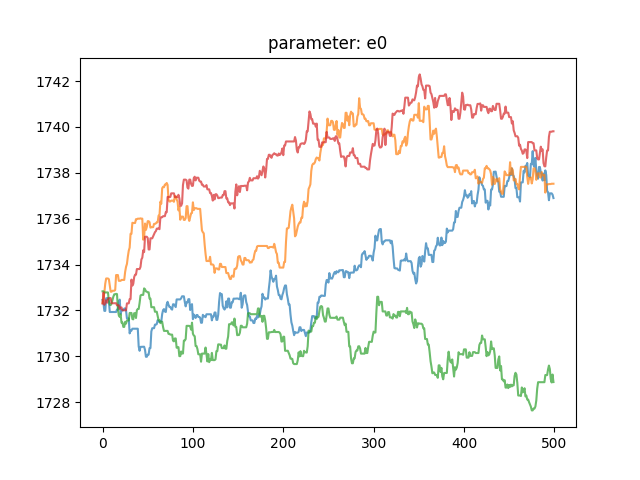

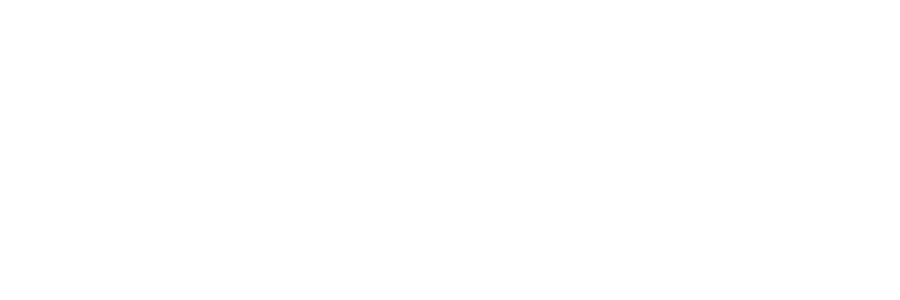

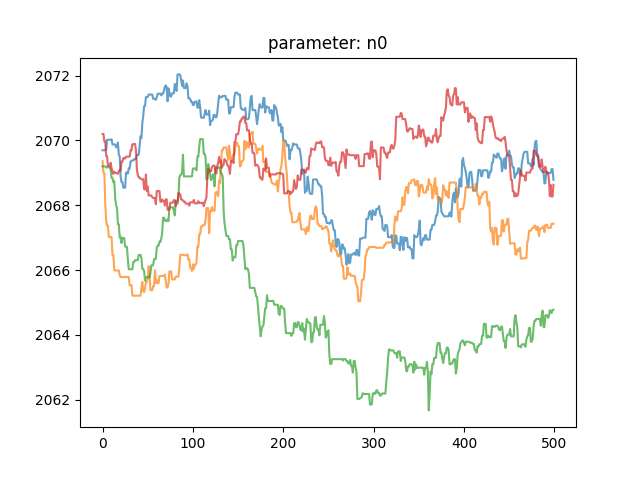

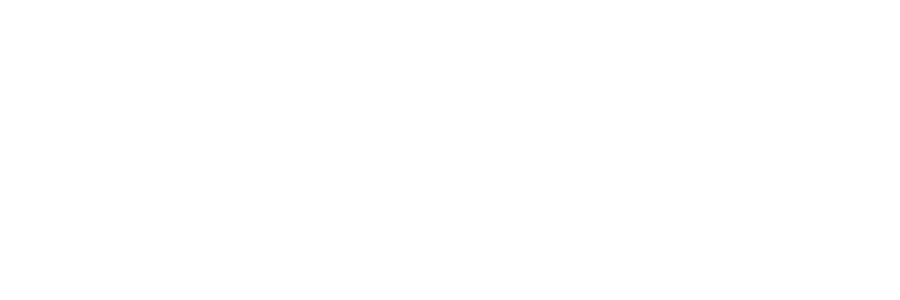

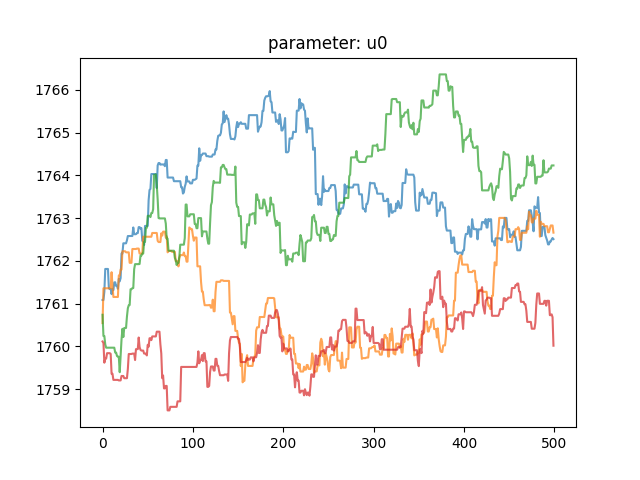

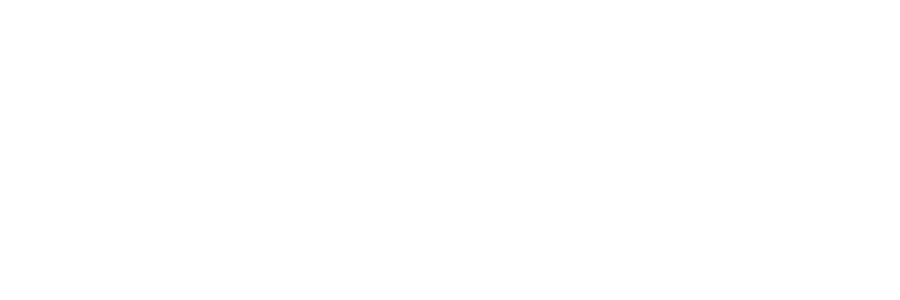

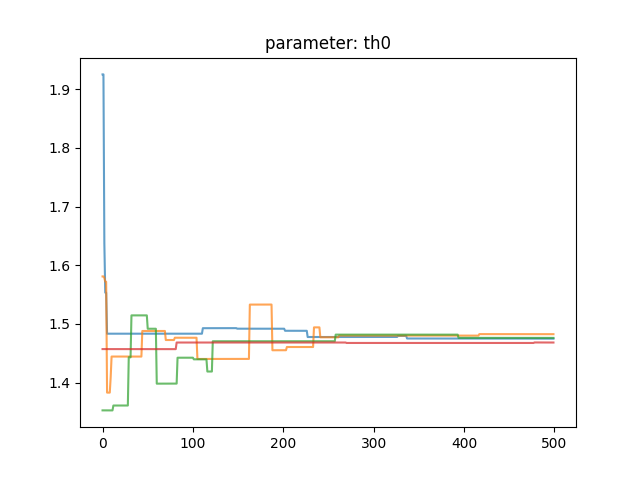

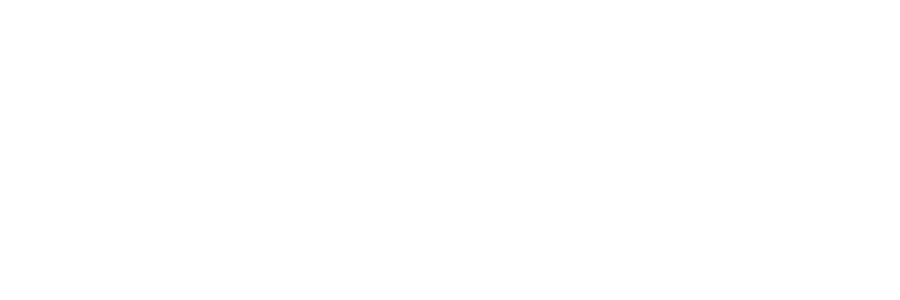

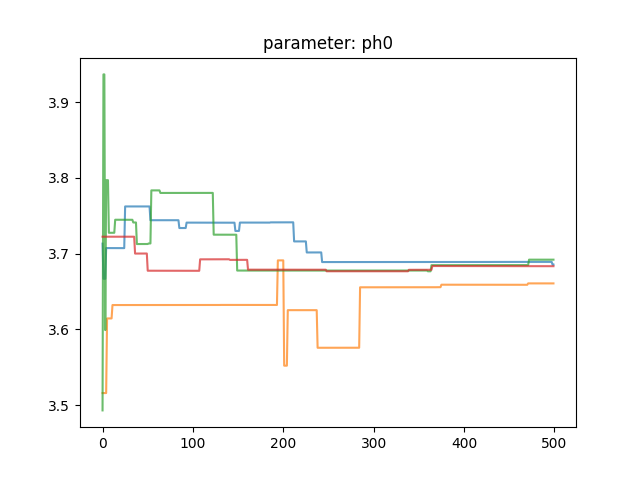

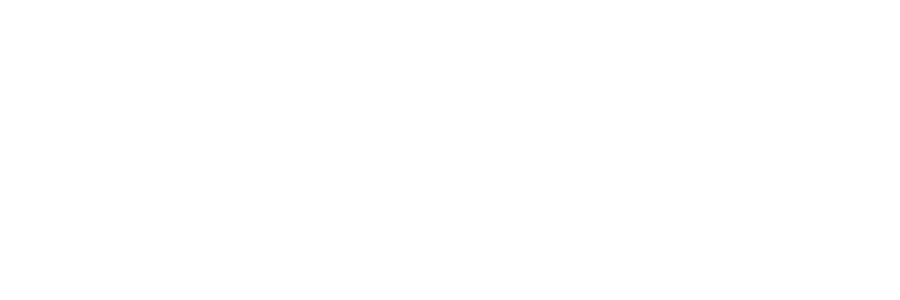

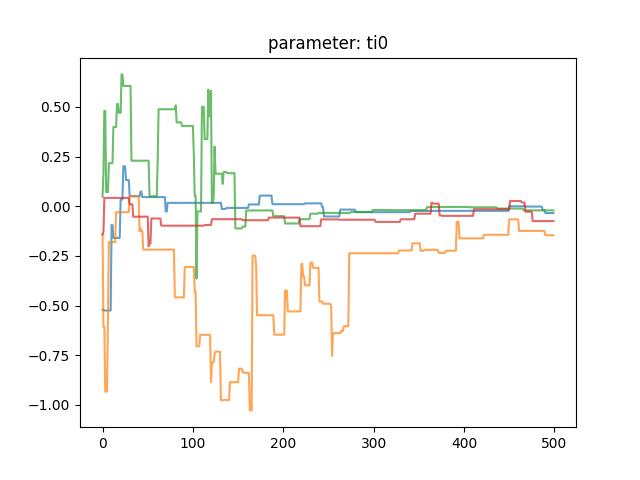

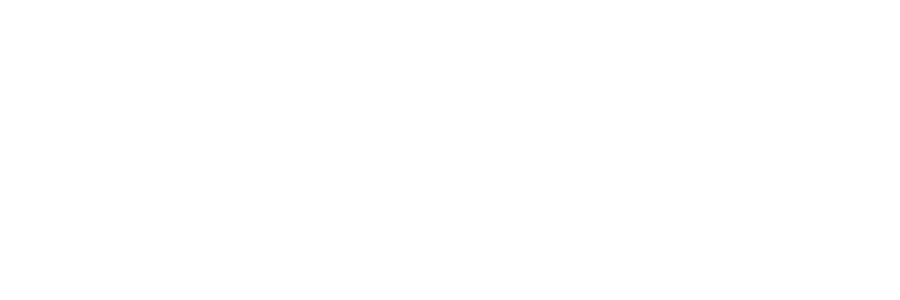

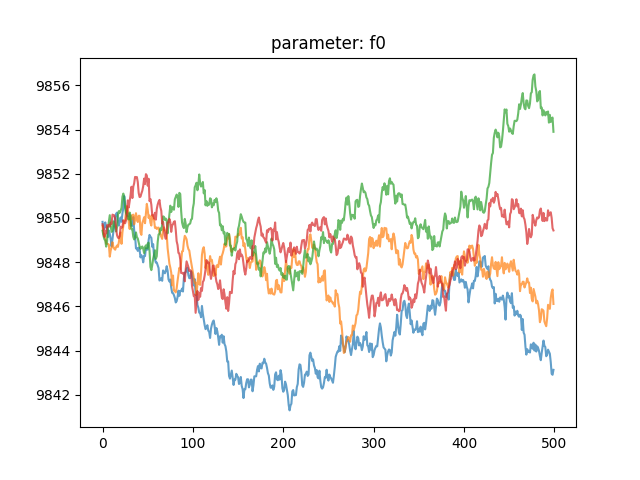

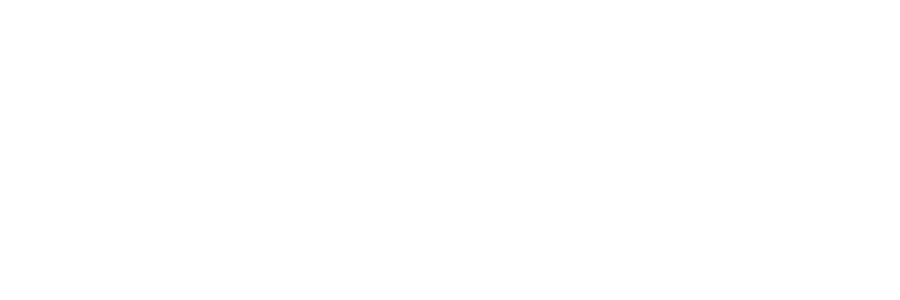

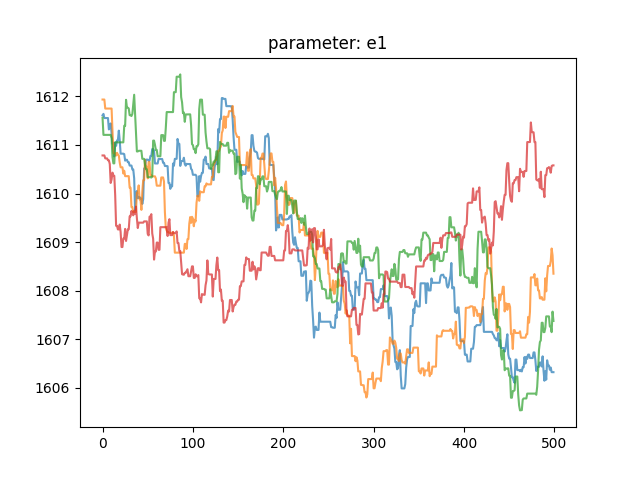

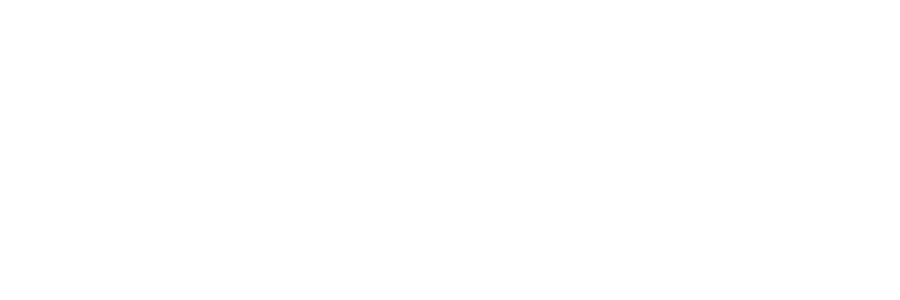

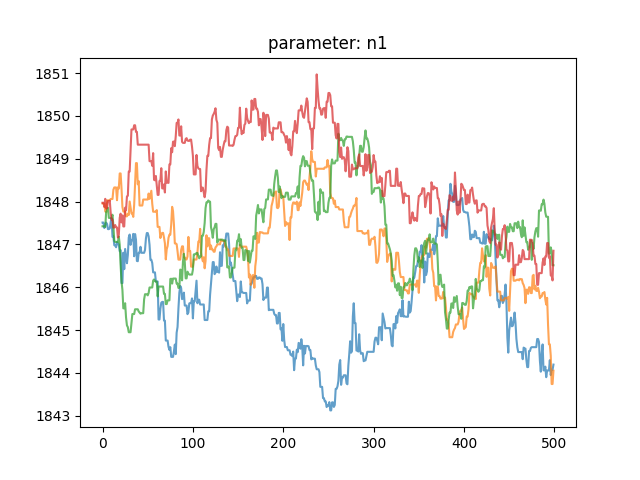

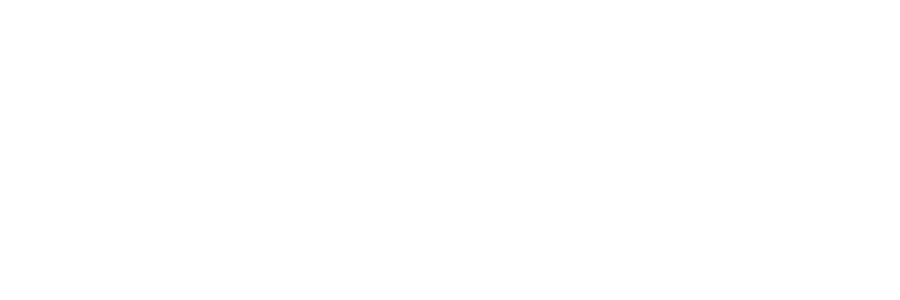

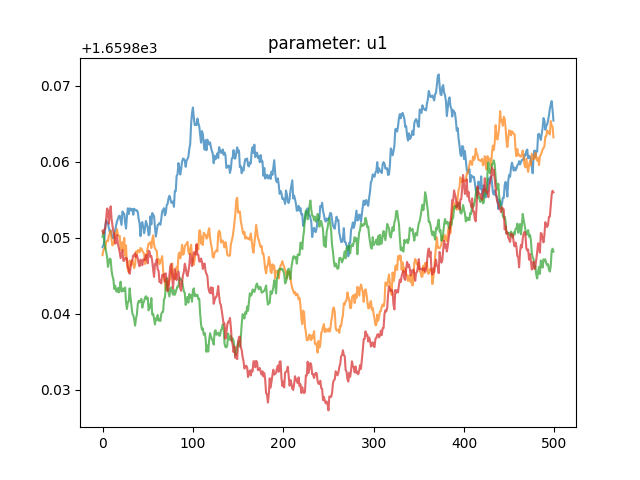

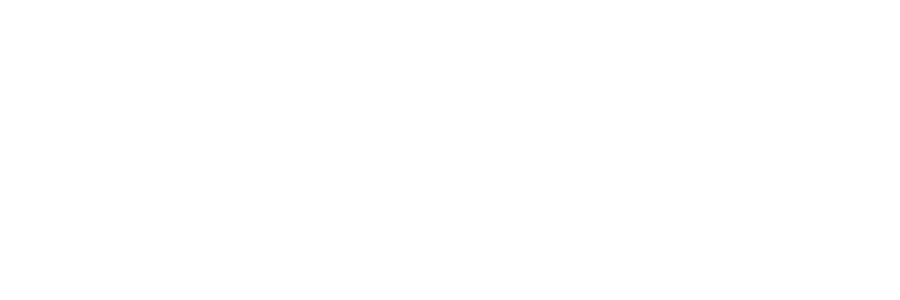

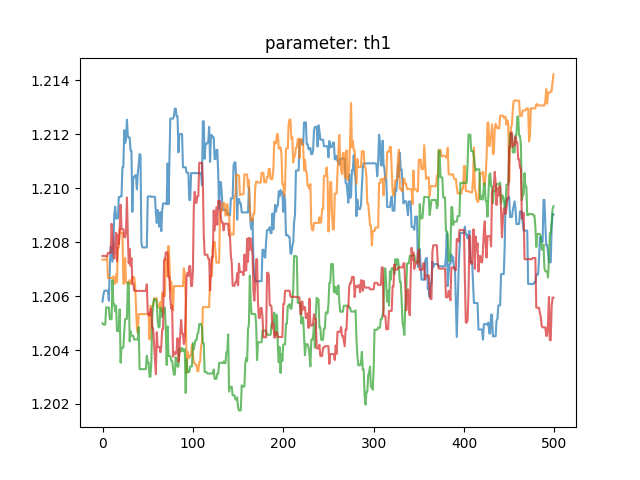

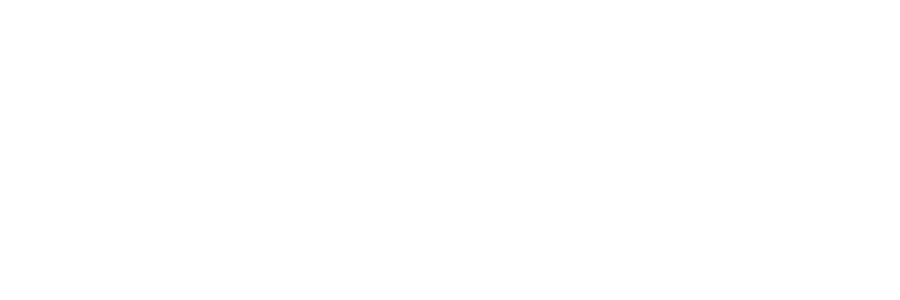

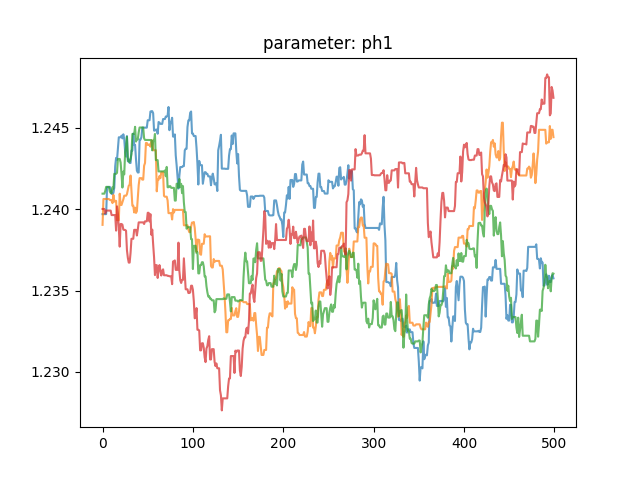

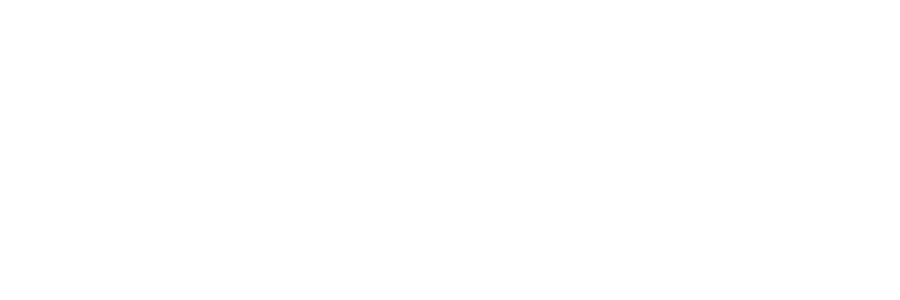

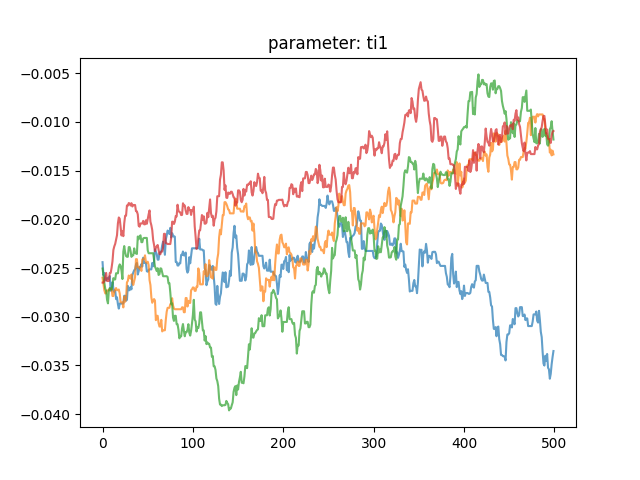

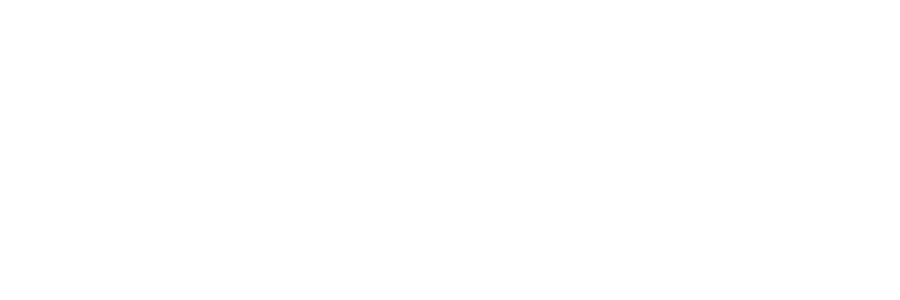

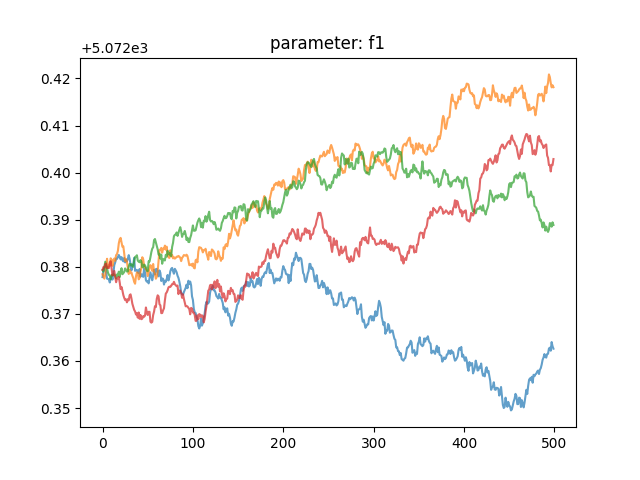

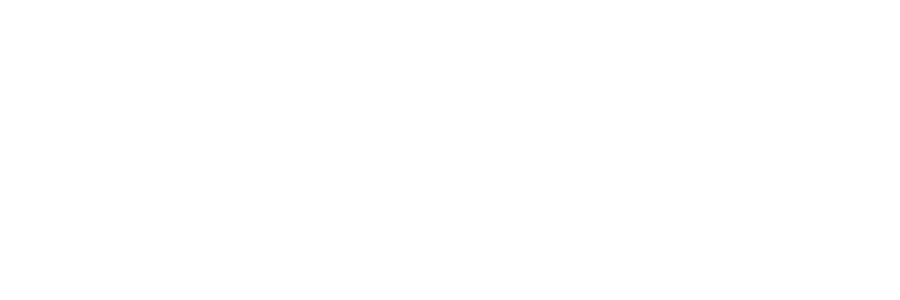

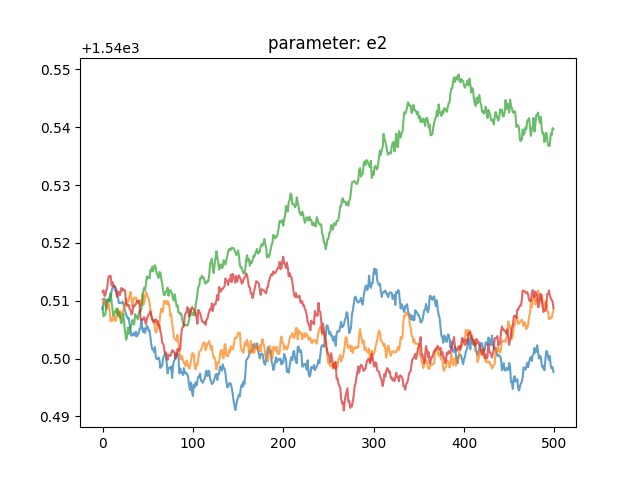

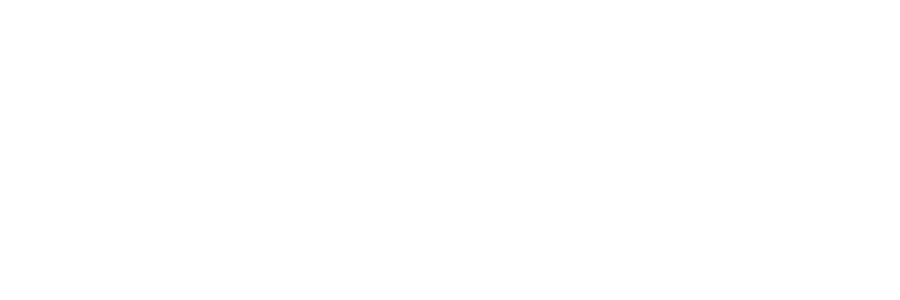

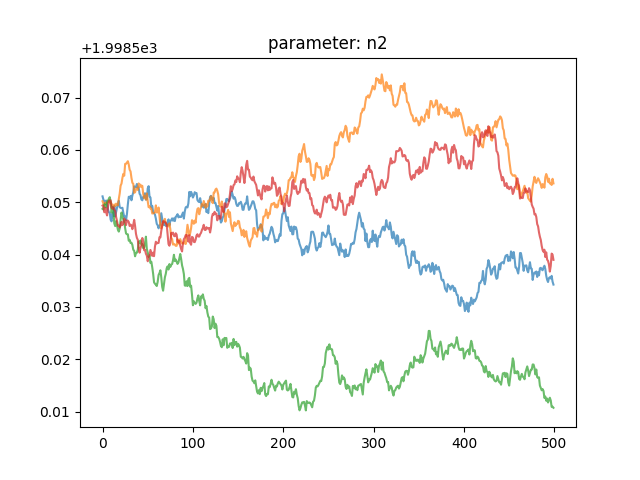

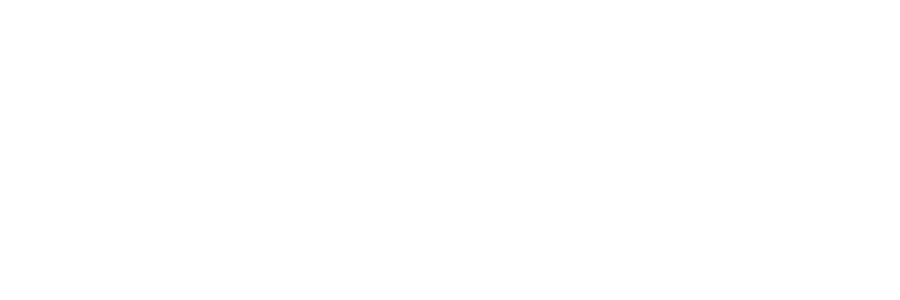

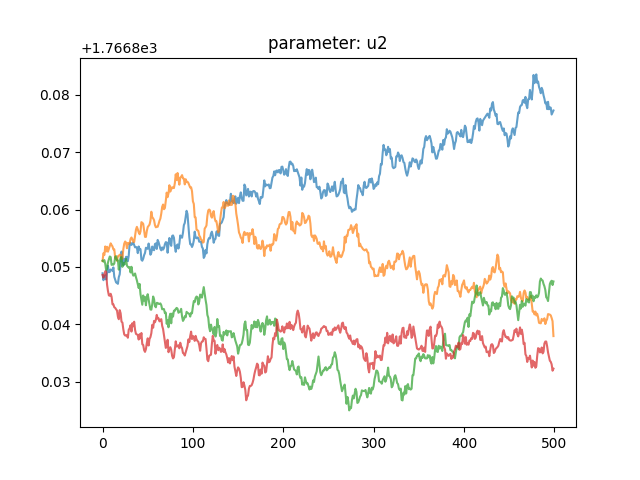

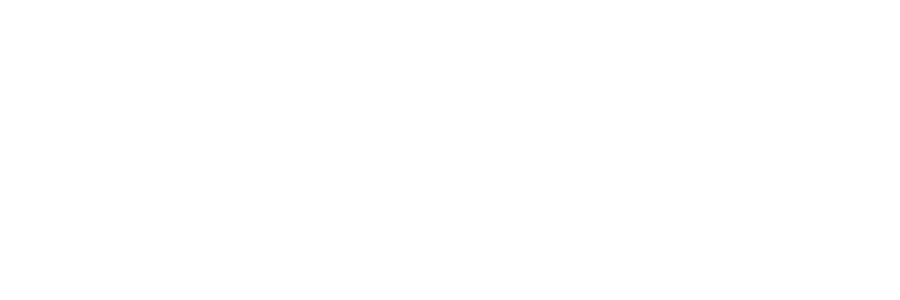

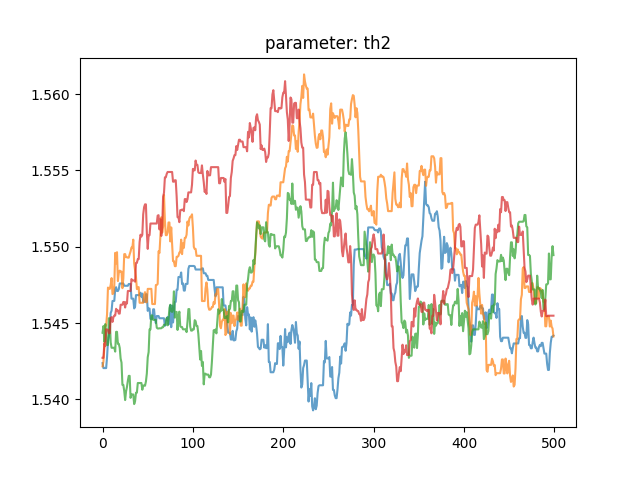

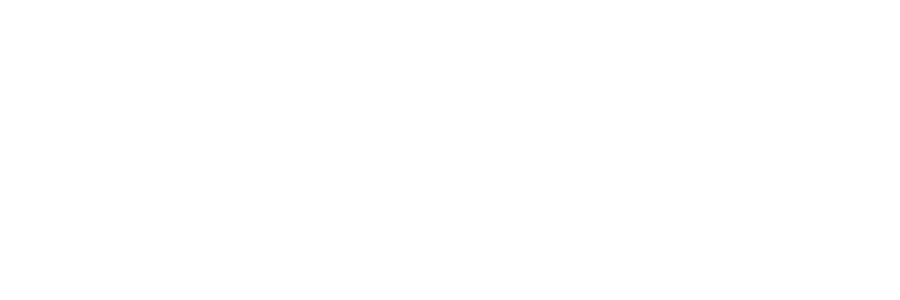

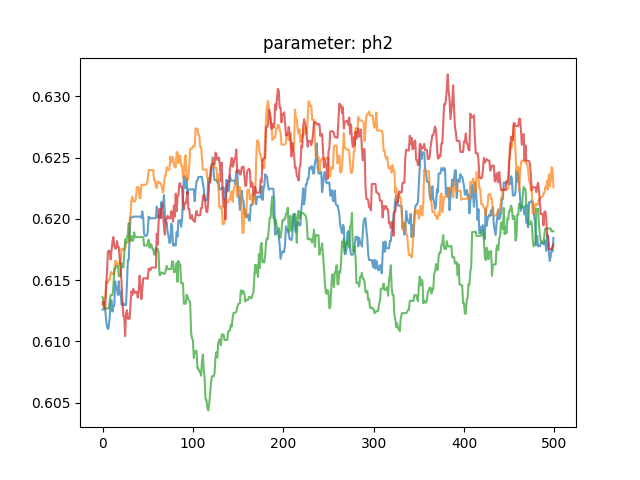

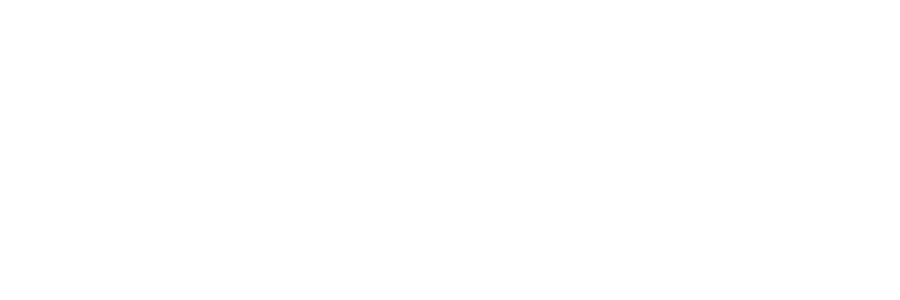

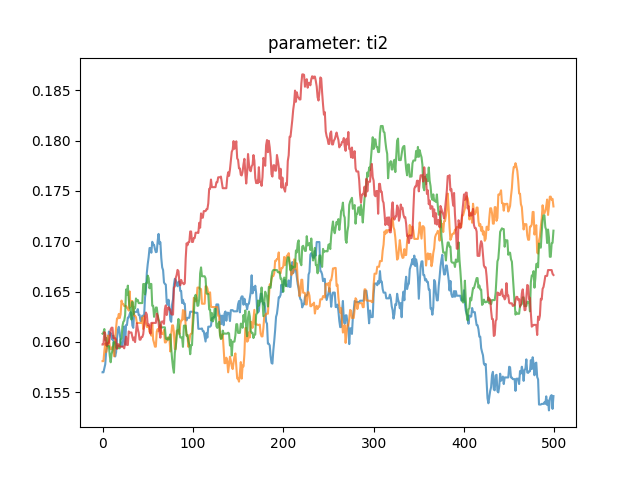

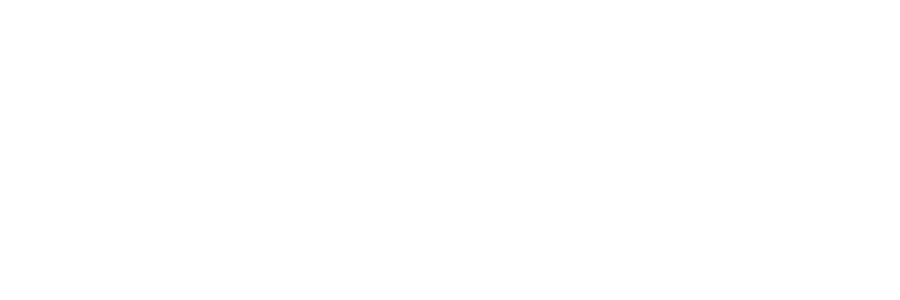

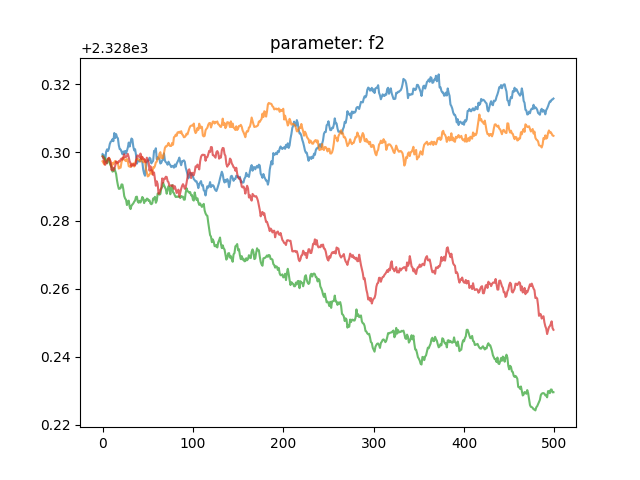

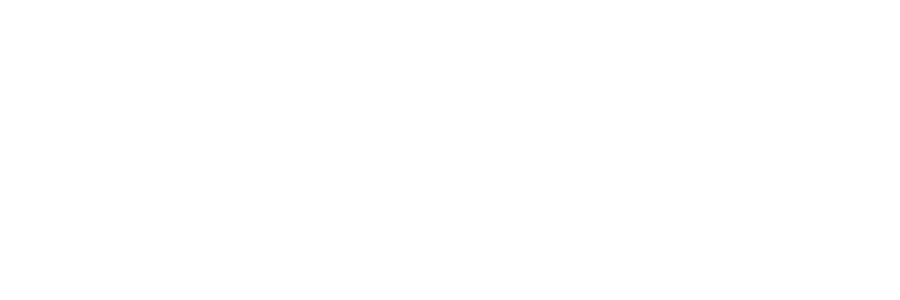

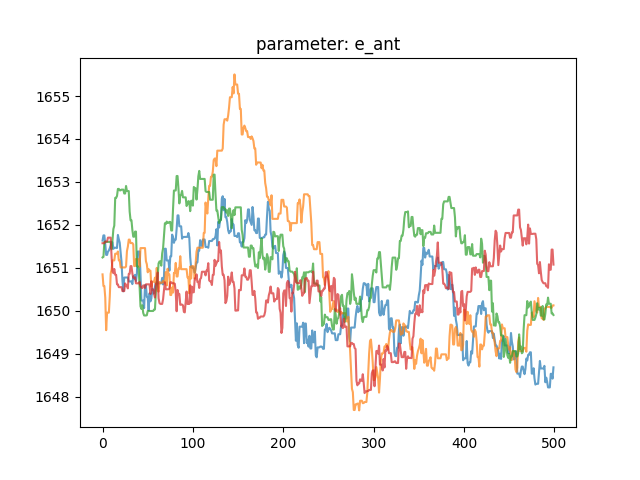

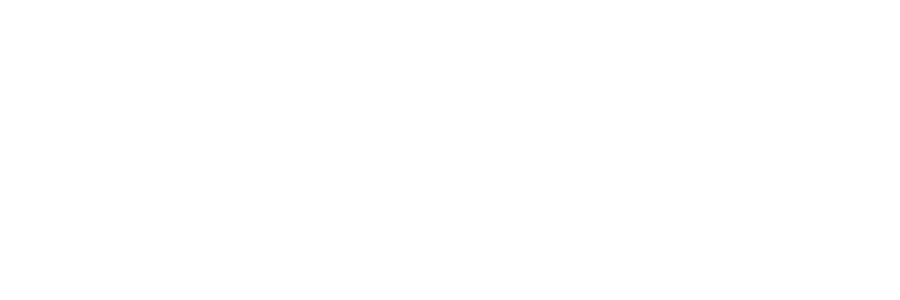

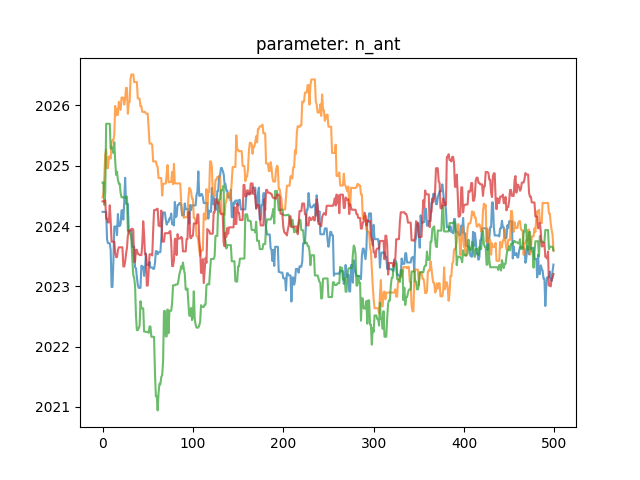

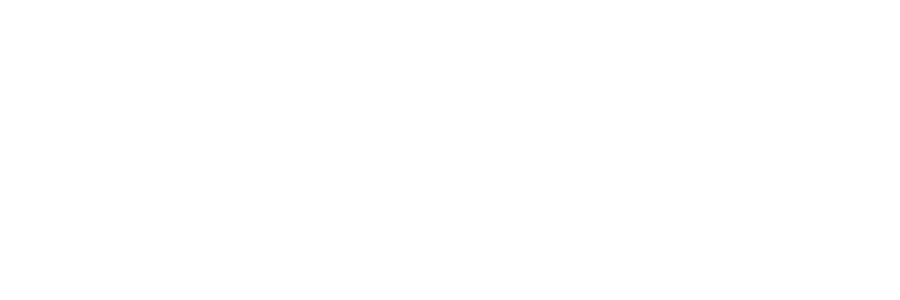

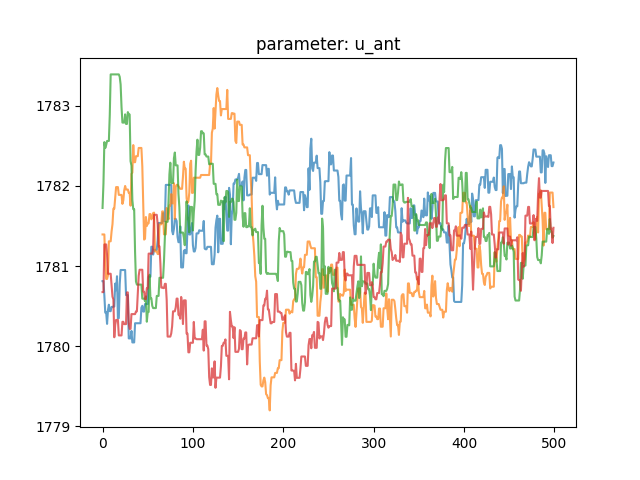

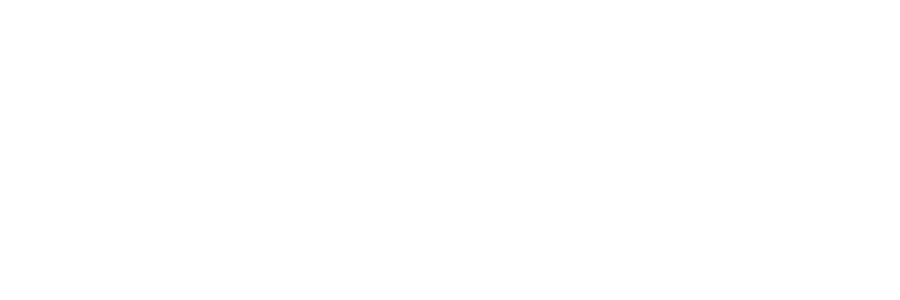

In [84]:
# plot traces

for prm_idx in range(24):
    fig, ax = plt.subplots()
    plt.figure(figsize=(9, 3))
    for chain in range(4):
        ax.plot(larger_traces.posterior['theta'].sel(chain=chain, theta_dim_0=prm_idx), alpha=0.7, label=f'Chain {chain}')
        ax.set_title(f'parameter: {PMR_ORDER_FULL[prm_idx]}')
        